### Aim
A notebook that solves Escape Interdiction Games (EIG) according to the methods described in the original paper by Zhang et al., as well as using the methods in the intermediate report.
Both processes rely on an LP **CoreLP** which finds an optimal mixed strategy given a (small) subset of available strategies for both players.
After finding optimal mixed strategies, we use defender and attacker oracles to find a response to the most recent optimal mixed strategy of the opposition, then add the support of the response to the set of available strategies.
We iterate until no new improving strategies can be found in consulting the oracles.

### Data & Generating EIG Instances
An EIG requires a directed network structure to model a city's road network.
We represent networks as a list of directed edges.
A directed edge from node `i` to `j` is given by `(i, j, d)` where `i` and `j` are nodes and `d` is the distance from `i` to `j`.
In this implementation we use a grid graph, and represent a node with a pair `(a, b)` corresponding to the row and column of the node in the grid graph.

An attacker strategy is a list `att` of 2-tuples `(v_i, t_i)` where the `i`th state entails `t_i` as the arrival time at node `v_i`.
It is also a named tuple, with labels `v` and `t` respectively.

A defender strategy is a list `def` of lists `def[r]` of 3-tuples `(v_j^r, t_j^r-, t_j^r+)` where the `j`th state entails `t_j^r-` as the arrival time at node `v_j^r` and `t_j^r+` as the departure time for resource `r`.
It is also a named tuple, with labels `v`, `t_a`, `t_b` respectively.

The time-discretisation parameter is `δ`, and the finite-horizon max-time is `t_max`.

In [5]:
# using Random
# using Distributions
using JuMP
using Gurobi
# using Plots
using DataStructures  # binary heap for Dijkstra's Algorithm, default dictionary
# using Formatting
using CSV  # for CSV reading (input)
using JSON  # for writing to JSON file (output)

In [6]:
struct Edge
    a::Int  # start node of edge
    b::Int  # end node of edge
    dist::Float64
end

struct NetworkGraph
    num_nodes::Int
    edges::Vector{Edge}
    v_0::Int  # attacker start node
    v_0r::Vector{Int}  # defender start nodes
    exit_nodes::Vector{Int}  # nodes with an outgoing edge to v_∞
    v_∞::Int  # attacker escape node
end

struct EIG
    network::NetworkGraph
    δ
    t_max
    dist_mtx
    neighbourhoods  # list of lists of (outgoing) neighbourhoods for each vertex
    speed_A
    speed_D
    # node_int_to_pair  # converts a node int representation into a pair of int representation (with coordinates interpretation)
end

node_int_to_pair(x, width) = ((x-1) ÷ width + 1, (x - 1) % width + 1)  # converts a node int representation into a pair of int representation (with coordinates interpretation)

# node_int_to_pair = ((x-1) ÷ WIDTH + 1, (x - 1) % WIDTH + 1)  # converts a node int representation into a pair of int representation (with coordinates interpretation)

node_int_to_pair (generic function with 1 method)

In [7]:
function generatenetwork(;length=3, width=3, orth_edge_prob=0.4, diag_edge_prob=0.2, num_defenders=4, num_exit_nodes=3, rounding=false)
    """
    Returns a grid (square) network where each pair of orthogonal (so vertical or horizontal) vertices has an edge with certain probabilities,
    and designates the attacker start node and defender resource start nodes.
    """
    # num_nodes = length * width;
    nodes = [(i, j) for i=1:length for j=1:width];  # list of nodes, pairs of integers
    # nodes = [i for i in 1:length * width];  # list of nodes, pairs of integers
    
    # determine edges
    edges = []
    
    # vertical edges
    for i=1:length-1 for j=1:width
            if rand() < orth_edge_prob; push!(edges, ((i, j), (i+1, j), generatedist(rounding=rounding))); end
            if rand() < orth_edge_prob; push!(edges, ((i+1, j), (i, j), generatedist(rounding=rounding))); end  # other direction (independent of first direction)
    end end
    
    # horizontal edges
    for i=1:length for j=1:width-1
            if rand() < orth_edge_prob; push!(edges, ((i, j), (i, j+1), generatedist(rounding=rounding))); end
            if rand() < orth_edge_prob; push!(edges, ((i, j+1), (i, j), generatedist(rounding=rounding))); end
    end end
    
    # N-diagonal edges
    for i=1:length-1 for j=1:width-1
            if rand() < diag_edge_prob; push!(edges, ((i, j), (i+1, j+1), generatedist(rounding=rounding))); end
            if rand() < diag_edge_prob; push!(edges, ((i+1, j+1), (i, j), generatedist(rounding=rounding))); end
    end end
    
    # Z-diagonal edges
    for i=1:length-1 for j=1:width-1
            if rand() < diag_edge_prob; push!(edges, ((i+1, j), (i, j+1), generatedist(rounding=rounding))); end
            if rand() < diag_edge_prob; push!(edges, ((i, j+1), (i+1, j), generatedist(rounding=rounding))); end
    end end
    
    # add v_∞ node adjacent to all nodes on the border of the grid
    v_infty_node = (length, width+1)  # represented as this so that the integer form is 1 above the greatest internal node
    push!(nodes, v_infty_node)
    
    push!(edges, (v_infty_node, v_infty_node, 0.0))  # add loop at v_∞ node
    
    # choose exit nodes on border (implicitly connected to the ultimate exit node v_∞); first create list of border nodes
    border_nodes = []
    for i=1:length
        push!(border_nodes, (i, 1));
        push!(border_nodes, (i, width));
    end
    for j=2:width-1
        push!(border_nodes, (1, j));
        push!(border_nodes, (length, j));
    end
    
    exit_nodes = sample(border_nodes, num_exit_nodes, replace=false)
    
    for node in exit_nodes
        push!(edges, (node, v_infty_node, generatedist(rounding=rounding)));
    end
    
#     # top and bottom border nodes
#     for i=1:length
#         push!(edges, ((i, 1), v_infty_node, generatedist()));
#         push!(edges, ((i, width), v_infty_node, generatedist()));
#     end
    
#     # left and right border nodes
#     for j=2:width-1
#         push!(edges, ((1, j), v_infty_node, generatedist()));
#         push!(edges, ((length, j), v_infty_node, generatedist()));
#     end
    
    # pick attacker start node in middle of grid
    att_start_node = ((length + 1) ÷ 2, (width + 1) ÷ 2)
    
    # pick defender resource start nodes
    def_start_nodes = []
    for resource=1:num_defenders
        # generate random node, but ensure it is not the attacker start node
        new_node = (rand(1:length), rand(1:width))
        while new_node == att_start_node
            new_node = (rand(1:length), rand(1:width))
        end
        push!(def_start_nodes, new_node)
    end
    
    # sort edges by first vertex
    sort!(edges)
    
    new_nodes, new_edges, new_att_start_node, new_def_start_nodes, new_exit_nodes = convertEIGnodestointegerform(nodes, edges, att_start_node, def_start_nodes, exit_nodes, width=width)
    
    # display(nodes)
    # display(new_edges)
    
    edges_ = [Edge(e[1], e[2], e[3]) for e in new_edges]
    
    network = NetworkGraph(size(new_nodes)[1], edges_, new_att_start_node, new_def_start_nodes, new_exit_nodes, size(new_nodes)[1])
    return network
    # return (nodes, edges, att_start_node, def_start_nodes, exit_nodes)
end

generatenetwork (generic function with 1 method)

In [8]:
function generatedist(;C_e=6, rounding=false)
    """
    Returns a travel time according to eq (3) in Zhang et al.
    Note if T_e, f_e and C_e are rational, then the generated distance is rational. 
    """
    T_e = rand(1:10)
    f_e = rand(1:6)
    
    result = T_e * (1 + 0.15 * (f_e / C_e)^4)

    return rounding ? round(result) : result
end

generatedist (generic function with 1 method)

In [9]:
function convertEIGnodestointegerform(nodes, edges, att_start_node, def_start_nodes, exit_nodes; width)
    """
    Helper function for generating EIG networks.
    """
    mapping(x) = width*(x[1]-1) + x[2]
    
    new_nodes = 1:length(nodes)
    
    new_edges = []
    for edge in edges
        push!(new_edges, (mapping(edge[1]), mapping(edge[2]), edge[3]))
    end
    
    new_att_start_node = mapping(att_start_node)
    
    new_def_start_nodes = []
    for node in def_start_nodes
        push!(new_def_start_nodes, mapping(node))
    end
    
    new_exit_nodes = []
    for node in exit_nodes
        push!(new_exit_nodes, mapping(node))
    end
    
    return new_nodes, new_edges, new_att_start_node, new_def_start_nodes, new_exit_nodes
end

convertEIGnodestointegerform (generic function with 1 method)

In [10]:
function computedistancematrix(network::NetworkGraph)
    """
    Returns a matrix whose ijth entry is the distance from node i to node j
    Employs Floyd–Warshall algorithm (all pairs distances)
    """
    n = network.num_nodes
    dist = fill(Inf, (n, n))
    
    for e in network.edges
        dist[e.a, e.b] = e.dist
    end
    for i=1:n
        dist[i, i] = 0
    end
    for k=1:n
        for i=1:n
            for j=1:n
                potential_dist = dist[i, k] + dist[k, j]
                if dist[i, j] > potential_dist
                    dist[i, j] = potential_dist
                end
            end
        end
    end
    
    return dist
end

computedistancematrix (generic function with 1 method)

In [11]:
function computeneighbourhoods(network::NetworkGraph)
    """
    Returns, for each node v, a list of vertices [u] such that vu is an edge/arc 
    (Assumes integer nodes)
    """
    neighbourhoods = [[] for _ in 1:network.num_nodes]  # all empty lists to begin
    for e in network.edges
        # update appropriate neighbourhood
        push!(neighbourhoods[e.a], e.b)
    end
    
    # push!(neighbourhoods[network.v_∞], network.v_∞)  # add loop at v_∞ node (to allow attacker strategies to end on v_∞ node prematurely)
    
    return neighbourhoods
end

# function computeneighbourhoods(nodes, edges)
#     """
#     Returns, for each node v, a list of vertices [u] such that vu is an edge/arc 
#     (Assumes integer nodes)
#     """
#     neighbourhoods = [[] for _ in nodes]
#     for edge in edges
#         # update appropriate neighbourhood
#         push!(neighbourhoods[edge[1]], edge[2])
#     end
#     return neighbourhoods
# end

computeneighbourhoods (generic function with 1 method)

In [12]:
# WIDTH = 3
# LENGTH = 3

# EIG_not_generated = true

# network = nothing
# dist_mtx = nothing

# # nodes = nothing
# # edges = nothing
# # v_0 = nothing
# # v_0r = nothing
# # exit_nodes = nothing

# # nodes_p = nothing
# # edges_p = nothing
# # att_start_node_p = nothing
# # def_start_nodes_p = nothing
# # exit_nodes_p = nothing


# while EIG_not_generated
#     # nodes_p, edges_p, att_start_node_p, def_start_nodes_p, exit_nodes_p = generatenetwork(WIDTH);

#     # nodes, edges, v_0, v_0r, exit_nodes = convertEIGnodestointegerform(nodes_p, edges_p, att_start_node_p, def_start_nodes_p, exit_nodes_p)
#     network = generatenetwork(width=WIDTH, length=LENGTH, num_defenders=3, orth_edge_prob=0.7, diag_edge_prob=0.4, rounding=true)
#     # generatenetwork(;length=3, width=3, orth_edge_prob=0.4, diag_edge_prob=0.2, num_defenders=4, num_exit_nodes=3)
#     dist_mtx = computedistancematrix(network);

#     # display(dist_mtx)
    
#     EIG_not_generated = false
    
#     if dist_mtx[network.v_0, network.num_nodes] == Inf
#         println("!!!!!!!!!!!!!!!!!No path from v_0 to v_∞")
#         EIG_not_generated = true
#     end
# end

# # chosen T_MAX and DELTA values (paper doesn't have explicit choices)
# DELTA = 1
# T_MAX = maximum(filter(!isinf, dist_mtx))

# neighbourhoods = computeneighbourhoods(network);

# node_int_to_pair(x) = ((x-1) ÷ WIDTH + 1, (x - 1) % WIDTH + 1)  # converts a node int representation into a pair of int representation (with coordinates interpretation)

# the_eig = EIG(network, DELTA, T_MAX, dist_mtx, neighbourhoods, node_int_to_pair)

### Solving

#### Heuristic initial strategies

In [13]:
function shortest_path(eig::EIG, init_node::Int, destination::Int; scale_divisor=1)
    """
    Returns a shortest path of the form [(v_i, t_i) for i]
    Uses Dijkstra's algorithm

    scale_divisor: Divides times (t_i) by scale_divisor at the very end once the shortest path is found.
    """
    # find path from v_0 to v_∞
    
    max_dist = maximum(filter(!isinf, eig.dist_mtx))
    
    dist = [Inf for _ in 1:eig.network.num_nodes]
    prev = [-1 for _ in 1:eig.network.num_nodes]
    
    dist[init_node] = 0
    
    # add all vertices to min-heap
    minheap = MutableBinaryMinHeap{Float64}()
    # minheap = BinaryMinHeap([])
    
    for node in 1:eig.network.num_nodes
        # push!(minheap, [dist[node], node])  # ordered by distance (first entry in tuple)
        node_heap_id = push!(minheap, dist[node])  # save distance into heap; node is encoded in the handle 
    end
    
    # vertexlist = [node for node in nodes]  # quick implementation
    
    while length(minheap) > 0  # heap not empty
        # find vertex still in vertexlist with least distance from v_0
        # d_u, u = pop!(minheap)
        
        # d_u = pop!(minheap)
        d_u, u = top_with_handle(minheap)
        pop!(minheap)
        
        # display((d_u, u))
        
        # u = argmin(dist)  # 
        # deleteat!(vertexlist, u)
        # u = Int(u)  # convert node to integer (as it is a float when in the heap)
        # display(u)
        
        for v in eig.neighbourhoods[u]
            altdist = dist[u] + eig.dist_mtx[u, v]
            if altdist < dist[v]
                dist[v] = altdist
                
                update!(minheap, v, altdist)  # also update heap 
                
                prev[v] = u
            end
        end
    end
    
    # display(prev)
    
    # construct sequence of nodes to traverse (as well as distances)
    seq_rev = []
    # u = length(nodes)  # begin at v_∞
    
    u = destination
    
    # push!(seq_rev, (v=u, t=dist[destination]))
    # u = prev[u]

    while prev[u] != -1
        push!(seq_rev, (v=u, t=dist[u] / scale_divisor))  # divide by scale_divisor
        u = prev[u]
    end

    push!(seq_rev, (v=init_node, t=0.0))
    
    return reverse(seq_rev)
end

shortest_path (generic function with 1 method)

In [14]:
function makeheuristicattacker(eig::EIG)
    """
    Generates a simple attacker strategy where the attacker heads towards an exit node as quickly as possible.
    Uses Dijkstra's algorithm
    """
    
    path = shortest_path(eig, eig.network.v_0, eig.network.v_∞, scale_divisor=eig.speed_A)
    path[end] = (v=eig.network.v_∞, t=eig.t_max)  # ensure escape at t_max 
    return path
    
    
#     # find path from v_0 to v_∞
    
#     max_dist = maximum(filter(!isinf, eig.dist_mtx))
    
#     dist = [max_dist for _ in 1:eig.network.num_nodes]
#     prev = [-1 for _ in 1:eig.network.num_nodes]
    
#     dist[eig.network.v_0] = 0
    
#     # add all vertices to min-heap
#     minheap = MutableBinaryMinHeap{Float64}()
#     # minheap = BinaryMinHeap([])
    
#     for node in 1:eig.network.num_nodes
#         # push!(minheap, [dist[node], node])  # ordered by distance (first entry in tuple)
#         node_heap_id = push!(minheap, dist[node])  # save distance into heap; node is encoded in the handle 
#     end
    
#     # vertexlist = [node for node in nodes]  # quick implementation
    
#     while length(minheap) > 0  # heap not empty
#         # find vertex still in vertexlist with least distance from v_0
#         # d_u, u = pop!(minheap)
        
#         # d_u = pop!(minheap)
#         d_u, u = top_with_handle(minheap)
#         pop!(minheap)
        
#         # display((d_u, u))
        
#         # u = argmin(dist)  # 
#         # deleteat!(vertexlist, u)
#         # u = Int(u)  # convert node to integer (as it is a float when in the heap)
#         # display(u)
        
#         for v in eig.neighbourhoods[u]
#             altdist = dist[u] + eig.dist_mtx[u, v]
#             if altdist < dist[v]
#                 dist[v] = altdist
                
#                 update!(minheap, v, altdist)  # also update heap 
                
#                 prev[v] = u
#             end
#         end
#     end
    
#     # display(prev)
    
#     # construct sequence of nodes to traverse (as well as distances)
#     seq_rev = []
#     # u = length(nodes)  # begin at v_∞
    
#     u = eig.network.v_∞
    
#     push!(seq_rev, (v=u, t=eig.t_max))  # ensure escape at t_max
#     u = prev[u]

#     while prev[u] != -1
#         push!(seq_rev, (v=u, t=dist[u]))
#         u = prev[u]
#     end

#     push!(seq_rev, (v=eig.network.v_0, t=0.0))
    
#     return reverse(seq_rev)
end

makeheuristicattacker (generic function with 1 method)

In [15]:
function makeheuristicdefender(eig::EIG)
    """
    Generates a simple defender strategy where the defender stays at their start locations.
    """
    return [[(v=init_node, t_a=0.0, t_b=ceil(eig.t_max))] for init_node in eig.network.v_0r]
end

makeheuristicdefender (generic function with 1 method)

In [16]:
function makedefres_path(eig::EIG, resource_idx, end_node)
    """
    Returns a defender path where resource goes straight to end_node (via a shortest path), then waits there forever.
    If the resource cannot reach end_node within t_max, then the resource just stays at their v_0r forever.
    """
    if end_node == eig.network.v_0r[resource_idx]
        return [(v=end_node, t_a = 0.0, t_b=ceil(eig.t_max))]  # stay on exit node forever
    end
    
    if div(eig.dist_mtx[eig.network.v_0r[resource_idx], end_node], eig.speed_D) > eig.t_max
        return [(v=eig.network.v_0r[resource_idx], t_a = 0.0, t_b=ceil(eig.t_max))]  # stay at v_0r forever
    end
    
    path = shortest_path(eig, eig.network.v_0r[resource_idx], end_node, scale_divisor=eig.speed_D)
    
    return [
        (v=eig.network.v_0r[resource_idx], t_a = 0.0, t_b=0.0),
        (v=end_node, t_a=path[end].t, t_b=ceil(eig.t_max))
    ]
end

makedefres_path (generic function with 1 method)

In [17]:
function makedefstrat_path(eig, end_nodes)
    """
    Returns a defender strategy where resource goes straight to an end_node (via a shortest path), then waits there forever.
    If a resource cannot reach their specified end_node, then the resource just stays at their v_0r forever (this is so that we can animate).
    """
    return [makedefres_path(eig, r, end_nodes[r]) for r=1:length(eig.network.v_0r)]
end

makedefstrat_path (generic function with 1 method)

In [18]:
function makedefstrat_endnodes(eig)
    """
    Returns a defender strategy where each resource goes straight to an exit node
    """
    exit_nodes = eig.network.exit_nodes
    num_res = length(eig.network.v_0r)
    
    # cycle through exit_nodes, sending resource straight to exit node
    end_nodes = [exit_nodes[idx % num_res + 1] for idx in 1:num_res]  # end nodes for each resource (can be more clever with choice, but this is just a quick code)
    
    return makedefstrat_path(eig, end_nodes)
end

makedefstrat_endnodes (generic function with 1 method)

#### Visualisation

In [19]:
# function drawEIGgraph(eig::EIG; arrow_size=0.03, arrow_os=0.2, width)
#     my_plot = plot(;aspect_ratio=:equal)  # init plot with nothing
        
#     # plot edges
#     for edge in eig.network.edges
        
#         if edge.b == eig.network.v_∞
#             continue  # don't plot v_∞ node
#         end
        
#         # convert int to pair representation for nodes
#         xa, ya = node_int_to_pair(edge.a, width)
#         xb, yb = node_int_to_pair(edge.b, width)
        
#         xs = [xa, xb]
#         ys = [ya, yb]
        
#         plot!(xs, ys; line=(1, :black, :solid), marker=(:circle, :black, 1), label="")
        
#         # draw directed arrowheads
#         if ya == yb
#             # horizontal edge
#             if xa < xb
#                 # arrow pointing right
#                 plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya + arrow_size, ya]; line=(1, :black, :solid), label="")
#                 plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya - arrow_size, ya]; line=(1, :black, :solid), label="")
                
#             else
#                 # arrow pointing left
#                 plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya + arrow_size, ya]; line=(1, :black, :solid), label="")
#                 plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya - arrow_size, ya]; line=(1, :black, :solid), label="")
#             end
#         elseif xa == xb
#             # vertical edge
#             if ya < yb
#                 # arrow pointing up
#                 plot!([xa - arrow_size, xa], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                 plot!([xa + arrow_size, xa], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#             else
#                 # arrow pointing down
#                 plot!([xa - arrow_size, xa], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
#                 plot!([xa + arrow_size, xa], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
#             end
#         else
#             # diagonal edge
#             if xa < xb
#                 if ya < yb
#                     # point up-right
#                     plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya + arrow_os, ya + arrow_os]; line=(1, :black, :solid), label="")
#                     plot!([xa + arrow_os, xa + arrow_os], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                 else
#                     # point down-right
#                     plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya - arrow_os, ya - arrow_os]; line=(1, :black, :solid), label="")
#                     plot!([xa + arrow_os, xa + arrow_os], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
                    
#                 end
#             else
#                 if ya < yb
#                     # point up-left
#                     plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya + arrow_os, ya + arrow_os]; line=(1, :black, :solid), label="")
#                     plot!([xa - arrow_os, xa - arrow_os], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                 else
#                     # point down-left
#                     plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya - arrow_os, ya - arrow_os]; line=(1, :black, :solid), label="")
#                     plot!([xa - arrow_os, xa - arrow_os], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
#                 end
#             end
#         end
#     end
    
#     # plot exit nodes (nodes having an arc towards v_∞)
#     for exit_node in eig.network.exit_nodes
#         pair_repr = node_int_to_pair(exit_node, width)
#         plot!(pair_repr; marker=(:circle, :blue, 6), label="")
#     end
    
#     # plot attacker start node
#     plot!(node_int_to_pair(eig.network.v_0, width); marker=(:circle, :red, 4), label="")
    
#     # plot defender start nodes
#     for v_0r in eig.network.v_0r
#         pair_repr = node_int_to_pair(v_0r, width)
#         plot!(pair_repr; marker=(:circle, :lightgreen, 4), label="")
#     end
    
#     display(my_plot)
# end

drawEIGgraph (generic function with 1 method)

In [20]:
# function animateEIGPure(eig::EIG, att_strat, def_strat; arrow_size=0.03, arrow_os=0.2, anim_time=3, fps=30, savefilename="EIG_GIF_EXAMPLE", width)
    
#     num_frames = ceil(Int, anim_time * fps)
    
#     curr_att_num = 1  # attacker state numbers
#     curr_def_nums = fill(1, size(def_strat)[1])  # resource state numbers
    
#     MAX_TIME = eig.t_max  # maximum 'interesting' time in EIG to animate to; choose such that the attacker has entered an exit-node + 1
#     for state in att_strat
#         if state.v in eig.network.exit_nodes
#             MAX_TIME = state.t + 1 # attacker will trivially escape 
#             break;
#         end
#     end
    
    
#     # precompute resource paths
#     res_all_paths = [[] for _ in 1:length(def_strat)]  # ith entry is a list of paths, one for each transition between resource states
#     for (j, res) in enumerate(def_strat)
#         # compute paths for this resource res
#         res_paths = []

#         for (state_num, state) in enumerate(res[1:end-1])
#             # find path from state_num to state_num+1
#             path = shortest_path(eig, state.v, res[state_num+1].v, scale_divisor=eig.speed_D)
#             push!(res_paths, path)
#         end
#         res_all_paths[j] = res_paths
#     end
    
#     anim = @animate for i = 1:num_frames
#         # first determine time t elapsed for EIG as a function of i
#         eig_time = i / num_frames * MAX_TIME
        
#         title_str = string(round(eig_time))
        
#         plot(;aspect_ratio=:equal, title = "t = $title_str", showaxis = false)  # init plot with nothing; also display EIG-time as title
        
#         # plot edges
#         for edge in eig.network.edges

#             if edge.b == eig.network.v_∞
#                 continue  # don't plot v_∞ node
#             end

#             # convert int to pair representation for nodes
#             xa, ya = node_int_to_pair(edge.a, width)
#             xb, yb = node_int_to_pair(edge.b, width)

#             xs = [xa, xb]
#             ys = [ya, yb]

#             plot!(xs, ys; line=(1, :black, :solid), marker=(:circle, :black, 1), label="")

#             # draw directed arrowheads
#             if ya == yb
#                 # horizontal edge
#                 if xa < xb
#                     # arrow pointing right
#                     plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya + arrow_size, ya]; line=(1, :black, :solid), label="")
#                     plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya - arrow_size, ya]; line=(1, :black, :solid), label="")

#                 else
#                     # arrow pointing left
#                     plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya + arrow_size, ya]; line=(1, :black, :solid), label="")
#                     plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya - arrow_size, ya]; line=(1, :black, :solid), label="")
#                 end
#             elseif xa == xb
#                 # vertical edge
#                 if ya < yb
#                     # arrow pointing up
#                     plot!([xa - arrow_size, xa], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                     plot!([xa + arrow_size, xa], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                 else
#                     # arrow pointing down
#                     plot!([xa - arrow_size, xa], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
#                     plot!([xa + arrow_size, xa], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
#                 end
#             else
#                 # diagonal edge
#                 if xa < xb
#                     if ya < yb
#                         # point up-right
#                         plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya + arrow_os, ya + arrow_os]; line=(1, :black, :solid), label="")
#                         plot!([xa + arrow_os, xa + arrow_os], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                     else
#                         # point down-right
#                         plot!([xa + arrow_os - arrow_size, xa + arrow_os], [ya - arrow_os, ya - arrow_os]; line=(1, :black, :solid), label="")
#                         plot!([xa + arrow_os, xa + arrow_os], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")

#                     end
#                 else
#                     if ya < yb
#                         # point up-left
#                         plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya + arrow_os, ya + arrow_os]; line=(1, :black, :solid), label="")
#                         plot!([xa - arrow_os, xa - arrow_os], [ya + arrow_os - arrow_size, ya + arrow_os]; line=(1, :black, :solid), label="")
#                     else
#                         # point down-left
#                         plot!([xa - arrow_os + arrow_size, xa - arrow_os], [ya - arrow_os, ya - arrow_os]; line=(1, :black, :solid), label="")
#                         plot!([xa - arrow_os, xa - arrow_os], [ya - arrow_os + arrow_size, ya - arrow_os]; line=(1, :black, :solid), label="")
#                     end
#                 end
#             end
#         end

#         # plot exit nodes (nodes having an arc towards v_∞)
#         for exit_node in eig.network.exit_nodes
#             pair_repr = node_int_to_pair(exit_node, width)
#             plot!(pair_repr; marker=(:circle, :blue, 6), label="")
#         end
        
#         # plot attacker and defenders
        
#         # println("eig_time= $eig_time") 
        
#         # check if attacker has arrived at next node yet
#         while curr_att_num < size(att_strat)[1] && eig_time ≥ att_strat[curr_att_num + 1].t
#             # attacker state has changed; update it
#             curr_att_num += 1
#         end
        
#         # if !(att_strat[curr_att_num].v in eig.network.exit_nodes)  # attacker hasn't reached end node
        
#         if curr_att_num < size(att_strat)[1] - 1  # attacker hasn't reached an exit node (a 2nd last state must be an exit node)
#             # plot attacker point; find vector from current node to next node, and scale by time
#             t = (eig_time - att_strat[curr_att_num].t) / (att_strat[curr_att_num + 1].t - att_strat[curr_att_num].t)
#             node_a = node_int_to_pair(att_strat[curr_att_num].v, width)
#             node_b = node_int_to_pair(att_strat[curr_att_num + 1].v, width)

#             point_to_plot = ((1 - t) .* node_a) .+ (t .* node_b)

#             # display(point_to_plot)

#             plot!(point_to_plot; marker=(:circle, :red, 4), label="")
#         else
#             # println("curr_att_num= $curr_att_num")
#         end

#         # plot defender nodes
        
#         for (j, res) in enumerate(def_strat)
#             # check if defender resource has left the current node
#             while curr_def_nums[j] < size(res)[1] && eig_time > res[curr_def_nums[j]].t_b
#                 # update resource state
#                 curr_def_nums[j] += 1
#             end
            
#             # check if resource is in transit, or at a node
            
#             if res[curr_def_nums[j]].t_a ≤ eig_time ≤ res[curr_def_nums[j]].t_b
#                 # plot stationary resource at node
#                 pair_repr = node_int_to_pair(res[curr_def_nums[j]].v, width)
#                 plot!(pair_repr; marker=(:circle, :lightgreen, 4), label="")
#             else
#                 # TODO, in transit to next node (which may not be a neighbourhood node)
                
#                 # find shortest path from current resource node to next node (currently inefficient - multiple calls for the same )
                
#                 # display(res_all_paths)
#                 # display(curr_def_nums)
#                 # display(j)
                
#                 res_paths = res_all_paths[j]  # all paths of resource (kth entry is path from state k to k+1)
                
#                 path = res_paths[curr_def_nums[j] - 1]  # current path in transit
                
#                 # find neighbouring nodes in path such that time in path
#                 # [(v_0, 0), (v_1, 5), (v_2, 7), (v_3, 10)]
                
#                 # display(path)
#                 # display(res[curr_def_nums[j] - 1])
                
#                 edge_start = 0
#                 edge_end = 0  # node of the end of the edge currently being traversed
#                 time_start = 0
#                 time_end = eig.t_max
#                 for idx in 1:length(path)
#                     if path[idx].t > eig_time - res[curr_def_nums[j] - 1].t_b
#                         # found edge to traverse
                        
#                         # println("Found idx=", idx, " path[idx].t = ", path[idx].t, " eig_time - res[curr_def_nums[j] - 1].t_b = ", eig_time - res[curr_def_nums[j] - 1].t_b)
#                         # println("eig_time = ", eig_time)
                        
#                         edge_start = path[idx - 1].v
#                         edge_end = path[idx].v
                        
#                         time_start = res[curr_def_nums[j] - 1].t_b + path[idx - 1].t  # eig time corresponding to resource being precisely at edge_start
#                         time_end = res[curr_def_nums[j] - 1].t_b + path[idx].t
#                         # println("time_start=$time_start, time_end=$time_end")
#                         break;
#                     end
#                 end
                
#                 # plot defender point; find vector from current node to next node, and scale by t (LERP)
#                 t = (time_end - eig_time) / (time_end - time_start)
                
#                 if t > 1
#                     println("!!!!!!!!!!!!! t = $t")
#                 end
                
#                 # display(t)
                
#                 node_b = node_int_to_pair(edge_start, width)  # !! swapped b with a, but it seems to fix the 'reverse' bug
#                 node_a = node_int_to_pair(edge_end, width)

#                 point_to_plot = ((1 - t) .* node_a) .+ (t .* node_b)

#                 # display(point_to_plot)

#                 plot!(point_to_plot; marker=(:circle, :green, 4), label="")
#             end
#         end
        
        
# #         for v_0r in eig.network.v_0r
# #             pair_repr = node_int_to_pair(v_0r, width)
# #             plot!(pair_repr; marker=(:circle, :lightgreen, 4), label="")
# #         end
#     end
    
#     gif(anim, savefilename * ".gif", fps=fps)
    
#     # display(my_plot)
# end

animateEIGPure (generic function with 1 method)

#### Interdiction Check & CoreLP

In [21]:
function doesinterdict(att, def; printing=false)
    """
    Given pure attacker and defender strategies, returns True if an interdiction occurs, False otherwise.
    """
    # display("DOES_INT")
    # display(att)
    # display(def)
    
    if printing
        println("Doing interdiction check of att_strat")
        display(att)
        println("def_strat:")
        display(def)
    end
    
    for res_schedule in def
        for r_st in res_schedule
            for a_st in att
                if a_st.v == r_st.v && r_st.t_a ≤ a_st.t ≤ r_st.t_b
                    if printing
                        println("Found interdiction at node $(a_st.v) with r_st.t_a=$(r_st.t_a) and a_st.t=$(a_st.t) and r_st.t_b=$(r_st.t_b)")
                    end
                    return true  # interdiction
                end
            end
        end
    end
    
    return false
    
    
    
    for res_schedule in def 
        # check if interdiction occurs for this resource (i.e. ∃j,i s.t. t_j^r- ≤ t_i ≤ t_j^r+ and v_i = v_j^r)
        res_state_num = 1
        att_state_num = 1
        
        while true
            a_st = att[att_state_num]
            r_st = res_schedule[res_state_num]
            
            # check if current attacker arrival time is within the 'block-time' of the current resource state
            if r_st.t_a ≤ a_st.t ≤ r_st.t_b
                # check if at same node
                if a_st.v == r_st.v
                    return true  # interdiction
                else
                    # update to next attacker state
                    if att_state_num ≥ length(att); break; end  # no more states to check
                    att_state_num += 1
                end
            else
                # attacker arrived after resource left; update to next resource state
                if res_state_num ≥ length(res_schedule); break; end  # no more states to check
                res_state_num += 1
            end
        end
    end
    return false  # no interdiction
end


# # testing
# att = [(v=1,t=0), (v=3, t=3.8), (v=-1, t=5)]
# def = [
#     [(v=2, t_a=0, t_b=2), (v=3, t_a=4, t_b=5)],  # resource 1 schedule
#     [(v=2, t_a=0, t_b=4)]  # resource 2 schedule
# ]

# doesinterdict(att, def)

doesinterdict (generic function with 1 method)

In [22]:
# # compute interdiction matrix using doesinterdict (attacker chooses row)
# # intdict = [doesinterdict(att_strats[a], def_strats[d]) for a=1:length(att_strats), d=1:length(def_strats)]
# int_dict = [
#     0 1 1 1;
#     1 1 0 0;
#     1 0 1 0;
#     1 0 0 1;
# ]

# # int_dict = rand([0, 1], 5, 5)

# display("intdict matrix computed")
# display(int_dict)

# LP = Model(Gurobi.Optimizer);
# # set_silent(Gurobi);

# @variable(LP, v)  # objective function variable
# @variable(LP, y[d=1:size(int_dict)[2]] ≥ 0)  # variable for each defender strategy

# @constraint(LP, strat_con[a=1:size(int_dict)[1]], sum(int_dict[a, d] * y[d] for d=1:size(int_dict)[2]) ≥ v)
# @constraint(LP, prob_con, sum(y) == 1)

# @objective(LP, Max, v)

# optimize!(LP)

# # get dual solution (for attacker strategy)
# att_probs = [dual(strat_con[a]) for a=1:size(int_dict)[1]]
# def_probs = value.(LP[:y])
# obj_value = objective_value(LP)

In [23]:
function coreLP(att_strats, def_strats, intdict_mtx; optimiser=Gurobi.Optimizer, silent=true)
    """
    Given available attacker strategies and defender strategies, finds an optimal mixed strategy solution for both attacker and defender.
    Uses the full LP formulation for finding a (mixed) Nash equilibrium.
    
    att_strats: list of available attacker strategies
    def_strats: list of available defender strategies
    intdict_mtx: Binary matrix with entry [i,j] indicating whether att strat i and def strat j give interdiction 
    """
#     # compute interdiction matrix using doesinterdict (attacker chooses row); can be more efficient by only computing the new possibilities in each EIGzhang iteration
#     intdict_mtx = [doesinterdict(att_strats[a], def_strats[d]) for a=1:length(att_strats), d=1:length(def_strats)]
    
#     display("intdict matrix computed")
#     display(intdict_mtx)
    
    LP = Model(optimiser);
    if silent; set_silent(LP); end
    # set_silent(Gurobi);
    
    @variable(LP, v)  # objective function variable
    @variable(LP, y[d=1:length(def_strats)] ≥ 0)  # variable for each defender strategy
    
    @constraint(LP, strat_con[a=1:length(att_strats)], sum(intdict_mtx[a,d] * y[d] for d=1:length(def_strats)) ≥ v)
    @constraint(LP, prob_con, sum(y) == 1)
    
    @objective(LP, Max, v)
    
    
#     @variable(LP, w)  # objective function variable
#     @variable(LP, x[a=1:length(att_strats)] ≥ 0)  # variable for each attacker strategy
    
#     @constraint(LP, strat_con[d=1:length(def_strats)], sum(intdict[a,d] * x[a] for a=1:length(att_strats)) ≤ w)
#     @constraint(LP, prob_con, sum(x) == 1)
    
#     @objective(LP, Min, w)

    optimize!(LP)
    
    if termination_status(LP) != OPTIMAL
        error("CoreLP did not solve to optimality. ", termination_status(LP))
    end
    
    # get dual solution (for attacker strategy)
    att_probs = [dual(strat_con[a]) for a=1:length(att_strats)]
    def_probs = value.(LP[:y])
    obj_value = objective_value(LP)
    
    return att_probs, def_probs, obj_value
end

coreLP (generic function with 1 method)

In [24]:
# att_strat_1 = [(v=1, t=0), (v=2, t=1.5), (v=-1, t=5)]
# att_strat_2 = [(v=1, t=0), (v=3, t=2), (v=-1, t=5)]
# att_strat_3 = [(v=1, t=0), (v=2, t=1), (v=-1, t=5)]
# def_strat_1 = [
#     [(v=2, t_a=0, t_b=2), (v=3, t_a=4, t_b=5)],  # resource 1 schedule
#     [(v=4, t_a=0, t_b=1)]  # resource 2 schedule
# ]
# def_strat_2 = [
#     [(v=2, t_a=0, t_b=1), (v=3, t_a=4, t_b=5)],  # resource 1 schedule
#     [(v=4, t_a=0, t_b=1), (v=3, t_a=2, t_b=5)]  # resource 2 schedule
# ]
# def_strat_3 = [
#     [(v=2, t_a=0, t_b=1), (v=3, t_a=4, t_b=5)],  # resource 1 schedule
#     [(v=4, t_a=0, t_b=1), (v=6, t_a=2, t_b=5)]  # resource 2 schedule
# ]


# # convert to list of strategies
# att = [att_strat_1, att_strat_2, att_strat_3]
# def = [def_strat_1, def_strat_2, def_strat_3]

# intdict_mtx = intdict_mtx = [doesinterdict(att[a], def[d]) for a=1:length(att), d=1:length(def)]

# att_probs, def_probs, obj_value = coreLP(att, def, intdict_mtx)

#### Zhang et al. Double Oracle

In [25]:
function EIGSzhang!(eig::EIG, att_strats, def_strats; L_max=5, DO=defenderoraclezhang, AO=attackeroraclezhang, max_iters=Inf, printing=1,
        total_timeout=300, A_timeout=60.0, D_timeout=60.0, silent_solvers=false)
    """ TODO: bounds given by oracles - actually, just giving the data of the oracle objectives every run is enough (we can compute bounds easily from this data)
    Implements algorithm 1 in the Zhang paper (the main double oracle).
    Given initial attacker and defender strategies, generates new pure strategies until no improving strategies are found
    
    att_strats: list of initial attacker strategies (will be added to)
    def_strats: list of initial defender strategies (will be added to)
    total_timeout: Time duration (secs) given to the entire run in total (at least the main while loop).
    A_timeout: Time duration (secs) given to each attacker oracle call (timeout the oracle if exceeded)
        If nothing, then computes timeout for AO based on total_timeout and remaining time
    D_timeout: Time duration (secs) given to each defender oracle call (timeout the oracle if exceeded)
        If nothing, then computes timeout for DO based on total_timeout and remaining time.
    printing: An Int within {0, 1, 2}:
        0 is no printing whatsoever
        1 is some printing (only initiating LPs, and whether improving strategies are found or not each iteration)
        2 is full printing
    silent_solvers: Bool for if the LP solvers should be silent or not
    """
    convergence = false;
    
    obj_core_over_time = []
    obj_DO_over_time = []
    obj_AO_over_time = []
    
    DO_time_over_time = []  # time taken to run the DO in each iteration
    AO_time_over_time = []
    coreLP_time_over_time = []

    AO_network_nodes_over_time = []  # number of nodes in the attacker oracle graph constructed (support-based construction)
    AO_network_edges_over_time = []  # number of arcs in the attacker oracle graph constructed (support-based construction)
    DO_network_nodes_over_time = []  # number of nodes in the defender oracle graph constructed (support-based construction)
    DO_network_edges_over_time = []  # number of arcs in the defender oracle graph constructed (support-based construction)
    
    iter_counter = 1

    # construct graphs if using network oracles
    if AO == attackeroraclenew
        # if printing ≥ 1
        #     println("Constructing attacker oracle graph")
        #     flush(stdout)
        # end
        # time_graph_att_constr = @elapsed new_graph_att = constructattackeroraclegraph(eig)
        # if printing ≥ 1
        #     println("Finished attacker oracle graph")
        #     flush(stdout)
        # end
        time_graph_att_constr = []
    else
        time_graph_att_constr = nothing  # for consistent returning purposes
        # new_graph_att = nothing
    end

    if DO == defenderoraclenew
        # if printing ≥ 1
        #     println("Constructing defender oracle graph")
        #     flush(stdout)
        # end
        # time_graph_def_constr = @elapsed new_graph_def = constructdefenderoraclegraph(eig)
        # if printing ≥ 1
        #     println("Finished defender oracle graph")
        #     flush(stdout)
        # end
        time_graph_def_constr = []
    else
        time_graph_def_constr = nothing  # for consistent returning purposes
        # new_graph_def = nothing
    end
    
    # will be updated each iteration (just before coreLP run)
    intdict_mtx = [doesinterdict(att_strats[a], def_strats[d]) for a=1:length(att_strats), d=1:length(def_strats)]
    
    # timeout
    total_timeout_ns = total_timeout * 1e9  # timeout in nanoseconds
    start_time_ns = time_ns()  # current time in nanoseconds (1e-9 secs)
    while !convergence && iter_counter < max_iters && time_ns() - start_time_ns < total_timeout_ns
        convergence = true;  # assume true until an improving strategy is found
        
        if printing ≥ 1; println("\n!!!!!!!!!!!!STARTING CORELP"); end
        # if printing
        #     println("\n!!!!!!!!!!!!STARTING CORELP")
        # end
        # find optimal solution with current strats using coreLP; outputs probability of interdiction
        results_ = @timed coreLP(att_strats, def_strats, intdict_mtx, silent=silent_solvers)
        att_probs, def_probs, obj_core = results_.value
        push!(coreLP_time_over_time, results_.time)
        
        if printing ≥ 2
            println("coreLP results:\natt_probs:")
            display(att_probs)
            println("\natt_strats:")
            display(att_strats)
            println("\ndef_probs:")
            display(def_probs)
            println("\ndef_strats")
            display(def_strats)
        end
        
        if obj_core == 1
            # probability of interdiction is 1, so no improving defender strategy exists
            if printing ≥ 1; println("\n!!!!!!!!!!!! SKIPPING DEFENDER ORACLE, obj_core = $obj_core"); end
            # if printing
            #     println("\n!!!!!!!!!!!! SKIPPING DEFENDER ORACLE, obj_core = $obj_core")
            # end
            obj_DO = nothing
            push!(DO_time_over_time, nothing)
        else
            if printing ≥ 1; println("\n!!!!!!!!!!!! STARTING DEFENDER ORACLE"); end
            # if printing
            #     println("\n!!!!!!!!!!!! STARTING DEFENDER ORACLE")
            # end
            
            # compute timeout time (secs)
            # println("outside, the D_timeout is $D_timeout")
            if D_timeout === nothing
                D_timeout_ = (start_time_ns + total_timeout_ns - time_ns()) / 1e9  # time given (secs) to defender oracle
                println("the D_timeout_ is $D_timeout_ (set)")
                flush(stdout)

                if D_timeout_ <= 0
                    # timeout, break
                    println("the D_timeout_ is negative, breaking")
                    flush(stdout)
                    convergence = false
                    break;
                end
            else
                D_timeout_ = D_timeout
            end
            
            results_ = @timed DO(eig, att_strats, att_probs, timeout=D_timeout_, silent=silent_solvers)
            new_def_strat = results_.value.new_def_strat
            obj_DO = results_.value.obj_value
            LP_DO = results_.value.LP_DO
            
            push!(DO_time_over_time, results_.time)
            
            # get size of defender network graph (if done)
            if DO == defenderoraclenew
                push!(DO_network_nodes_over_time, results_.value.num_nodes_new_graph)
                push!(DO_network_edges_over_time, results_.value.num_edges_new_graph)
                push!(time_graph_def_constr, results_.value.time_new_graph_construction)
            end

            # # return signature of defenderoraclenew 
            # return (new_def_strat=new_def_strat,
            #     obj_value=obj_value,
            #     LP_DO=LP_DOn,
            #     num_nodes_new_graph=num_nodes_new_graph,
            #     num_edges_new_graph=num_edges_new_graph,
            #     time_new_graph_construction=time_new_graph_construction)
            
            # new_def_strat, obj_DO, LP_DO = DO(eig, att_strats, att_probs, L_max=L_max)
            
            if primal_status(LP_DO) != FEASIBLE_POINT
                # oracle didn't find a feasible point
                convergence = false
                if printing ≥ 1; println("\n!!! NO FEASIBLE DEFENDER STRATEGY FOUND (DO TIMEOUT of $D_timeout_ )"); end
            elseif obj_DO !== nothing && obj_DO > obj_core
                # defender oracle found an improving strategy
                push!(def_strats, new_def_strat)
                push!(def_probs, 0)  # play this strategy with 0 probability - for the attacker oracle in this iteration
                
                # update intdict_mtx (new column for defender)
                new_col = [doesinterdict(a, new_def_strat) for a in att_strats]
                intdict_mtx = [intdict_mtx;; new_col]  # concat new col
                
                convergence = false
                if printing ≥ 2
                    println("\n!!! NEW DEFENDER STRAT:")
                    display(def_strats[end])
                    println("\n def_probs (before running coreLP)")
                    display(def_probs)
                end
            elseif termination_status(LP_DO) != OPTIMAL
                convergence = false
                if printing ≥ 1; println("\n!!! NO IMPROVING DEFENDER STRATEGY FOUND (DO TIMEOUT of $D_timeout_ )"); end
            else
                if printing ≥ 1; println("\n!!! NO IMPROVING DEFENDER STRATEGY PROVED; obj_DO = $obj_DO"); end  # optimal point found and couldn't improve
                
                # if printing
                #     println("\n!!! NO IMPROVING DEFENDER STRATEGY FOUND; obj_DO = $obj_DO")
                # end
            end
        end
        
        
        if obj_core == 0
            # probability of interdiction is 0, so no improving attacker strategy exists
            if printing ≥ 1; println("\n!!!!!!!!!!!! SKIPPING ATTACKER ORACLE, obj_core = $obj_core"); end
            # if printing
            #     println("\n!!!!!!!!!!!! SKIPPING ATTACKER ORACLE, obj_core = $obj_core")
            # end
            obj_AO = nothing
            push!(AO_time_over_time, nothing)
        else
            if printing ≥ 1; println("\n!!!!!!!!!!!! STARTING ATTACKER ORACLE"); end
            # if printing
            #     println("\n!!!!!!!!!!!! STARTING ATTACKER ORACLE")
            # # display(def_strats)
            # # display(def_probs)
            # end
            
            # println("outside, the A_timeout is $A_timeout")
            if isnothing(A_timeout)
                A_timeout_ = (start_time_ns + total_timeout_ns - time_ns()) / 1e9  # time given (secs) to attacker oracle
                println("the A_timeout_ is $A_timeout_ (set)")
                flush(stdout)
                
                if A_timeout_ <= 0
                    # timeout, break
                    println("the A_timeout_ is negative, breaking")
                    flush(stdout)
                    convergence = false
                    break;
                end
            else
                A_timeout_ = A_timeout
            end
            
            results_ = @timed AO(eig, def_strats, def_probs, timeout=A_timeout_, silent=silent_solvers)
            # new_att_strat, obj_AO, LP_AO = results_.value
            
            new_att_strat = results_.value.new_att_strat
            obj_AO = results_.value.obj_value
            LP_AO = results_.value.LP_AO
            
            push!(AO_time_over_time, results_.time)
            
            # get size of attacker network graph (if done)
            if AO == attackeroraclenew
                push!(AO_network_nodes_over_time, results_.value.num_nodes_new_graph)
                push!(AO_network_edges_over_time, results_.value.num_edges_new_graph)
                push!(time_graph_att_constr, results_.value.time_new_graph_construction)
            end
            
            # new_att_strat, obj_AO, LP_AO = AO(eig, def_strats, def_probs, L_max=L_max)
            if primal_status(LP_AO) != FEASIBLE_POINT
                # oracle didn't find a feasible point
                convergence = false
                if printing ≥ 1; println("\n!!! NO FEASIBLE ATTACKER STRATEGY FOUND (AO TIMEOUT of $A_timeout_ )"); end
            elseif obj_AO !== nothing && obj_AO < obj_core
                # attacker oracle found an improving strategy
                push!(att_strats, new_att_strat)
                convergence = false
                
                # update intdict_mtx (new row for attacker)
                new_row = [doesinterdict(new_att_strat, d) for d in def_strats]
                intdict_mtx = [intdict_mtx; transpose(new_row)]  # concat new row
                
                if printing ≥ 2
                    println("\n!!! NEW ATTACKER STRAT:")
                    display(att_strats[end])
                    println("\n att_probs (before running coreLP):")
                    display(att_probs)
                end
            elseif termination_status(LP_AO) != OPTIMAL
                convergence = false
                if printing ≥ 1; println("\n!!! NO IMPROVING DEFENDER STRATEGY FOUND (AO TIMEOUT of $A_timeout_ )"); end
            else
                if printing ≥ 1; println("\n!!! NO IMPROVING ATTACKER STRATEGY FOUND; obj_AO = $obj_AO"); end
            end
        end
        
        push!(obj_core_over_time, obj_core)
        push!(obj_DO_over_time, obj_DO)
        push!(obj_AO_over_time, obj_AO)
        
        iter_counter += 1
    end
    
    convergence_flag = true
    
    if iter_counter == max_iters
        if printing ≥ 1; println("!!! Reached max iterations $max_iters"); end
        convergence_flag = false
    elseif time_ns() - start_time_ns >= total_timeout_ns
        if printing ≥ 1; println("!!! Reached total timeout for EIGzhang double oracle"); end
        convergence_flag = false
    else
        if printing ≥ 1; println("Found sub-game NE"); end
    end
    
    # do one last coreLP to get probs in right format
    att_probs, def_probs, obj_core = coreLP(att_strats, def_strats, intdict_mtx, silent=silent_solvers)
    
    return (
        att_strats=att_strats,
        att_probs=att_probs,
        def_strats=def_strats,
        def_probs=def_probs,
        obj_core_over_time=obj_core_over_time,
        obj_DO_over_time=obj_DO_over_time,
        obj_AO_over_time=obj_AO_over_time,
        coreLP_time_over_time=coreLP_time_over_time,
        DO_time_over_time=DO_time_over_time,
        AO_time_over_time=AO_time_over_time,
        convergence_flag=convergence_flag,
        time_graph_att_constr=time_graph_att_constr,
        time_graph_def_constr=time_graph_def_constr,
        AO_network_nodes_over_time=AO_network_nodes_over_time,
        AO_network_edges_over_time=AO_network_edges_over_time,
        DO_network_nodes_over_time=DO_network_nodes_over_time,
        DO_network_edges_over_time=DO_network_edges_over_time
    )
end

EIGSzhang! (generic function with 1 method)

#### Original Zhang et al. Oracles

In [26]:
function defenderoraclezhang(eig::EIG, att_strats, att_probs; L_max=nothing, optimiser=Gurobi.Optimizer, timeout=60.0, silent=true, printing=0)
    """
    Given available attacker strategies, finds an optimal pure defender strategy.
    
    att_strats: list of available attacker strategies
    att_probs: list of probabilities of each attacker strategy (given by coreLP) 
    graph: Does nothing for this function (is a parameter here so that defender oracles have a consistent format)
    
    nodes, edges, v_0, v_0r, exit_nodes, T_MAX, DELTA
    
    Return format:
        new_def_strat, obj_value, LP_DO
    """
    # L_max very haphazard choice - ??!! Should we also be trying to minimise useful states?
    
    T_MAX = eig.t_max
    DELTA = eig.δ
    
    # estimate upper bound L_max on number of resource states for any resource 
    if isnothing(L_max)
        L_max = eig.network.num_nodes  # haphazard choice for L_max (we have no theory on whether the defender should backtrack or not)
    end
    
    bigM = ceil(T_MAX) + 1  # should be enough for the big M constraints (14 & 15)

    nodes = 1:eig.network.num_nodes
    nodes_1 = 1:eig.network.num_nodes-1  # all nodes except v_∞
    
    v_0r = eig.network.v_0r  # defender start nodes
    v_0 = eig.network.v_0
    
    is_path_mtx = [eig.dist_mtx[i, j] < Inf ? 1 : 0 for i=nodes, j=nodes]  # ijth entry is 1 if there is a path from i to j, 0 otherwise
    
    # display(length(v_0r))
    # display(length(att_strats))
    # display(att_strats[1])
    
    # r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])
    LP_DO = Model(optimiser);
    if silent; set_silent(LP_DO); end
    
    @variable(LP_DO, s[r=1:length(v_0r), i=1:L_max, v=nodes], Bin)  # Ind. for d_r at node v at time i (in d_r's schedule)
    @variable(LP_DO, w[r=1:length(v_0r), i=1:L_max, v=nodes_1, u=nodes_1], Bin)  # Ind. if both s_{i,v}^r and s_{i+1,u}^r are true (so if u-v is the path taken by d_r between (their) state i and i+1)
    @variable(LP_DO, a[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], Bin)  # Ind. for if attacker arrives at their node j after d_r arrives at i (so t_i < t_j aka t_i - t_j < 0)
    @variable(LP_DO, b[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], Bin)  # Ind. for if attacker arrives at their node j before d_r arrives at i
    @variable(LP_DO, c[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], Bin)  # Ind. for if interdiction occurs at attacker node j (using strat A), defender resource r at node i (in their schedule)
    @variable(LP_DO, z[A=1:length(att_strats)], Bin)
    
    @variable(LP_DO, k[r=1:length(v_0r), i=1:L_max] ≥ 0, Int)  # multiplier of DELTA for resource r at state i (restricting to ≥ 1 could make the LP infeasible)
    @variable(LP_DO, 0 ≤ t_in[r=1:length(v_0r), i=1:L_max] ≤ ceil(T_MAX))  # ceiling for integral EIG (unecessary here?)
    @variable(LP_DO, 0 ≤ t_ou[r=1:length(v_0r), i=1:L_max] ≤ ceil(T_MAX))  # ceiling for integral EIG
    # @variable(LP_DO, 0 ≤ t_ou[r=1:length(v_0r), i=1:L_max] ≤ T_MAX + DELTA)  # !! changed from T_MAX to T_MAX + DELTA for feasibility
    
    @constraint(LP_DO, con9a[r=1:length(v_0r)], s[r, 1, v_0r[r]] == 1)
    @constraint(LP_DO, con9b[r=1:length(v_0r), i=1:L_max], sum( s[r, i, v] for v=nodes_1 ) == 1)
    @constraint(LP_DO, con10a[r=1:length(v_0r), i=1:L_max, v=nodes_1, u=nodes_1], w[r, i, v, u] ≤ s[r, i, v])
    @constraint(LP_DO, con10b[r=1:length(v_0r), i=1:L_max-1, v=nodes_1, u=nodes_1], w[r, i, v, u] ≤ s[r, i+1, u])
    @constraint(LP_DO, con11[r=1:length(v_0r), i=1:L_max-1, v=nodes_1, u=nodes_1], w[r, i, v, u] ≥ s[r, i, v] + s[r, i+1, u] - 1)
    @constraint(LP_DO, con12a[r=1:length(v_0r)], t_in[r, 1] == 0)
    @constraint(LP_DO, con12b[r=1:length(v_0r)], t_ou[r, L_max] == ceil(T_MAX))  # ceiling for integral EIG
    @constraint(LP_DO, con12c[r=1:length(v_0r), i=1:L_max-1], t_ou[r, i] == t_in[r, i] + k[r, i]*DELTA)  # !! don't include last state for feasibility
    
    # @constraint(LP_DO, con12d[r=1:length(v_0r), i=1:L_max], t_ou[r, i] == t_in[r, i] + k[r, i]*DELTA)
    
    @constraint(LP_DO, con13[r=1:length(v_0r), i=1:L_max-1], t_in[r, i+1] == t_ou[r, i] + sum(eig.dist_mtx[v, u] * w[r, i, v, u] / eig.speed_D
            for u=nodes_1 for v=nodes_1 if eig.dist_mtx[v, u] != Inf))  # dist_mtx[v, u] == inf iff there is no vu-path)
    # @constraint(LP_DO, con13[r=1:length(v_0r), i=1:L_max-1], t_in[r, i+1] == t_ou[r, i] + sum(dist_mtx[v, u]*w[r, i, v, u] for u=nodes_1 for v=nodes_1))  # if dist_mtx[v, u] = -inf (meaning there is no uv-path)
    
    @constraint(LP_DO, con13p[r=1:length(v_0r), i=1:L_max-1, v=nodes_1, u=nodes_1], w[r, i, v, u] ≤ is_path_mtx[v, u])  # !! new constraint? if w[r,i,v,u] = 1 then there must be a vu-path
    
    # idea: add dummy states for defender ? - No, dist_mtx[v, v] is 0, so defender states can stay at the same node between states spending 0 time
    # symmetry breaking constraint - if a defender visits the same node between two consecutive states then they must stay at that node forever
    # @constraint(LP_DO, consym[r=1:length(v_0r), i=1:L_max-1, v=nodes_1], s[r, i, v] + s[r, i+1, v] ≥ 2)
    
    @constraint(LP_DO, con14a[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], -bigM * a[r, i, A, j] ≤ t_in[r, i] - att_strats[A][j].t)
    @constraint(LP_DO, con14b[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], t_in[r, i] - att_strats[A][j].t ≤ bigM * (1 - a[r, i, A, j]))
    
    @constraint(LP_DO, con15a[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], -bigM * b[r, i, A, j] ≤ att_strats[A][j][2] - t_ou[r, i])
    @constraint(LP_DO, con15b[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], att_strats[A][j].t - t_ou[r, i] ≤ bigM * (1 - b[r, i, A, j]))
    
    @constraint(LP_DO, con16[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], c[r, i, A, j] ≤ ( a[r, i, A, j] + b[r, i, A, j] + s[r, i, att_strats[A][j].v] ) / 3)
    @constraint(LP_DO, con17[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], c[r, i, A, j] ≥ a[r, i, A, j] + b[r, i, A, j] + s[r, i, att_strats[A][j].v] - 2)
    @constraint(LP_DO, con18[A=1:length(att_strats)], z[A] ≤ sum(c[r, i, A, j] for j=1:length(att_strats[A]) for r=1:length(v_0r) for i=1:L_max))
    
    # !! problem: s variable allows s[r, i, v_∞] = 1, but defender cannot go on v_∞.
    # Fix s[r, i, v_∞] = 1 (since defender is not allowed to go on v_∞)
    for r=1:length(v_0r)
        for i=1:L_max
            fix(s[r, i, eig.network.v_∞], 0; force=true)
        end
    end
    
    # @objective(LP_DO, Max, - sum( (1 - z[A])*att_probs[A] for A=1:length(att_strats) ))  # original objective in Zhang paper
    @objective(LP_DO, Max, sum( z[A]*att_probs[A] for A=1:length(att_strats) ))  # new objective that directly outputs probability of interdiction
    
    set_time_limit_sec(LP_DO, timeout)

    # start_time_yeet = time_ns()
    
    optimize!(LP_DO)

    # final_time_yeet = time_ns()
    # duration_yeet = (final_time_yeet - start_time_yeet) / 1e9

    # println("! Zhang DO took $duration_yeet secs to solve")
    
    if termination_status(LP_DO) == TIME_LIMIT
        if primal_status(LP_DO) != FEASIBLE_POINT
            println("Zhang DO timedout after ", timeout, " secs, but didn't find a feasible point")
            flush(stdout)
            # do something here? Like give it a bit more time to find a feasible point?
            return (
                new_def_strat=nothing,
                obj_value=nothing,
                LP_DO=LP_DO        
            )
            # return nothing, nothing, LP_DO  # return essentially nothing
        elseif primal_status(LP_DO) == FEASIBLE_POINT
            println("Zhang DO timedout after ", timeout, " secs, found a feasible point")
            flush(stdout)
        end
    else
        # no timeout
        if termination_status(LP_DO) != OPTIMAL
            error("Zhang DO did not solve to optimality and did not timeout. ", termination_status(LP_DO))
        end
    end
    
    # extract defender strategy - given by s, t_in, t_ou variables
    new_def_strat = []
    for r=1:length(v_0r)
        # construct resource schedule
        res_schedule = []
        
        curr_v = v_0r[r]  # start node
        curr_t_a_value = 0  # start at 0
        curr_t_b_value = value(t_ou[r, 1])
        for i=1:L_max
            # find vertex v such that s[r, i, v] = 1
            vertex = -1
            # println("computing r=$r and i=$i")
            
            for v=nodes
                # println("value(s[r, i, v]) = ", value(s[r, i, v]))
                if value(s[r, i, v]) > 0.5
                    vertex = v
                    break;
                end
            end

            if length(res_schedule) == 0
                if vertex == curr_v
                    # still looking for that first state; update t_b value
                    curr_t_b_value = value(t_ou[r, i])
                else
                   # first state found
                    push!(res_schedule, (v=curr_v, t_a=curr_t_a_value, t_b=curr_t_b_value))

                    curr_t_a_value = value(t_in[r, i])
                    curr_t_b_value = value(t_ou[r, i])
                    curr_v = vertex
                end
            else
                # there are some states already
                if vertex == curr_v
                    # same vertex as previous; update t_b value
                    curr_t_b_value = value(t_ou[r, i])
                else
                    # node is different to previous; update all values
                    push!(res_schedule, (v=curr_v, t_a=curr_t_a_value, t_b=curr_t_b_value))
    
                    curr_t_a_value = value(t_in[r, i])
                    curr_t_b_value = value(t_ou[r, i])
                    curr_v = vertex
                end
            end

            
            # if length(res_schedule) == 0 || vertex == res_schedule[end].v
            #     # still looking for that first state or same vertex as previous; update t_b value
            #     curr_t_b_value = value(t_ou[r, i])
            # else
            #     # node is different to previous; update all values
            #     push!(res_schedule, (v=curr_v, t_a=curr_t_a_value, t_b=curr_t_b_value))

            #     curr_t_a_value = value(t_in[r, i])
            #     curr_t_b_value = value(t_ou[r, i])
            #     curr_v = vertex
            # end
            
            # push!(res_schedule, (v=vertex, t_a=value(t_in[r, i]), t_b=value(t_ou[r, i])))
        end
        push!(new_def_strat, res_schedule)
    end
    
    obj_value = objective_value(LP_DO)
    
    # TESTING
    
#     # interdict test
#     intdict = [doesinterdict(att_strats[a], new_def_strat, printing=true) for a=1:length(att_strats)]
    
#     for a=1:length(att_strats)
#         println("z value for a=$a is $(value(z[a]))")        
#         if (value(z[a]) >= 0.5) && intdict[a] == 0 && att_probs[a] > 0
#             # z variable says interdiction occurs against attacker strat A, but doesinterdict says no interdiction
#             println("\n?????? For att_strat No. $a, z variable is 1, but doesinterdict says interdiction OCCURS NOT")
#         end
#         if (value(z[a]) <= 0.5) && intdict[a] == 1 && att_probs[a] > 0
#             println("\n?????? For att_strat No. $a, z variable is 0, but doesinterdict says interdiction OCCURS")
            
#             if att_probs[a] == 0
#                 println("Nevermind, attacker plays $a with prob 0")
#             end
#         end
#     end

#     # print out w = 1 variables (r, i, v, u)
#     for r in 1:length(v_0r)
#         for i in 1:L_max-1
#             for v in nodes_1
#                 for u in nodes_1
#                     if value(w[r, i, v, u]) >= 0.5
#                         println("   Found w[r,i,v,u]=1 with r,i,v,u = $r, $i, $v, $u")
#                     end
#                 end
#             end
#         end
#     end
    
#     # print out s = 1 variables (r, i, v)
#     for r in 1:length(v_0r)
#         for i in 1:L_max-1
#             for v in nodes
#                 if value(s[r, i, v]) >= 0.5
#                     println("   Found s[r, i, v]=1 with r,i,v = $r, $i, $v")
#                 end
#             end
#         end
#     end
    
#     for r in 1:length(v_0r)
#         for i=1:L_max
#             for A=1:length(att_strats)
#                 for j=1:length(att_strats[A])
#                     if value(c[r, i, A, j]) >= 0.5
#                         println("   Found c[r, i, A, j]=1 with r,i,A,j = $r, $i, $A, $j")
#                     end
#                 end
#             end
#         end
#     end

    if printing == 2
        # print all binary variables that are 1
        # @variable(LP_DO, s[r=1:length(v_0r), i=1:L_max, v=nodes], Bin)  # Ind. for d_r at node v at time i (in d_r's schedule)
        # @variable(LP_DO, w[r=1:length(v_0r), i=1:L_max, v=nodes_1, u=nodes_1], Bin)  # Ind. if both s_{i,v}^r and s_{i+1,u}^r are true (so if u-v is the path taken by d_r between (their) state i and i+1)
        # @variable(LP_DO, a[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], Bin)  # Ind. for if attacker arrives at their node j after d_r arrives at i (so t_i < t_j aka t_i - t_j < 0)
        # @variable(LP_DO, b[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], Bin)  # Ind. for if attacker arrives at their node j before d_r arrives at i
        # @variable(LP_DO, c[r=1:length(v_0r), i=1:L_max, A=1:length(att_strats), j=1:length(att_strats[A])], Bin)  # Ind. for if interdiction occurs at attacker node j (using strat A), defender resource r at node i (in their schedule)
        # @variable(LP_DO, z[A=1:length(att_strats)], Bin)

        # z variables
        for A=1:length(att_strats)
            if value(z[A]) > 0.5
                println("z[$A] is 1")
            end
        end

        # c variables
        for r=1:length(v_0r)
            for i=1:L_max
                for A=1:length(att_strats)
                    for j=1:length(att_strats[A])
                        if value(c[r, i, A, j]) > 0.5
                            println("c[$r, $i, $A, $j] is 1")
                        end
                    end
                end
            end
        end

        # b variables
        for r=1:length(v_0r)
            for i=1:L_max
                for A=1:length(att_strats)
                    for j=1:length(att_strats[A])
                        if value(b[r, i, A, j]) > 0.5
                            println("b[$r, $i, $A, $j] is 1")
                        end
                    end
                end
            end
        end
        
        # a variables
        for r=1:length(v_0r)
            for i=1:L_max
                for A=1:length(att_strats)
                    for j=1:length(att_strats[A])
                        if value(a[r, i, A, j]) > 0.5
                            println("a[$r, $i, $A, $j] is 1")
                        end
                    end
                end
            end
        end

        # w variables [r=1:length(v_0r), i=1:L_max, v=nodes_1, u=nodes_1
        for r=1:length(v_0r)
            for i=1:L_max
                for v=nodes_1
                    for u=nodes_1
                        if value(w[r, i, v, u]) > 0.5
                            println("w[$r, $i, $v, $u] is 1")
                        end
                    end
                end
            end
        end

        # s variables
        for r=1:length(v_0r)
            for i=1:L_max
                for v=nodes
                    if value(s[r, i, v]) > 0.5
                        println("s[$r, $i, $v] is 1")
                    end
                end
            end
        end
        
    end
    
    # return new_def_strat, obj_value, LP_DO

    return (
        new_def_strat=new_def_strat,
        obj_value=obj_value,
        LP_DO=LP_DO        
    )
end

defenderoraclezhang (generic function with 1 method)

In [27]:
function convert_att_strat_to_non_backtracking(eig::EIG, att_strat)
    """
    Returns an attacker strategy dominating att_strat where no backtracking occurs by removing 'loops' and travelling slower on appropriate arcs

    Not in-place
    """
    new_att_strat_no_b = []  # new att strat where there is no backtracking
    visited_nodes = []
    
    successor = Dict(state => att_strat[i+1] for (i, state) in enumerate(att_strat[1:end-1]))  # the 'next' state for each state, will be mutated; (a linked list)
    most_recent_state_with_node = Dict()  # key is a node v in visited_nodes, value is the state (v, t) earliest in att_strat

    for state in att_strat
        if state.v in visited_nodes
            orig_v_state = most_recent_state_with_node[state.v]
            # delete visited nodes between orig_v_state and state; do it by truncating visited_nodes at the index where state.v is
            v_idx = findfirst(x -> x == state.v, visited_nodes)
            visited_nodes = visited_nodes[1:v_idx]
            
            # move around successor; A -> ... -> A -> B  ~~~> A -> B
            successor[orig_v_state] = successor[state]
        else
            most_recent_state_with_node[state.v] = state
            push!(visited_nodes, state.v)
        end
    end

    # no more loops, simply traverse successor and push states
    state_temp = att_strat[1]
    while state_temp.v != eig.network.v_∞
        push!(new_att_strat_no_b, state_temp)
        state_temp = successor[state_temp]
    end

    push!(new_att_strat_no_b, state_temp)  # push final state

    return new_att_strat_no_b
end

convert_att_strat_to_non_backtracking (generic function with 1 method)

In [28]:
function attackeroraclezhang(eig::EIG, def_strats, def_probs; L_max=nothing, optimiser=Gurobi.Optimizer, timeout=60.0, silent=true, printing=0, no_backtrack_strats=true)
    """
    Given available defender strategies, finds an optimal pure attacker strategy.
    Assumes integral data.
    
    def_strats: list of available defender strategies
    def_probs: list of probabilities of each defender strategy (given by coreLP)

    no_backtrack_strats: If true then, at the end, converts the new attacker strategy to the dominating one where no backtracking occurs by removing 'loops'
    
    nodes, edges, v_0, v_0r, exit_nodes, T_MAX, DELTA
    """
    if isnothing(L_max)
        L_max = eig.network.num_nodes  # maximum number of needed attacker states (note an attacker should never return to a previously visited node)
    end
    
    T_MAX = eig.t_max
    DELTA = eig.δ
    EPS_ = 0.25# * min(eig.δ, 1)  # for constraints (29), (30); assuming integral data
    
    bigM = T_MAX + 1  # should be enough for the big M constraints (29 & 30); T_MAX + 0.25 sometimes makes the LP infeasible
    
    nodes = 1:eig.network.num_nodes
    
    v_inf = eig.network.v_∞
    v_0 = eig.network.v_0
    v_0r = eig.network.v_0r
    edges = eig.network.edges

    LP_AO = Model(optimiser);
    if silent; set_silent(LP_AO); end
    # we use variable names (i, j) as given in our paper (not Zhang), except for s===A (our paper 's' is identified with variable name 'A')
    
    @variable(LP_AO, A[i=1:L_max, v=nodes], Bin)  # ind. for if attacker is at node v in state i
    @variable(LP_AO, w[i=1:L_max, e=1:length(edges)], Bin)  # ?? Restrict to 1:L_max-1 ()
    # @variable(LP_AO, a[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:L_max], Bin)
    @variable(LP_AO, a[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], Bin)
    # @variable(LP_AO, b[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:L_max], Bin)
    @variable(LP_AO, b[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], Bin)
    @variable(LP_AO, z[S=1:length(def_strats)], Bin)
    @variable(LP_AO, 0 ≤ t_a[i=1:L_max] ≤ T_MAX)
    
    @constraint(LP_AO, con22a, A[1, v_0] == 1)
    @constraint(LP_AO, con22b, A[L_max, v_inf] == 1)
    # @constraint(LP_AO, con22b[d=exit_nodes], A[L_max, d] == 1)  # slightly different to paper (due to excluding v_∞ from explicit graph)
    @constraint(LP_AO, con22c[i=1:L_max], sum( A[i, v] for v=nodes ) == 1)
    # @constraint(LP_AO, con23[i=1:L_max-1], A[i+1, v_inf] ≥ A[i, v_inf])
    # @constraint(LP_AO, con23[j=1:L_max, d=exit_nodes], A[j+1, d] ≥ A[j, d])  # slightly different to paper (due to excluding v_∞ from explicit graph)
    @constraint(LP_AO, con24[v=nodes, i=1:L_max-1], sum( A[i+1, u] for u in eig.neighbourhoods[v]) ≥ A[i, v])  # !! do dummy loop
    @constraint(LP_AO, con25a[e=1:length(edges), i=1:L_max-1], w[i, e] ≤ A[i, edges[e].a])
    @constraint(LP_AO, con25b[e=1:length(edges), i=1:L_max-1], w[i, e] ≤ A[i+1, edges[e].b])
    @constraint(LP_AO, con26[e=1:length(edges), i=1:L_max-1], w[i, e] ≥ A[i, edges[e].a] + A[i+1, edges[e].b] - 1)
    @constraint(LP_AO, con27, t_a[1] == 0)
    @constraint(LP_AO, con28[i=1:L_max-1], t_a[i+1] ≥ t_a[i] + sum( edges[e].dist * w[i, e] / eig.speed_A for e=1:length(edges)))
    
    # OLD
    # @constraint(LP_AO, con29a[S=1:length(def_strats), r=1:length(v_0r), i=1:length(def_strats[S][r]), j=1:L_max], - bigM * a[S, r, i, j] ≤ def_strats[S][r][i].t_a - t_a[j])
    # @constraint(LP_AO, con29b[S=1:length(def_strats), r=1:length(v_0r), i=1:length(def_strats[S][r]), j=1:L_max], def_strats[S][r][i].t_a - t_a[j] ≤ bigM * (1 - a[S, r, i, j]))
    # </OLD>
    
    # new (29) constraint
    @constraint(LP_AO, con29a[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], - bigM * a[S, r, i, j] ≤ def_strats[S][r][j].t_a - t_a[i] - EPS_)  # CORRECT CONSTRAINT
    # @constraint(LP_AO, con29aW[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], - bigM * a[S, r, i, j] ≤ def_strats[S][r][j].t_a - t_a[i])  # WRONG CONSTRAINT (just for experiments)
    @constraint(LP_AO, con29b[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], def_strats[S][r][j].t_a - t_a[i] ≤ bigM * (1 - a[S, r, i, j]))
    
    # new (30) constraint
    @constraint(LP_AO, con30a[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], - bigM * b[S, r, i, j] ≤ t_a[i] - def_strats[S][r][j].t_b - EPS_)  # CORRECT CONSTRAINT
    # @constraint(LP_AO, con30aW[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], - bigM * b[S, r, i, j] ≤ t_a[i] - def_strats[S][r][j].t_b)  # WRONG CONSTRAINT (just for experiments)
    @constraint(LP_AO, con30b[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], t_a[i] - def_strats[S][r][j].t_b ≤ bigM * (1 - b[S, r, i, j]))
    
    @constraint(LP_AO, con31[S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:length(def_strats[S][r])], z[S] ≥ a[S, r, i, j] + b[S, r, i, j] + A[i, def_strats[S][r][j].v] - 2)
    
    # @objective(LP_AO, Max, sum( (1 - z[S])*def_probs[S] for S=1:length(def_strats) ))  # original objective in Zhang paper
    @objective(LP_AO, Min, sum( z[S]*def_probs[S] for S=1:length(def_strats) ))  # directly outputs prob. of interdiction
    
    set_time_limit_sec(LP_AO, timeout)
    
    optimize!(LP_AO)
    
    if termination_status(LP_AO) == TIME_LIMIT
        if primal_status(LP_AO) != FEASIBLE_POINT
            println("Zhang AO timedout after ", timeout, " secs, but didn't find a feasible point")
            flush(stdout)
            # do something here? Like give it a bit more time to find a feasible point?
            return (
                new_att_strat=nothing,
                obj_value=nothing,
                LP_AO=LP_AO
            )
            # return nothing, nothing, LP_AO  # return essentially nothing
        elseif primal_status(LP_AO) == FEASIBLE_POINT
            println("Zhang AO timedout after ", timeout, " secs, found a feasible point")
            flush(stdout)
        end
    else
        # no timeout
        if termination_status(LP_AO) != OPTIMAL
            error("Zhang AO did not solve to optimality and did not timeout. ", termination_status(LP_AO))
        end
    end
    
    # extract attacker strategy from A variables
    new_att_strat = []
    for j=1:L_max
        # find vertex v such that A[j, v] == 1
        vertex = -1
        for v=nodes
            if value(A[j, v]) > 0.5
                vertex = v
                break;
            end
        end
        push!(new_att_strat, (v=vertex, t=value(t_a[j])))

        if vertex == v_inf
            break;  # already at v_inf so no need for anymore states
        end
    end

    if no_backtrack_strats
        new_att_strat = convert_att_strat_to_non_backtracking(eig, new_att_strat)
    end
    
    obj_value = objective_value(LP_AO)
    
    # TESTING
    
#     # interdict test
#     intdict = [doesinterdict(new_att_strat, def_strats[d], printing=true) for d=1:length(def_strats)]
    
#     for d=1:length(def_strats)
#         println("z value for d=$d is $(value(z[d]))")
        
#         if (value(z[d]) >= 0.5) && intdict[d] == 0 && def_probs[d] > 0
#             # z variable says interdiction occurs against attacker strat A, but doesinterdict says no interdiction
#             println("\n?????? For def_strat No. $d, z variable is 1, but doesinterdict says interdiction OCCURS NOT")
            
#             if def_probs[d] == 0
#                 println("Nevermind, the defender plays this strategy with prob 0")
#             end
#         end
#         if (value(z[d]) <= 0.5) && intdict[d] == 1 && def_probs[d] > 0
#             println("\n?????? For def_strat No. $d, z variable is 0, but doesinterdict says interdiction OCCURS")
#         end
#     end
    
#     # print out z = 1 variables (S)
#     for S=1:length(def_strats)
#         if value(z[S]) >= 0.5
#             println("   Found z[S]=1 with S = $S")
#         end
#     end
    
#     println()
    
#     # print out w = 1 variables (j, e)
#     for j in 1:L_max
#         for e in 1:length(edges)
#             if value(w[j, e]) >= 0.5
#                 println("   Found w[j,e]=1 with j,e = $j, $e")
#             end
#         end
#     end
    
#     println()
    
#     # print out A = 1 variables j=1:L_max, v=nodes
#     for j in 1:L_max
#         for v in nodes
#             if value(A[j, v]) >= 0.5
#                 println("   Found A[j, v]=1 with j,v = $j, $v")
#             end
#         end
#     end

#     println()
    
#     # print out a = 1 variables S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:L_max
#     for S=1:length(def_strats)
#         for r=1:length(v_0r)
#             for i=1:L_max
#                 for j=1:L_max
#                     if value(a[S, r, i, j]) >= 0.5
#                         println("   Found a[S, r, i, j]=1 with S,r,i,j = $S, $r, $i, $j")
#                     end
#                 end
#             end
#         end
#     end
    
#     println()
    
#     # print out b = 1 variables S=1:length(def_strats), r=1:length(v_0r), i=1:L_max, j=1:L_max
#     for S=1:length(def_strats)
#         for r=1:length(v_0r)
#             for i=1:L_max
#                 for j=1:L_max
#                     if value(b[S, r, i, j]) >= 0.5
#                         println("   Found b[S, r, i, j]=1 with S,r,i,j = $S, $r, $i, $j")
#                     end
#                 end
#             end
#         end
#     end

#     for r in 1:length(v_0r)
#         for i=1:L_max
#             for A=1:length(att_strats)
#                 for j=1:length(att_strats[A])
#                     if value(c[r, i, A, j]) >= 0.5
#                         println("   Found c[r, i, A, j]=1 with r,i,A,j = $r, $i, $A, $j")
#                     end
#                 end
#             end
#         end
#     end
    
    
    # return new_att_strat, obj_value, LP_AO

    return (
        new_att_strat=new_att_strat,
        obj_value=obj_value,
        LP_AO=LP_AO
    )
end

attackeroraclezhang (generic function with 1 method)

In [29]:
# # get support of resulting mixed strategies
# att_supp = [a for a=1:length(results.att_probs) if results.att_probs[a] > 0]
# def_supp = [d for d=1:length(results.def_probs) if results.def_probs[d] > 0]

# # plot support scenarios
# for a in att_supp
#     for d in def_supp
#         animateEIGPure(the_eig, results.att_strats[a], results.def_strats[d], anim_time=5, fps=10, savefilename="att_strt $a vs def_strt $d", width=WIDTH)
#     end
# end

# # animateEIGPure(the_eig, results.att_strats[3], results.def_strats[4], anim_time=5, fps=10)

In [30]:
# function defenderoraclezhangheuristic(att_strats)
#     """
#     Given available attacker strategies, finds an optimal pure defender strategy heuristically (using the betterDO in Zhang paper).
    
#     att_strats: list of available attacker strategies
#     """
#     error("NOT IMPLEMENTED")
# end

In [31]:
# function attackeroraclezhangheuristic(def_strats)
#     """
#     Given available defender strategies, finds an optimal pure attacker strategy heuristically (using the betterAO in Zhang paper).
    
#     def_strats: list of available defender strategies
#     """
#     error("NOT IMPLEMENTED")
# end

#### New Oracles

##### Network Formulation

In [32]:
function half_int_ceil(num)
    """
    Returns the smallest half_int larger than or equal to num
    """
    return ceil(num + 0.5) - 0.5
end

function half_int_floor(num)
    """
    Returns the largest half_int smaller than or equal to num
    """
    return floor(num - 0.5) + 0.5
end

half_int_floor (generic function with 1 method)

In [33]:
function att_strat_to_A_half_strat(dist_mtx, att_strat, speed_A; tol=1E-7)
    """
    Using the construction (Proposition 4.4) in our paper.
    """
    # find minimal j such that d(v_j, v_{j+1}) < t_{j+1} - t_j
    j = Inf
    for (i, state) in enumerate(att_strat[1:end-1])
        state_next = att_strat[i+1]
        if !isapprox(dist_mtx[state.v, state_next.v] / speed_A, state_next.t - state.t)  # if we code everything right, 
            # (assuming d(v_j, v_{j+1}) / s_A < t_{j+1} - t_j) is false) found j (minimal index with strict inequality)
            j = i
            break
        end
    end
    @assert(j != Inf, "should have found suitable j in converting att strat to half-int strat: att_strat=$att_strat")
    
    # create half strategy
    new_att_strat = []
    for (i, state) in enumerate(att_strat)
        if isapprox(state.t, round(state.t))
            # integer time, convert to half-int according to the formula
            new_t = i <= j ? round(state.t) + 0.5 : round(state.t) - 0.5
        else
            new_t = ceil(state.t) - 0.5
        end
        
        push!(new_att_strat, (v=state.v, t=new_t))
    end
    
    # new_att_strat = [(v=state.v, t=ceil(state.t) - 0.5) for state in att_strat]
    new_att_strat[1] = (v=att_strat[1].v, t=0.0)  # first state leaves at t=0
    return new_att_strat
end

att_strat_to_A_half_strat (generic function with 1 method)

In [34]:
function def_strat_to_t_max(eig::EIG, def_strat)
    """
    Returns def_strat, except with t_b in the last state extended to ceil(t_max)
    """
    for res in def_strat
        if res[end].t_b < eig.t_max
            # extend it
            new_t_b = ceil(eig.t_max)  # works assuming integral data (and \delta = 1)
            res[end] = (v = res[end].v, t_a = res[end].t_a, t_b = new_t_b)
        end
    end

    return def_strat
end

def_strat_to_t_max (generic function with 1 method)

In [35]:
function constructattackeroraclegraph_SUPPBASED(eig::EIG; def_strats=[], res_just_left_times=nothing, printing=false)
    """   
    Constructs a partial attacker oracle graph based on the defender strats in def_strats (supposedly they are the support of the current defender strategy).
    Main idea is: Only construct arc type A1 (u, i, +)(v, j, -) if some strat s in def_strats covers v at time j-δ but not at time j.
    """
    # HALF_INTS = [i - 1/2 for i=1:ceil(eig.t_max)]  # does not contain 0 (though 0 gives some vertices in the time-extended network)
    
    nodes = 1:eig.network.num_nodes
    nodes_1 = 1:eig.network.num_nodes - 1  # all nodes except v_∞
    v_0 = eig.network.v_0
    v_inf = eig.network.v_∞
    
    @assert(nodes[end] == v_inf, "nodes[end] must be v_inf")

    # preprocess all node-time pairs (v, t) (t is half-int) where some strategy is covering (v, t)
    if isnothing(res_just_left_times)
        res_just_left_times = [Int[] for _ in nodes_1]  # vth entry is a list (sorted?) of times t where some strat in def_strats is covering (v, t - DELTA) but not (v, t)
        for def_strat in def_strats
            for res in def_strat
                for state in res
                    if state.v == v_0
                        continue  # attacker should never backtrack, so no need to add oppurtunistic arcs for v_0
                    end
    
                    # defender cannot be on v_inf, so no need to check
                    @assert(state.v != v_inf, "Defender cannot be on v_inf")
                    
                    if eig.dist_mtx[v_0, state.v] / eig.speed_A <= state.t_b < ceil(eig.t_max)  # no point in adding attacker arc with destination time >ceil(t_max) or one that is too fast
                        if !(state.t_b in res_just_left_times[state.v])  # we want unique elements in each list
                            push!(res_just_left_times[state.v], state.t_b)  # so the attacker may move to v at the half-int just after state.t_b
                        end
                    end
                end
            end
        end
    end

    for x in res_just_left_times
        unique!(x)  # ensure just-left-time for each node is seen exactly once
        sort!(x)  # maybe this is useful, maybe not?
    end
    
    # new_vs = [(v, i, b) for v in nodes for i in HALF_INTS for b in [-1, 1]]
    new_vs = []  # vertices (all of the form (v, i, b), where v is a node, i is 0 or a half-integer, b is -1 or 1)
    new_vs_pairless = []  # of the form (v, i) such that (v, i, +) and (v, i, -) are both in new_vs; DOESN'T contain (v_0, 0)
    active_vs = BinaryHeap(Base.By(last), [])  # min-heap of node-time pairs keyed by time still to be processed; (each (except for source and sink) will correspond to 2 vertices)
    # SYNTAX: (node_idx, time) where time is a half-int
    # add all oppurtunistic nodes to active_vs (so we don't have to check in the middle of for-loops below)
    for v in nodes_1
        if v == v_0
            continue
        end
        for t in res_just_left_times[v]
            push!(active_vs, (v, half_int_ceil(t)))
        end
    end
    
    # source and sink nodes
    source_node = (v_0, 0.0, 1)
    sink_node = (v_inf, ceil(eig.t_max) - 0.25, -1)  # (contents do not matter, as long as it is guaranteed not to be a key of an internal node 
    
    # arcs, represented as an adjacency list for each vertex
    arc_lists_o = Dict()  # arcs going out from each vertex (don't initialise with objects, do it uniformly inside the for-loops below)
    # initialise arc_lists_i with empty lists for all vertices (v, t) that are 'oppurtunistic' (i.e. have some def strat covering (v, t - δ) but not (v, t)), since we know these vertices must be processed
    arc_lists_i = Dict((v, half_int_ceil(t), -1) => [] for v in nodes_1 for t in res_just_left_times[v])  # arcs going into each vertex
    arc_lists_i[sink_node] = []  # initialise for sink node
    
    # process (v_0, 0)
    arc_lists_o[source_node] = []  # add to dictionary o
    for u in eig.neighbourhoods[v_0]
        travel_time = eig.dist_mtx[v_0, u] / eig.speed_A  # an integer, assuming appropriately scaled integral data
        t = half_int_ceil(travel_time)  # round up to nearest half-int (must travel slightly slower, cannot travel faster than max-speed - note our theory guarantees no loss of optimality)

        if u == v_inf
            # very weird (v_0-v_inf arc existing means attacker wins trivially)
            println("V_0-V_INF ARC DETECTED")  # really, this should be detected in code much sooner before running any oracles
            if eig.dist_mtx[v_0, v_inf] < eig.t_max
                push!(arc_lists_o[source_node], sink_node)
            end
            continue
        end
        
        flag_max_speed_is_opp = false  # true if it is found that the max-speed arc is also an oppurtunistic flag
        
        # add arcs at oppurtunistic times (times just after some resource leaves)
        for t_left in res_just_left_times[u]
            t_left = half_int_ceil(t_left)  # some resource has left u by this time
            if t_left < t
                continue  # attacker cannot travel arc (too quick)
            elseif t_left + eig.dist_mtx[u, v_inf] / eig.speed_A > eig.t_max
                continue  # attacker cannot reach v_inf in time 
            end
            
            if t_left == t
                flag_max_speed_is_opp = true
            end
            
            # add oppurtunistic arc (v_0, 0, 1)(u, t_left, -1)
            new_v = (u, t_left, -1)
            push!(arc_lists_o[source_node], new_v)
            push!(arc_lists_i[new_v], source_node)

            if printing
                println("  !! Added opp arc $source_node -> $new_v")
            end
            
            # oppurtunistic node new_v is already in active_vs by preprocessing
        end

        if !flag_max_speed_is_opp
            # add max-speed arc (v_0, 0, 1)(u, t, -1) 
            new_v = (u, t, -1)  # note t is half-int
            push!(arc_lists_o[source_node], new_v)
            arc_lists_i[new_v] = [source_node]
    
            push!(active_vs, new_v)  # non-oppurtunistic, must add to heap active_vs
        end
    end

    if printing
        println("Done processing (v_0, 0) (v_0=$v_0). outgoing and incoming arcs are resp.:")
        display(arc_lists_o)
        display(arc_lists_i)
    end
    
    
    # process rest of nodes
    while !isempty(active_vs)
        node_time_pair = pop!(active_vs)        
        v = node_time_pair[1]
        t = node_time_pair[2]  # should be a half-int (if v isn't v_0)
        @assert(isinteger(t - 1/2), "time $t should be a half-int (node $v in active_vs)")
        @assert(v != v_inf, "v_inf shouldn't be in active_vs")
        
        if (v, t, 1) in new_vs
            if printing
                println("!!!!!!!! SKIPPING ALREADY PROCESSED NODE ($v, $t)")
            end
            @assert(false, "could have been a duplicate node without the check (v, t, 1) in new_vs. (v, t, 1) = ($v, $t, 1)")
            continue  # already processed (is there a better way that avoids this?)
        end
        
        # put appropriate nodes into new_vs
        push!(new_vs, (v, t, -1))
        curr_v = (v, t, 1)  # node from which we will now draw arcs from
        push!(new_vs, curr_v)

        push!(new_vs_pairless, (v, t))
        
        arc_lists_o[curr_v] = []  # add to dictionary o
        
        for u in eig.neighbourhoods[v]
            if u == v_0
                continue  # attacker should never backtrack
            end
            
            travel_time = eig.dist_mtx[v, u] / eig.speed_A  # an integer
            @assert(isinteger(travel_time), "travel_time $travel_time should be an integer (node $v to node $u)")
            
            if t + travel_time + eig.dist_mtx[u, v_inf] / eig.speed_A > eig.t_max
                continue  # attacker shouldn't go to (u, t + travel_time) as there is not enough time to make it to v_inf
            end

            if u == v_inf
                # link straight to sink (we checked above that it is feasible)
                push!(arc_lists_o[curr_v], sink_node)
                push!(arc_lists_i[sink_node], curr_v)
                continue
            end
            
            flag_max_speed_is_opp = false  # true if it is found that the max-speed arc is also an oppurtunistic flag
            
            # add oppurtunistic arcs
            for t_left in res_just_left_times[u]
                t_left = half_int_ceil(t_left)
                if t_left < t + travel_time
                    continue  # attacker cannot travel arc (too quick)
                elseif t_left + eig.dist_mtx[u, v_inf] / eig.speed_A > eig.t_max
                    continue  # attacker cannot reach v_inf in time 
                end

                if t_left == t + travel_time
                    flag_max_speed_is_opp = true
                end
                
                # add oppurtunistic arc (v_0, 0, 1)(u, t_left, -1)
                new_v = (u, t_left, -1)
                push!(arc_lists_o[curr_v], new_v)
                push!(arc_lists_i[new_v], curr_v)
                
                if printing
                    println("  !! Added opp arc $curr_v -> $new_v")
                end
                
                # oppurtunistic node new_v is already in active_vs by preprocessing
            end

            if !flag_max_speed_is_opp
                # add max-speed arc (v, t, 1)(u, t + d(v, u) / s_A, -1)
                new_v = (u, t + travel_time, -1)
                push!(arc_lists_o[curr_v], new_v)

                if printing
                    temp = haskey(arc_lists_i, new_v)
                    println("adding non-opp max-speed arc ($v, $t, 1)-($u, $(t + travel_time), -1); haskey(arc_lists_i, new_v) == $temp")
                end
                
                if !haskey(arc_lists_i, new_v)  # maybe there is a smart way to avoid having to do this check?
                    arc_lists_i[new_v] = []
                    push!(active_vs, new_v)  # add to heap to be processed WARNING: POSSIBLE DUPLICATES?
                end
                
                push!(arc_lists_i[new_v], curr_v)
    
                # we know new_v is not in new_vs since t + travel_time > t and curr_v has minimal t
            else
                if printing
                    println("    !! max-speed arc ($v, $t, 1)-($u, $(t + travel_time), -1) was opp")
                end
            end
        end
    end
    
    push!(new_vs, source_node)  # note source and sink are last in new_vs
    push!(new_vs, sink_node)
    
    # add A2 arcs for nodes in new_vs; use new_vs_pairless so that each (v, t) +-pair is processed exactly once
    for (v, t) in new_vs_pairless
        arc_lists_o[(v, t, -1)] = [(v, t, 1)]  # -1 node only has 1 outgoing arc to its +1 counterpart
        arc_lists_i[(v, t, 1)] = [(v, t, -1)]  # +1 node only has 1 incoming arc from its -1 counterpart
    end

    # give full neighbourhoods for source and sink (so that formatting in arc_lists_i and arc_lists_o is consistent)
    arc_lists_i[source_node] = []
    arc_lists_o[sink_node] = []
    
    # A3 arcs are now captured by sending any virtual exit node directly to sink (which has destination time t_max) if feasible

    sort!(new_vs_pairless, by = x -> x[2])  # maybe useful, maybe not
    
    return (new_vs=new_vs, arc_lists_o=arc_lists_o, arc_lists_i=arc_lists_i, new_vs_pairless=new_vs_pairless, source_node=source_node, sink_node=sink_node)
end

constructattackeroraclegraph_SUPPBASED (generic function with 1 method)

In [36]:
function does_def_strat_cover_vt(def_strat, v, t)
    """
    Simply function that returns true if def_strat covers (original) node v at time t, false otherwise.

    def_strat: defender strategy
    v: node index (of original EIG)
    t: time
    """
    for res in def_strat
        for state in res
            if state.v != v
                continue
            end

            if state.t_a <= t <= state.t_b
                return true
            end
        end
    end

    return false
end

does_def_strat_cover_vt (generic function with 1 method)

In [37]:
function attackeroraclenew(eig::EIG, def_strats, def_probs; supp_tol=1e-7, optimiser=Gurobi.Optimizer, timeout=60.0, silent=true, printing=false, no_backtrack_strats=true)
    """
    Given available defender strategies, finds an optimal pure attacker strategy.
    
    def_strats: list of available defender strategies
    def_probs: list of probabilities resp. for def_strats
    supp_tol: tolerance for determining whether a def strat is in the support (prob > supp_tol) or not (prob <= supp_tol)
    no_backtrack_strats: If true then, at the end, converts the new attacker strategy to the dominating one where no backtracking occurs by removing 'loops'
    """
    def_supp = []  # def strats in the current support 
    def_supp_probs = []  # def strats in the current support

    for (idx, s) in enumerate(def_strats)
        if def_probs[idx] > supp_tol
            push!(def_supp, s)
            push!(def_supp_probs, def_probs[idx])
        end
    end

    # construct graph
    time_new_graph_construction = @elapsed new_graph = constructattackeroraclegraph_SUPPBASED(eig, def_strats=def_supp, printing=printing)
    num_nodes_new_graph = length(new_graph.new_vs)
    num_edges_new_graph = sum(length(new_graph.arc_lists_o[new_v]) for new_v in new_graph.new_vs)
    
    # HALF_INTS = [i - 1/2 for i=1:ceil(eig.t_max)]  # does not contain 0 (though 0 gives some vertices in the time-extended network)
    
    # nodes = 1:eig.network.num_nodes
    # nodes_1 = 1:eig.network.num_nodes - 1
    v_0 = eig.network.v_0
    v_inf = eig.network.v_∞
    
    new_vs = new_graph.new_vs  # vertices (all of the form (v, i, b), where v is a node, i is 0 or a half-integer, b is -1 or 1)
    
    # arcs, represented as an adjacency list for each vertex
    arc_lists_o = new_graph.arc_lists_o  # arcs going out from each vertex
    arc_lists_i = new_graph.arc_lists_i  # arcs going into each vertex
    
    # source and sink nodes (for brevity)
    source_node = new_graph.source_node #(v_0, 0, 1)
    sink_node = new_graph.sink_node #(v_inf, ceil(eig.t_max) - 0.25, -1)

    @assert(new_vs[end-1] == source_node && new_vs[end] == sink_node, "Final two entries of new_vs must be [source_node, sink_node]")
    
    # form MILP
    LP_AOn = Model(optimiser);
    if silent; set_silent(LP_AOn); end
    
    @variable(LP_AOn, x[a=new_vs, b=new_vs; b in arc_lists_o[a]], Bin)  # arc flow variables
    @variable(LP_AOn, z[y=1:length(def_supp)], Bin)  # indicator variable for if def strat y interdicts att strat given by flows
    
    @constraint(LP_AOn, con3p1[a=new_vs[1:end-2]], sum( x[b, a] for b in arc_lists_i[a] ) == sum( x[a, c] for c in arc_lists_o[a] ) )  # flow balance at each internal node: NOTE need source and sink to be final 2 in new_vs
    @constraint(LP_AOn, con3p2, sum( x[source_node, b] for b in arc_lists_o[source_node] ) == 1)
    @constraint(LP_AOn, con3p3, sum( x[a, sink_node] for a in arc_lists_i[sink_node] ) == 1)

    # 2nd approach, iterate (v, t) through new_vs_pairless and add appropriate con3p4 constraints (after defining variable in ILP)
    for (v, t) in new_graph.new_vs_pairless
        # find def strats that cover (v, t)
        for (def_strat_idx, def_strat) in enumerate(def_supp)
            if does_def_strat_cover_vt(def_strat, v, t)
                # include constraint for this def_strat, v, t combination
                @constraint(LP_AOn, z[def_strat_idx] >= x[(v, t, -1), (v, t, 1)])
            end
        end
    end
    
    # @objective(LP_AOn, Max, sum( (1 - def_probs[y]) * z[y] for y=1:length(def_strats) ))
    @objective(LP_AOn, Min, sum( def_supp_probs[y] * z[y] for y=1:length(def_supp) ))  # prob of interdiction   
    
    set_time_limit_sec(LP_AOn, timeout)
    
    optimize!(LP_AOn)
    
    if termination_status(LP_AOn) == TIME_LIMIT
        if primal_status(LP_AOn) != FEASIBLE_POINT
            println("Network AO timedout after ", timeout, " secs, but didn't find a feasible point")
            flush(stdout)
            # do something here? Like give it a bit more time to find a feasible point?
            return (new_att_strat=nothing,
                obj_value=nothing,
                LP_AO=LP_AOn,
                num_nodes_new_graph=num_nodes_new_graph,
                num_edges_new_graph=num_edges_new_graph,
                time_new_graph_construction=time_new_graph_construction)
            # return nothing, nothing, LP_AOn  # return essentially nothing
        elseif primal_status(LP_AOn) == FEASIBLE_POINT
            println("Network AO timedout after ", timeout, " secs, found a feasible point")
            flush(stdout)
        end
    else
        # no timeout
        if termination_status(LP_AOn) != OPTIMAL
            # compute conflict set
            compute_conflict!(LP_AOn)
            if get_attribute(LP_AOn, MOI.ConflictStatus()) == MOI.CONFLICT_FOUND
               iis_model, _ = copy_conflict(LP_AOn)
               print(iis_model)
            end
            
            error("Network AO did not solve to optimality and did not timeout. ", termination_status(LP_AOn), primal_status(LP_AOn))
        end
    end
    
#     for a in new_vs
#         if a == sink_node
#             println("CHECKING THE SINK")
#         end
        
#         for b in arc_lists_o[a]
#             if value(x[a, b]) > 0
#                 yeet = value(x[a, b])
#                 println("Found x[$a, $b] = $yeet")
#             end
#         end
        
#         for b in arc_lists_i[a]
#             if value(x[b, a]) > 0
#                 yeet = value(x[b, a])
#                 println("Found x[$b, $a] = $yeet")
#             end
#         end
        
#         if a == sink_node
#             println("FIN CHECKING THE SINK")
#         end
#     end
    
    # extract attacker strategies   
    # curr_flows = Dict((a, b) => value(x[a, b]) for a in new_graph.new_vs for b in new_graph.arc_lists_o[a])
    
    # while sum(curr_flows[(source_node, b)] for b in arc_lists_o[source_node]) > 0.5
        # find a path of non-zero flow
        # min_arc_flow = 1.0  # minimum flow encountered along path

    new_att_strat = [(v=v_0, t=0.0)]  # att strat; start at (v_0, 0)  (use float for type consistency)
    # curr_v = v_0  # vertex of original graph attacker is currently on
    # curr_time = 0
    curr_node = source_node  # current node in time-ext. graph

    while curr_node[1] != v_inf
        # find flow from (curr_node, curr_time, 1)
        for node in arc_lists_o[curr_node]
            if value(x[curr_node, node]) > 0.5
                # node is the next node in attacker flow
                if node[1] != curr_node[1]  # we only want to record (v, i) once
                    push!(new_att_strat, (v=node[1], t=node[2]))  # recall node is of the form (v, i, 1) or (v, i, -1); however, we only want to record (v, i) once
                end

                curr_node = node

                break;  # next half_int
            end
        end
        
        # display(curr_node)
    end

    if no_backtrack_strats
        new_att_strat = convert_att_strat_to_non_backtracking(eig, new_att_strat)
    end
    
    obj_value = objective_value(LP_AOn)
    
    return (new_att_strat=new_att_strat,
        obj_value=obj_value,
        LP_AO=LP_AOn,
        num_nodes_new_graph=num_nodes_new_graph,
        num_edges_new_graph=num_edges_new_graph,
        time_new_graph_construction=time_new_graph_construction)
end

attackeroraclenew (generic function with 1 method)

In [38]:
function constructdefenderoraclegraph_SUPPBASED(eig::EIG; att_strats=[], att_cover_times=nothing, printing=false)
    """
    Constructs a partial defender oracle graph based on the attacker strats in def_strats (supposedly they are the support of the current attacker strategy).
    Main idea is: Only construct arc type A1 (u, i, +)(v, j, -) if some strat s in def_strats covers v at time j-δ but not at time j.
    """
    nodes = 1:eig.network.num_nodes
    nodes_1 = 1:eig.network.num_nodes - 1  # nodes without v_inf
    v_0 = eig.network.v_0
    v_inf = eig.network.v_∞

    @assert(nodes[end] == v_inf, "nodes[end] must be v_inf")
    
    if isnothing(att_cover_times)
        # compute attacker cover times
        att_cover_times = [Int[] for _ in nodes_1]  # indexed by nodes (not v_inf) with vth entry the collection of times t - 0.5 where some att strat in att_strats is on v at t

        shortest_r_dist = [minimum(div(eig.dist_mtx[v_0r, v], eig.speed_D) for v_0r in eig.network.v_0r) for v in nodes_1]  # for truncating due to shortest defender paths
        
        for att_strat in att_strats
            for state in att_strat
                if state.t == 0 || state.v == v_inf
                    continue  # don't include start or end (defender can never interdict here)
                end

                if state.t < shortest_r_dist[state.v]
                    continue  # defender can never reach state.v at time state.t, so no point in trying to cover it
                end
                
                floor_time = state.t - 0.5
                @assert(isinteger(floor_time), "state.t - 0.5 = $floor_time should be an integer")
                @assert(state.t <= eig.t_max, "state.t = $state.t should be at most eig.t_max")
                push!(att_cover_times[state.v], Int(floor_time))
            end
        end
    end

    # sort each att_cover_times list (in preparation for avoiding double-pushing to new_vs)
    for x in att_cover_times
        unique!(x)  # ensure each cover time is used exactly once
        sort!(x)
    end
    
    # vertices (all of the form (v, i), where v is a node, i is 0 an integer (or special source/sink nodes)
    new_vs = []
    # new_vs_just_before_cover = []  # sub-list of new_vs of all (v, t) such that (v, t+0.5) is attacker-covered; will be iterated over in the main loop for drawing arcs
        # doesn't include source nor sink node
        # TODO: is this now useless with the is_new_vs_just_before_cover flag?
    
    # add R_0 and R_∞ (source and sink), keys don't matter (-1 in left to ensure representation is not in another node)
    source_node = (-1, -1)
    sink_node = (-1, Int(ceil(eig.t_max)) + 2)  # key doesn't matter (as long as time-coordinate is bigger than all others)
    
    push!(new_vs, source_node)
    
    # add v_0^r vertices
    for v_0r in unique(eig.network.v_0r)  # ensure each resource-initial node is only done once
        push!(new_vs, (v_0r, 0))
    end
    
    # add internal vertices and t_max vertices
    for v in nodes_1
        prev_t = -2  # t value in the previous iteration in the following for-loop
        
        for t in att_cover_times[v]
            # add vertices 'surrounding' the attacker cover point (recall t+0.5 is the time that the attacker actually arrives at v)            
            # only add (v, t) if it wasn't added last iteration (assuming att_cover_times[v] is sorted)
            if prev_t + 1 != t
                push!(new_vs, (v, t))
            end

            push!(new_vs, (v, t + 1))  # always add this node
            
            # push!(new_vs_just_before_cover, (v, t))  # only push (v, t)
            prev_t = t
        end
        
        # add t_max vertices (only if it wasn't added in the final iteration above, and either v is some v_0r or att_cover_times[v] is non-empty)
        if prev_t + 1 != ceil(eig.t_max)
            if !(isempty(att_cover_times[v])) || (v in eig.network.v_0r)
                push!(new_vs, (v, Int(ceil(eig.t_max))))
            end
        end
    end
    
    push!(new_vs, sink_node)
    
    sort!(new_vs, by = x -> x[2])  # sort new_vs by time-coordinate; NOTE: source_node is first, sink_node is last
    # sort!(new_vs_just_before_cover, by = x -> x[2])
    
    num_nodes_new_graph = length(new_vs)  # note we know no other vertex should be created (unlike the attacker network)
    if printing
        println("Constructed defender graph vertices: $num_nodes_new_graph")
        display(new_vs)
    end

    is_new_vs_just_before_cover = Dict(node => false for node in new_vs)  # indexed by new_vs (v, t); true if (v, t+0.5) is att-covered, false otherwise
    is_new_vs_just_after_cover = Dict(node => false for node in new_vs)  # indexed by new_vs (v, t); true if (v, t-0.5) is att-covered, false otherwise

    # determine is_new_vs_just_before_cover and is_new_vs_just_after_cover
    for v in nodes_1 
        for t in att_cover_times[v]
            # handle vertices 'surrounding' the attacker cover point (recall t+0.5 is the time that the attacker actually arrives at v)
            is_new_vs_just_before_cover[(v, t)] = true
            is_new_vs_just_after_cover[(v, t + 1)] = true
        end

        # note an attacker cover can only take place at some half-int between 0 and ceil(eig.t_max)
    end

    if printing
        println("is_new_vs_just_before_cover:")
        display(is_new_vs_just_before_cover)
        println("is_new_vs_just_after_cover:")
        display(is_new_vs_just_after_cover)
    end
    
    # draw edges
    arc_lists_i = Dict(node => [] for node in new_vs)  # incoming arcs, indexed by each new_vs
    arc_lists_o = Dict(node => [] for node in new_vs)  # outgoing arcs, indexed by each new_vs
    out_expecting_node_times = [Int[] for _ in nodes_1]  # indexed by nodes_1,
        # vth entry is the current list of times t in chronological order for which we have already computed all incoming edges for (v, t) and are expecting/ready
        # to draw an outgoing arc
        # Note we store the t value such that (v, t-0.5) is attacker-covered (since then (v, t) is the node for which we will draw outgoing arcs)
    most_recent_processed_node_times = [-1 for _ in nodes_1]  # indexed by nodes_1, gives the time t of the most recently processed (v, t) in new_vs
        # -1 by default (meaning no node pair (v, t) in new_vs has been processed yet)
    
    # draw source_node edges
    for v_0r in unique(eig.network.v_0r)  # ensure each resource-initial node is only done once
        start_v = (v_0r, 0)
        push!(arc_lists_o[source_node], start_v)
        push!(arc_lists_i[start_v], source_node)
        
        push!(out_expecting_node_times[v_0r], 0)  # we will draw arcs out of (v_0r, 0)
        most_recent_processed_node_times[v_0r] = 0
        
        if printing
            println("Added source arc to $start_v")
        end
    end
    
    # draw internal arcs and sink_node arcs; iterate through new_vs in chronological order
    for node_time_pair in new_vs[2:end-1]  # (v, t); avoid source and sink nodes (guaranteed to be first and last of new_vs if new_vs is sorted)
    # for node_time_pair in new_vs_just_before_cover  # (v, t)
        @assert(node_time_pair != source_node, "node_time_pair should not be source_node when drawing internal edges for def graph")
        @assert(node_time_pair != sink_node, "node_time_pair should not be sink_node when drawing internal edges for def graph")

        v = node_time_pair[1]
        t = node_time_pair[2]
        
        @assert(isinteger(t), "t = $t should be an integer")
        # @assert(t != 0, "t should not be 0 (an attacker should never be able to cover time 0.5)")

        if t == 0
            @assert(v in eig.network.v_0r)
            continue  # process resource-inital nodes separately (done above)
        end
        
        # add arc (v, t') -> (v, t) for latest t' such that (v, t') has already been processed
        if most_recent_processed_node_times[v] != -1
            tail_node = (v, most_recent_processed_node_times[v])
            push!(arc_lists_o[tail_node], node_time_pair)
            push!(arc_lists_i[node_time_pair], tail_node)

            if printing
                println("  Added waiting arc $tail_node -> $node_time_pair")
            end
        end
        
        if t == ceil(eig.t_max)  # WARNING: this will never trigger in the for-loop if using new_vs_just_before_cover
            # only draw the incoming 'waiting' edge from the latest time in in_complete_node_times[v] (done above) and the sink edges
            if most_recent_processed_node_times[v] != -1  # if -1, then v is not some v_0r and no attacker was covering
            # if !isempty(out_expecting_node_times[v])  # if empty, then v is not some v_0r and no attacker was covering: THIS IS WRONG, attacker could cover ceil(t_max) - 0.5
                # draw sink_node edges
                push!(arc_lists_o[node_time_pair], sink_node)
                push!(arc_lists_i[sink_node], node_time_pair)

                if printing
                    println("Added sink arc from $node_time_pair")
                end
            else
                if printing
                    println("    !!!! FOUND NON-V_0R NON-ATTACKER-COVERED VERTEX $v IN MAIN LOOP OF CONSTRUCTING DEFENDER ARCS")
                    println("    !!!! out_expecting_node_times[$v] = $(out_expecting_node_times[v])")
                end
            end

            # TODO: include t (=ceil(t_max)) in out_expecting_node_times?
            continue  # no other arcs
        end
        
        if is_new_vs_just_before_cover[node_time_pair]
            # draw incoming arcs to (v, t) (corresponds with shortest paths ending at v)
            for w in nodes_1
                if w == v
                    continue  # handle waiting arcs separately
                end
                
                if !isempty(out_expecting_node_times[w])
                    # there is some (w, t) that is ready to have an outgoing arc, so add some arc if defender can make it from w to v in time to cover (v, t + 0.5)
                    travel_time_wv = eig.dist_mtx[w, v] / eig.speed_D
    
                    flag_break = false  # true if we break out of the following for-loop, false otherwise
                    
                    for idx in length(out_expecting_node_times[w]) : -1 : 1  # iterate in reverse order to find the latest time that fits
                        time_w = out_expecting_node_times[w][idx]
                        if t < time_w + travel_time_wv
                            continue  # defender cannot make it from w to v in time to cover (v, t + 0.5)
                        end
                        
                        tail_node = (w, time_w)
                        if !is_new_vs_just_after_cover[tail_node] && time_w > 0
                            continue  # shouldn't draw outgoing arcs from nodes that aren't just after an attacker cover (unless it's a waiting arc or its from time 0)
                        end
                        
                        # t >= time_w + travel_time_wv, so draw arc (w, time_w) -> (v, t)
                        push!(arc_lists_o[tail_node], node_time_pair)
                        push!(arc_lists_i[node_time_pair], tail_node)
    
                        if printing
                            println("  Added arc $tail_node -> $node_time_pair; note out_expecting_node_times[$w] = $(out_expecting_node_times[w]) and travel_time_wv = $travel_time_wv")
                        end
                        flag_break = true
                        break  # only one arc per w
                    end
                    
                    if !flag_break
                        # if no arc was constructed, that is okay?
                        if printing
                            println("    !!!! No arc ($w, ?) -> $node_time_pair; note out_expecting_node_times[$w] = $(out_expecting_node_times[w]) and travel_time_wv = $travel_time_wv")
                        end
                    end
                end
            end
        end

        # # add arc (v, t) -> (v, t+1) only if it will cover some att strat - Actually, this is taken care of in the 'normal' waiting arcs??
        # @assert(t < ceil(eig.t_max), "t = $t should be < ceil(eig.t_max) = $(ceil(eig.t_max))")
        # head_node = (v, t + 1)
        # push!(arc_lists_o[node_time_pair], head_node)
        # push!(arc_lists_i[head_node], node_time_pair)
        
        if is_new_vs_just_after_cover[node_time_pair]
            push!(out_expecting_node_times[v], t)  # it makes sense to have an outgoing arc (to some (u, t') where u != v)
        end
        most_recent_processed_node_times[v] = t
    end
    
    # # draw arcs for t_max nodes
    # for v in nodes_1
    #     # only draw the incoming 'waiting' edge from the latest time in in_complete_node_times[v]
    #     if most_recent_processed_node_times[v] != -1  # if -1, then v is not some v_0r and no attacker was covering
    #         t_max_node = (v, ceil(eig.t_max))
            
    #         # add arc (v, t') -> (v, t) for latest t' such that (v, t') has already been processed
    #         tail_node = (v, most_recent_processed_node_times[v])
    #         push!(arc_lists_o[tail_node], t_max_node)
    #         push!(arc_lists_i[t_max_node], tail_node)
            
    #         # draw sink_node edges
    #         push!(arc_lists_o[t_max_node], sink_node)
    #         push!(arc_lists_i[sink_node], t_max_node)
    #         if printing
    #             println("Added t_max waiting arc $tail_node -> $t_max_node")
    #             println("Added sink arc from $t_max_node")
    #         end
    #     end
    # end

    # TODO: include t (=ceil(t_max)) in out_expecting_node_times for consistency - should we return out_expecting_node_times?
    num_edges = sum(length(arc_lists_o[new_v]) for new_v in new_vs)
    if printing
        println("Constructed defender edges: $num_edges edges")
    end
    
    return (new_vs=new_vs, arc_lists_o=arc_lists_o, arc_lists_i=arc_lists_i, source_node=source_node, sink_node=sink_node)
end

constructdefenderoraclegraph_SUPPBASED (generic function with 1 method)

In [39]:
function defenderoraclenew(eig::EIG, att_strats_, att_probs; supp_tol=1e-7, optimiser=Gurobi.Optimizer, timeout=60.0, silent=true, printing=false)
    """
    Given available attacker strategies, finds an optimal pure defender strategy.
    
    att_strats: list of available attacker strategies
    att_probs: list of probabilities resp. for att_strats
    supp_tol: tolerance for determining whether a att strat is in the support (prob > supp_tol) or not (prob <= supp_tol)
    """
    @assert(eig.δ == 1, "Delta should be 1 but it is $(eig.δ)")
    
    att_strats = [att_strat_to_A_half_strat(eig.dist_mtx, att_strat, eig.speed_A) for att_strat in att_strats_]  # convert all att_strats to A_{1/2} strat

    att_supp = []  # att strats in the current support 
    att_supp_probs = []  # att strat probs in the current support

    for (idx, s) in enumerate(att_strats)
        if att_probs[idx] > supp_tol
            push!(att_supp, s)
            push!(att_supp_probs, att_probs[idx])
        end
    end
    
    # construct graph (assuming DELTA == 1?)
    time_new_graph_construction = @elapsed new_graph = constructdefenderoraclegraph_SUPPBASED(eig, att_strats=att_supp, printing=printing)
    num_nodes_new_graph = length(new_graph.new_vs)
    num_edges_new_graph = sum(length(new_graph.arc_lists_o[new_v]) for new_v in new_graph.new_vs)
    
    # HALF_INTS = [i - 1/2 for i=1:Int(ceil(eig.t_max))]  # does not contain 0 (though 0 gives some vertices in the time-extended network)
    
    nodes = 1:eig.network.num_nodes
    nodes_1 = 1:eig.network.num_nodes - 1
    v_0 = eig.network.v_0
    v_inf = eig.network.v_∞
    
    new_vs = new_graph.new_vs  # vertices (all of the form (v, i), where v is a node, i is 0 or a positive integer)
    
    # arcs, represented as an adjacency list for each vertex
    arc_lists_o = new_graph.arc_lists_o  # arcs going out from each vertex
    arc_lists_i = new_graph.arc_lists_i  # arcs going into each vertex
    
    # source and sink nodes (for brevity)
    source_node = new_graph.source_node
    sink_node = new_graph.sink_node
    # sink_node = (v_inf, ceil(eig.t_max) + 0.5, -1)
    
    # # compute ind_xvi
    # # the report has 1_{x, v, i-1/2} = 1 iff att strat x is on node v (original graph) at time i-1/2, for integers i,
    # # we define ind_xvi[x, v, i] == 1_{x, v, i-1/2}, thus ind_xvi[x, v, i] = 1 if att strat x is on node v (original graph) at time i-1/2, for integers i,
    # ind_xvi = [0 for x in att_strats, v in nodes, i in HALF_INTS]  # assume 0 until we can find a counterexample
    
    # for (x_idx, x) in enumerate(att_strats)
    #     # process schedule and trigger appropriate indicators if a counterexample is found
    #     for state in x[2:end]  # don't check (v_0, 0) state
    #         i_h_idx = Int(state.t + 0.5)
    #         ind_xvi[x_idx, state.v, i_h_idx] = 1
    #     end
    # end

    # # finally, we define ind_xvi_full as the indicator for if att strat x is on node v at *any time* within [i - eig.delta, i]
    # ind_xvi_full = [0 for x in att_strats, v in nodes, i in 1:ceil(eig.t_max)]  # assume 0 until we can find a counterexample
    # for (x_idx, x) in enumerate(att_strats)
    #     # process schedule and trigger appropriate indicators if a counterexample is found
    #     for state in x[2:end]  # don't check (v_0, 0) state (defender will never be there by assumption)
    #         for i in floor(state.t):ceil(state.t) + eig.δ  # note state.t is a half-int
    #             if i - eig.δ <= state.t <= i <= ceil(eig.t_max)
    #                 ind_xvi_full[x_idx, state.v, Int(i)] = 1  # state.t in [i - eig.delta, i]
    #                 # println("???????????? ind_xvi_full[$x_idx, $(state.v), $i] is 1")
    #             end
    #         end
    #     end
    # end
    
    # form MILP
    LP_DOn = Model(optimiser);
    if silent; set_silent(LP_DOn); end
    
    @variable(LP_DOn, x[a=new_vs, b=new_vs; b in arc_lists_o[a]] ≥ 0, Int)  # arc flow variables
    @variable(LP_DOn, z[y=1:length(att_supp)], Bin)  # indicator variable for if att strat y interdicts def strat given by flows
    
    @assert(new_vs[1] == source_node && new_vs[end] == sink_node, "new_vs[1] must be source_node, and new_vs[end] must be sink_node")
    
    @constraint(LP_DOn, con1[a=new_vs[2:end-1]], sum( x[b, a] for b in arc_lists_i[a] ) == sum( x[a, c] for c in arc_lists_o[a] ) )  # flow balance at each internal node
    
    # compute c_r := c_{v_0^r} values
    c_r = counter(eig.network.v_0r)
    unique_rs = unique(eig.network.v_0r)
    
    @constraint(LP_DOn, con2[r=unique_rs], x[source_node, (r, 0)] == c_r[r] )
    @constraint(LP_DOn, con3, sum( x[a, sink_node] for a in arc_lists_i[sink_node] ) == length(eig.network.v_0r))

    # APPROACH: manually find the set of all y[(v, i), (v, i + 1)] that go into the sum for the constaint z[y]
    new_vs_just_before_cover = [[] for _ in 1:length(att_supp)]  # indexed by att_supp y, the list of (v, i) such that y covers (v, i+0.5)
    for (att_idx, att_strat) in enumerate(att_supp)
        # iterate through att_strat, manually adding
        for state in att_strat[2:end-1]  # skip initial state and end state
            @assert(state.v != v_inf, "internal state of att strat should not have v_inf: att_strat: $att_strat")
            
            vi = (state.v, Int(state.t - 0.5))

            # ensure vi is actually in new_vs (i.e. check distance condition)
            shortest_r_dist = minimum(div(eig.dist_mtx[v_0r, state.v], eig.speed_D) for v_0r in eig.network.v_0r)
            if shortest_r_dist > state.t
                # println("  EXCLUDING vi = $vi: shortest_r_dist = $shortest_r_dist")
                continue
            end
            
            push!(new_vs_just_before_cover[att_idx], vi)
        end
    end

    @constraint(LP_DOn, con4[y=1:length(att_supp)], z[y] ≤ sum( x[(p[1], p[2]), (p[1], p[2] + eig.δ)] for p in new_vs_just_before_cover[y]) )
    
    # @constraint(LP_DOn, con4[y=1:length(att_supp)], z[y] ≤ sum( ind_xvi_full[y, v, i] * x[(v, i - eig.δ), (v, i)]
    #         for v in nodes_1, i in Int(minimum(eig.dist_mtx[v_0r, v] / eig.speed_D for v_0r in eig.network.v_0r ) + eig.δ):Int(ceil(eig.t_max))))
    # # + sum( ind_xvi[x, v, 1] * y[(v, 0), (v, 1)] for v in unique_rs) )  # special i_idx = 1 for resource start states - UNNECESSARY, assuming v_0 ∉ v_0r
    
    @objective(LP_DOn, Max, sum( att_supp_probs[y] * z[y] for y=1:length(att_supp) ))  # prob of interdiction
    
    set_time_limit_sec(LP_DOn, timeout)

    # Fix !!FORCE y[(9, 90), (9, 91)] = 1
    # ???????????? ind_xvi_full[1, 9, 91.0] is 1
    # ???????????? ind_xvi_full[1, 17, 181.0] is 1
    # fix(y[(9, 90), (9, 91)], 1; force=true)
    
    optimize!(LP_DOn)
    
    if termination_status(LP_DOn) == TIME_LIMIT
        if primal_status(LP_DOn) != FEASIBLE_POINT
            println("Network DO timedout after ", timeout, " secs, but didn't find a feasible point")
            flush(stdout)
            # do something here? Like give it a bit more time to find a feasible point?
            return (new_def_strat=nothing,
                obj_value=nothing,
                LP_DO=LP_DOn,
                num_nodes_new_graph=num_nodes_new_graph,
                num_edges_new_graph=num_edges_new_graph,
                time_new_graph_construction=time_new_graph_construction)
            # return nothing, nothing, LP_DOn  # return essentially nothing
        elseif primal_status(LP_DOn) == FEASIBLE_POINT
            println("Network DO timedout after ", timeout, " secs, found a feasible point")
            flush(stdout)
        end
    else
        # no timeout
        if termination_status(LP_DOn) != OPTIMAL
            # compute conflict set
            compute_conflict!(LP_DOn)
            if get_attribute(LP_DOn, MOI.ConflictStatus()) == MOI.CONFLICT_FOUND
               iis_model, _ = copy_conflict(LP_DOn)
               print(iis_model)
            end
            error("Network DO did not solve to optimality and did not timeout. ", termination_status(LP_DOn))
        end
    end
    
#     for a=new_vs
#         if a == sink_node
#             println("CHECKING THE SINK")
#         end
        
#         # for b in arc_lists_o[a]
#         #     if value(x[a, b]) > 0
#         #         yeet = value(x[a, b])
#         #         println("Found x[$a, $b] = $yeet")
#         #     end
#         # end
        
#         for b in arc_lists_i[a]
#             if value(y[b, a]) > 0
#                 yeet = value(y[b, a])
#                 println("Found y[$b, $a] = $yeet")
#             end
#         end
        
#         if a == sink_node
#             println("FIN CHECKING THE SINK")
#         end
#     end
    
    # extract defender strategies
    # curr_flows = Dict((a, b) => value(y[a, b]) for a in new_graph.new_vs for b in new_graph.arc_lists_o[a])  # inefficient
    
    # Only deal with non-zero flows
    curr_flows = DefaultDict(0)
    for a in new_graph.new_vs
        for b in new_graph.arc_lists_o[a]
            temp = value(x[a, b])
            if temp > 0
                curr_flows[(a, b)] = temp
            end
        end
    end
    
    
    new_def_strat = [[] for _ in eig.network.v_0r]
    
    while sum(curr_flows[(source_node, b)] for b in arc_lists_o[source_node]) > 0.5
    # while sum(value(y[source_node, b]) for b in arc_lists_o[source_node]) > 0.5
        
        # find a source-sink path of non-zero flow, and send 1 virtual resource along it
        # min_arc_flow = length(eig.network.v_0r)  # minimum flow encountered along path
        seq_of_nodes = []  # sequence of nodes in time-ext. graph that flows visit

        curr_node = source_node  # current node in time-ext. graph

        # arcs_to_sub = []  # list of arcs whose flows will be subtracted
        
        counter_ = 0
        # while curr_node != sink_node  # !! WARNING, will not cover sink node, but no need since the sink node here does not correspond with a node in the og graph
        while curr_node != sink_node && counter_ < 1000  # !! WARNING, will not cover sink node, but no need since the sink node here does not correspond with a node in the og graph
            # find flow from (curr_node, curr_time, 1)
            for node in arc_lists_o[curr_node]
                if curr_flows[(curr_node, node)] > 0.5  # greedily select first outgoing arc with positive flow
                    # node is the next node in flow
                    push!(seq_of_nodes, node)
                    
#                     # update min_arc_flow
#                     if min_arc_flow > curr_flows[(curr_node, node)]
#                         min_arc_flow = curr_flows[(curr_node, node)]
#                     end
                    
                    # my_debug = curr_flows[(curr_node, node)]
                    # my_value = value(y[curr_node, node])
                    
                    # println("Found: old node is $curr_node new node is $node")
                    
                    # push!(arcs_to_sub, (curr_node, node))
                    
                    curr_flows[(curr_node, node)] -= 1
                    curr_node = node
                    
                    break;  # next in inner while-loop
                end
            end
            
            # display(curr_node)
            
            # if curr_node[1] == v_inf
            #     # path is done
            #     break;
            # end
            
            counter_ += 1
        end
        
        # println("DONE COUNTER, counter_ = $counter_")
        
#         # add sink node (since it is not covered in the above loop)
#         sink_arrival_time = -1.0
#         push!(new_att_strat, (v=v_inf, t=node[2]))
        
#         for b in arc_lists_i[sink_node]
#             println("Checking $b")
#             if value(x[b, sink_node]) > 0.5
#                 println("!!!! SINK: Found x[$b, $sink_node] = 1")
#                 sink_arrival_time = b[2]
#             end
#         end
#         push!(new_att_strat, (v=v_inf, t=sink_arrival_time))
        
        # outgoing_flow = sum(curr_flows[(source_node, b)] for b in arc_lists_o[source_node])
        
        # println("!!!!Done a path, sum of flows out of source is now: $outgoing_flow")   
        # println("seq_of_nodes is:")
        # display(seq_of_nodes)
        
        # extract resource schedule from seq_of_nodes. e.g. seq_of_nodes = [(4, 0), (7, 5), (2, 6), (2, 9), (3, 18), SINK]
        res_schd = []  # resource schedule (so int times); start at some (v_0r, 0, t^+)  (use float for type consistency)
        curr_vertex = seq_of_nodes[1][1]  # first entry is node
        # depart_time = 0  # departure time of the current state (to be computed)
        arrival_time = 0  # arrival time of the current state (to be computed)
        
        for node_s in seq_of_nodes[1:end-1]  # node_s is of the form (v, t); exclude sink_node
            if node_s[1] != curr_vertex
                # have bias towards waiting at the curr_vertex for longer, if node_s[2] is greater than depart_time + d(curr_vertex, node_s[1]) / s_D
                biased_depart_time = node_s[2] - eig.dist_mtx[curr_vertex, node_s[1]] / eig.speed_D  # wait as long as possible, then go max speed to reach the next node in time
                
                push!(res_schd, (v=curr_vertex, t_a=arrival_time, t_b=biased_depart_time))
                
                # update vertex and arrival time
                curr_vertex = node_s[1]
                arrival_time = node_s[2]
            end
        end
        
        # add last state
        push!(res_schd, (v=curr_vertex, t_a=arrival_time, t_b=Int(ceil(eig.t_max))))
        
        # println("ADDING SCHEDULE:")
        # display(res_schd)
        
        # push!(new_def_strat, res_schd)  # place resource schedule into defender strategy

        # ensure new_def_strat[r] starts at eig.network.v_0r[r]  (maybe this is assumed somewhere in the code, can't remember)
        flag_successful = false
        for (idx, res_node) in enumerate(eig.network.v_0r)
            if isempty(new_def_strat[idx]) && res_schd[1].v == res_node
                new_def_strat[idx] = res_schd
                flag_successful = true
                break
            end
        end

        if !flag_successful
            error("Oh no, we couldn't insert the new resource schedule into new_def_strat. new_def_strat: $new_def_strat and res_schd = $res_schd")
        end
        
    end  # endwhile
    
    obj_value = objective_value(LP_DOn)
    
    # return def_strat, obj_value, LP_DOn

    return (new_def_strat=new_def_strat,
        obj_value=obj_value,
        LP_DO=LP_DOn,
        num_nodes_new_graph=num_nodes_new_graph,
        num_edges_new_graph=num_edges_new_graph,
        time_new_graph_construction=time_new_graph_construction)
end

defenderoraclenew (generic function with 1 method)

### Data Loading

In [40]:
function converttrial2filepath(size::Int64, trial::Int64)
    """
    size is any integer in [3, 10].
    trial values:
        [1, 10] if size in {3, 5, 6, 7, 9}
        [1, 11] if size in {4, 8, 10}
    """
    @assert(1 <= trial <= 11 && 3 <= size <= 10, "Invalid size and trial pair")
    @assert((trial == 11) <= (size in [4, 8, 10]), "Invalid size and trial pair (case 2)")
    
    return "./Dataset_VNS_CAIE_Paper/" * string(size) * "/T" * string(trial) * "/Game_Parameters/"
end

converttrial2filepath (generic function with 1 method)

In [41]:
function getEIGfromfile(filepath; use_orig_t_max=true, t_max_offset=0.75, force_speed_A=nothing, force_speed_D=nothing)
    """
    Returns an EIG from loading data from a filepath (filepath leads to a "Game_Parameters" folder)

    t_max_offset: See `use_orig_t_max` (does nothing if use_orig_t_max==true)
    use_orig_t_max: if true, uses the original t_max in the data file; else will compute t_max according to:
        t_max = dist_mtx[v_0, v_∞] / speed_A + t_max_offset
    force_speed_A: if not nothing, will manually force the speed_A EIG parameter to force_speed_A
    force_speed_D: if not nothing, will manually force the speed_D EIG parameter to force_speed_D
    """
    @assert(isinteger(t_max_offset - 0.75) && t_max_offset - 0.75 ≥ 0, "t_max_offset must be of the form `n + 0.75` for non-negative integer n")
    
    data_num_nodes = CSV.File(filepath * "node.csv", header=["col1"])
    data_points = CSV.File(filepath * "points.csv", header=["node1", "node2", "dist"])
    data_v_0 = CSV.File(filepath * "Crime.csv", header=["col1"])
    data_v_0r = CSV.File(filepath * "police_station.csv", header=["col1"])
    data_exit_nodes = CSV.File(filepath * "Virtual_Exit.csv", header=["col1"])
    data_v_∞ = CSV.File(filepath * "exit.csv", header=["col1"])
    data_t_max = CSV.File(filepath * "Time_Limits.csv", header=["col1"])

    # weird formatting with speeds; so do it this way
    if isnothing(force_speed_D)
        data_speed_D = parse(Int64, CSV.File(filepath * "Player_Speeds.csv")[1].var"Defender Speed")  # defender speed
    else
        data_speed_D = force_speed_D
    end
    if isnothing(force_speed_A)
        data_speed_A = CSV.File(filepath * "Player_Speeds.csv", skipto=4)[1].var"Defender Speed"  # attacker speed (weird formatting of orig file)
    else
        data_speed_A = force_speed_A
    end

    speed_lcm = lcm(data_speed_A, data_speed_D)  # scale time by lcm(s_A, s_D) (so that all travel times are integral)
    
    num_nodes = data_num_nodes[1].col1
    edges = [Edge(row[1], row[2], row[3] * speed_lcm) for row in data_points]  # SPEED ADJUSTING: scale edges by lcm(s_A, s_D)
    v_0 = data_v_0[1].col1  # single int
    v_0r = [x.col1 for x in data_v_0r] # vector of ints
    exit_nodes = [x.col1 for x in data_exit_nodes] # vector of ints
    v_∞ = data_v_∞[1].col1  # single int
    T_MAX = data_t_max[1].col1 * speed_lcm  # single int. SPEED ADJUSTING: scale by lcm(s_A, s_D)

    @assert(num_nodes == v_∞, "num_nodes should be equal to v_inf: filepath=$filepath")
    
    # DONT adjust speeds ()
    speed_D = data_speed_D
    speed_A = data_speed_A
    
    data_eig_networkgraph = NetworkGraph(num_nodes, edges, v_0, v_0r, exit_nodes, v_∞)
    
    dist_mtx = computedistancematrix(data_eig_networkgraph);  # note this is distances scaled by lcm(s_A*s_D) of the original edge length - must divide by suitable speeds to get travel times
    neighbourhoods = computeneighbourhoods(data_eig_networkgraph);
    
    DELTA = 1  # in the scaled version, this is the 'optimal' delta (note the corresponding opt delta for the original EIG is 1/lcm(s_A, s_D) )
    # T_MAX = maximum(filter(!isinf, dist_mtx)) + 0.75

    if use_orig_t_max
        T_MAX = T_MAX + 0.75  # so that our half-int strategies and ϵ in big-M constraints work
    else
        # compute according to t_max_offset (quickest time for attacker to get to v_∞, then add t_max_offset)
        T_MAX = dist_mtx[v_0, v_∞] / speed_A + t_max_offset
    end

    # check if feasible attacker strategy exists
    if T_MAX < div(dist_mtx[v_0, v_∞], speed_A)
        println("!! Making t_max = dist_mtx[v_0, v_∞] / speed_A + $t_max_offset")
        println("!! EIG is attacker-infeasible !! Making t_max = dist_mtx[v_0, v_∞] / s_A + 0.75")
        flush(stdout)
        T_MAX = dist_mtx[v_0, v_∞] / speed_A + 0.75
    end
    
    the_eig = EIG(data_eig_networkgraph, DELTA, T_MAX, dist_mtx, neighbourhoods, speed_A, speed_D)
    
    return the_eig
end

getEIGfromfile (generic function with 1 method)

### Do run of a trial

In [46]:
function do_run_of_trial_custom(grid_size, trial_num; A_oracle_num=2, D_oracle_num=2, total_timeout=300, A_timeout=30, D_timeout=30, printing=0, silent_solvers=true, t_max_offset=0.75, use_orig_t_max=true)
    """
    Do a run on a specified example given by grid_size and trial_num with specified oracles.
    
    grid_size: Int in [3, 10]
    trial_num: Int in [1, 10]
    A_oracle_num: Int in {1, 2}. Determines attacker oracle
        If 1 then Zhang attacker oracle. If 2 then network attacker oracle.
    D_oracle_num: Int in {1, 2}. Determines defender oracle
        If 1 then Zhang defender oracle. If 2 then network defender oracle.
    """
    @assert(3 <= grid_size <= 10, "Invalid grid_size")
    @assert(1 <= trial_num <= 10, "Invalid trial_num")
    @assert(A_oracle_num in [1, 2], "A_oracle_num must be in [1, 2]")
    @assert(D_oracle_num in [1, 2], "D_oracle_num must be in [1, 2]")
    
    A_ORACLE_ID_TO_ORACLE = [attackeroraclezhang, attackeroraclenew]
    D_ORACLE_ID_TO_ORACLE = [defenderoraclezhang, defenderoraclenew]
    
    filepath = converttrial2filepath(grid_size, trial_num)
    the_eig = getEIGfromfile(filepath, t_max_offset=t_max_offset, use_orig_t_max=use_orig_t_max)
    
    # the_eig.t_max = the_eig.dist_mtx[the_eig.network.v_0, the_eig.network.v_∞] + 0.75
    
    # compute simple heuristic strategies (shortest path for attacker, stay at stations for defender)
    att_heu_strat = makeheuristicattacker(the_eig)
    def_heu_strat = makedefstrat_endnodes(the_eig)

    # network oracles; reset att_strats and def_strats
    att_strats = [att_strat_to_A_half_strat(the_eig.dist_mtx, att_heu_strat, the_eig.speed_A)]
    def_strats = [def_heu_strat]

    if A_oracle_num == 2 && D_oracle_num == 2
        println("!!!!!! STARTING grid_size=$grid_size and trial_num=$trial_num NETWORK DOUBLE ORACLE")
    elseif A_oracle_num == 1 && D_oracle_num == 1
        println("!!!!!! STARTING grid_size=$grid_size and trial_num=$trial_num ZHANG DOUBLE ORACLE")
    else
        println("!!!!!! STARTING grid_size=$grid_size and trial_num=$trial_num CUSTOM DOUBLE ORACLE")
    end
    flush(stdout)
    
    results = @timed EIGSzhang!(the_eig, att_strats, def_strats; DO=D_ORACLE_ID_TO_ORACLE[D_oracle_num], AO=A_ORACLE_ID_TO_ORACLE[A_oracle_num],
        total_timeout=total_timeout, A_timeout=A_timeout, D_timeout=D_timeout, printing=printing, silent_solvers=silent_solvers)
    time = results.time
    results = results.value

    
    
    # return data
    return (
        time=time,
        results=results,
        AO=string(A_ORACLE_ID_TO_ORACLE[A_oracle_num]),
        DO=string(D_ORACLE_ID_TO_ORACLE[D_oracle_num])
    )
    
        # att_strats
        # att_probs
        # def_strats
        # def_probs
        # obj_core_over_time
        # obj_DO_over_time
        # obj_AO_over_time
        # coreLP_time_over_time
        # DO_time_over_time
        # AO_time_over_time
        # convergence_flag
        # construction times
end

do_run_of_trial_custom (generic function with 1 method)

In [47]:
# function do_run_of_trial(grid_size, trial_num; total_timeout_zh=300, total_timeout_ne=300, A_timeout_zh=30, A_timeout_ne=30, D_timeout_zh=30, D_timeout_ne=30, printing=0, silent_solvers=true, t_max_offset=0.75, use_orig_t_max=true)
#     """
#     Do a run (both Zhang and network oracles) on a specified example given by grid_size and trial_num
    
#     grid_size: Int in [3, 10]
#     trial_num: Int in [1, 10]
#     """
#     @assert(3 <= grid_size <= 10, "Invalid grid_size")
#     @assert(1 <= trial_num <= 10, "Invalid trial_num")

#     results_and_time_zh = do_run_of_trial_custom(grid_size, trial_num, A_oracle_num=1, D_oracle_num=1,
#         total_timeout=total_timeout_zh, A_timeout=A_timeout_zh, D_timeout=D_timeout_zh,
#         printing=printing, silent_solvers=silent_solvers, t_max_offset=t_max_offset, use_orig_t_max=use_orig_t_max)
    
#     results_and_time_ne = do_run_of_trial_custom(grid_size, trial_num, A_oracle_num=2, D_oracle_num=2,
#         total_timeout=total_timeout_ne, A_timeout=A_timeout_ne, D_timeout=D_timeout_ne,
#         printing=printing, silent_solvers=silent_solvers, t_max_offset=t_max_offset, use_orig_t_max=use_orig_t_max)

#     return (
#         time_zh=results_and_time_zh.time,
#         results_zh=results_and_time_zh.results,
#         time_ne=results_and_time_ne.time,
#         results_ne=results_and_time_ne.results
#     )
    
#     # println("\n!!!!!!!! STARTING grid_size=$grid_size and trial_num=$trial_num")
#     # flush(stdout)
    
#     # filepath = converttrial2filepath(grid_size, trial_num)
#     # the_eig = getEIGfromfile(filepath, t_max_offset=t_max_offset, use_orig_t_max=use_orig_t_max)
    
#     # # the_eig.t_max = the_eig.dist_mtx[the_eig.network.v_0, the_eig.network.v_∞] + 0.75
    
#     # # compute simple heuristic strategies (shortest path for attacker, stay at stations for defender)
#     # att_heu_strat = makeheuristicattacker(the_eig)
#     # def_heu_strat = makedefstrat_endnodes(the_eig)

#     # # network oracles; reset att_strats and def_strats
#     # att_strats = [att_strat_to_A_half_strat(the_eig.dist_mtx, att_heu_strat, the_eig.speed_A)]
#     # def_strats = [def_heu_strat]
    
#     # println("!!!!!! STARTING NETWORK DOUBLE ORACLE")
#     # flush(stdout)
    
#     # results_ne = @timed EIGSzhang!(the_eig, att_strats, def_strats; DO=defenderoraclenew, AO=attackeroraclenew,
#     #     total_timeout=total_timeout_ne, A_timeout=A_timeout_ne, D_timeout=D_timeout_ne, printing=printing, silent_solvers=silent_solvers)
#     # time_ne = results_ne.time
#     # results_ne = results_ne.value

#     # # Zhang oracles
#     # att_strats = [att_heu_strat]
#     # def_strats = [def_heu_strat]
    
#     # println("!!!!!! STARTING ZHANG DOUBLE ORACLE")
#     # flush(stdout)
    
#     # results_zh = @timed EIGSzhang!(the_eig, att_strats, def_strats; DO=defenderoraclezhang, AO=attackeroraclezhang,
#     #     total_timeout=total_timeout_zh, A_timeout=A_timeout_zh, D_timeout=D_timeout_zh, printing=printing, silent_solvers=silent_solvers)
#     # time_zh = results_zh.time
#     # results_zh = results_zh.value
    
#     # # return data
#     # return (
#     #     time_zh=time_zh,
#     #     results_zh=results_zh,
#     #     time_ne=time_ne,
#     #     results_ne=results_ne
#     # )
    
#         # att_strats
#         # att_probs
#         # def_strats
#         # def_probs
#         # obj_core_over_time
#         # obj_DO_over_time
#         # obj_AO_over_time
#         # coreLP_time_over_time
#         # DO_time_over_time
#         # AO_time_over_time
#         # convergence_flag
#         # construction times
# end

In [48]:
# function do_run_of_trial_and_write_result(grid_size, trial_num; total_timeout_zh=300, total_timeout_ne=300, A_timeout_zh=30, A_timeout_ne=30, D_timeout_zh=30, D_timeout_ne=30, printing=0, silent_solvers=true, t_max_offset=0.75, use_orig_t_max=true)
#     results = do_run_of_trial(grid_size, trial_num;
#         total_timeout_zh=total_timeout_zh, total_timeout_ne=total_timeout_ne,
#         A_timeout_zh=A_timeout_zh, A_timeout_ne=A_timeout_ne,
#         D_timeout_zh=D_timeout_zh, D_timeout_ne=D_timeout_ne, printing=printing, silent_solvers=silent_solvers, t_max_offset=t_max_offset, use_orig_t_max=use_orig_t_max)
    
#     # write results to file
#     if use_orig_t_max
#         file_string = "run_results/size" * string(grid_size) * "_trial" * string(trial_num) * "_origtmax.json"
#     else
#         file_string = "run_results/size" * string(grid_size) * "_trial" * string(trial_num) * "_tmaxoff" * string(Int(t_max_offset * 100)) * ".json"
#     end
#     open(file_string, "w") do f
#         JSON.print(f, results)
#     end
# end

In [53]:
function do_run_of_trial_and_write_result_custom(grid_size, trial_num; A_oracle_num=2, D_oracle_num=2, total_timeout=300, A_timeout=30, D_timeout=30, printing=0, silent_solvers=true, t_max_offset=0.75, use_orig_t_max=true)
    @assert(A_oracle_num in [1, 2], "Attacker oracle num must be in [1, 2] (1 for Zhang, 2 for network)")
    @assert(D_oracle_num in [1, 2], "Defender oracle num must be in [1, 2] (1 for Zhang, 2 for network)")
    @assert(A_oracle_num == D_oracle_num, "Should be using same type oracle in final runs")
    
    results = do_run_of_trial_custom(grid_size, trial_num, A_oracle_num=A_oracle_num, D_oracle_num=D_oracle_num,
        total_timeout=total_timeout, A_timeout=A_timeout, D_timeout=D_timeout,
        printing=printing, silent_solvers=silent_solvers, t_max_offset=t_max_offset, use_orig_t_max=use_orig_t_max)
    
    A_ORACLE_ID_TO_ORACLE = [attackeroraclezhang, attackeroraclenew]
    D_ORACLE_ID_TO_ORACLE = [defenderoraclezhang, defenderoraclenew]

    oracle_str = A_oracle_num == 1 ? "zhang" : "network"
    
    # write results to file
    if use_orig_t_max
        # file_string = "run_results_JUST_NETWORK/size" * string(grid_size) * "_trial" * string(trial_num) * "_origtmax.json"
        file_string = "run_results_final_" * oracle_str * "/size" * string(grid_size) * "_trial" * string(trial_num) * "_origtmax.json"
    else
        # file_string = "run_results_JUST_NETWORK/size" * string(grid_size) * "_trial" * string(trial_num) * "_tmaxoff" * string(Int(t_max_offset * 100)) * ".json"
        file_string = "run_results_final_" * oracle_str * "/size" * string(grid_size) * "_trial" * string(trial_num) * "_tmaxoff" * string(Int(t_max_offset * 100)) * ".json"
    end
    open(file_string, "w") do f
        JSON.print(f, results)
    end
end

do_run_of_trial_and_write_result_custom (generic function with 1 method)

In [160]:
# grid = 3
# trial = 1
# t_max_offset_cs = 2075
# use_orig_t_max = true

# filename_eig = converttrial2filepath(grid, trial)

# the_eig = getEIGfromfile(filename_eig, use_orig_t_max=use_orig_t_max, t_max_offset=t_max_offset_cs / 100)

In [507]:
results = do_run_of_trial_custom(4, 10, A_oracle_num=2, D_oracle_num=2,
    total_timeout=20, A_timeout=nothing, D_timeout=nothing,
    printing=false, silent_solvers=true, t_max_offset=10.75, use_orig_t_max=true)

# do_run_of_trial_and_write_result(GRID_SIZE, TRIAL_NUM,
#                 total_timeout_zh=ULT_TIMEOUT, total_timeout_ne=ULT_TIMEOUT,
#                 A_timeout_zh=nothing, A_timeout_ne=nothing,
#                 D_timeout_zh=nothing, D_timeout_ne=nothing, printing=false, silent_solvers=true, t_max_offset=T_MAX_OFFSET_INT + 0.75, use_orig_t_max=USE_ORIG_T_MAX)

!!!!!! STARTING grid_size=4 and trial_num=10 NETWORK DOUBLE ORACLE
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 19.987706521 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
the D_timeout_ is 19.165866442 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
the D_timeout_ is 19.155489047 (set)
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 19.14763474 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
the D_timeout_ is 17.464105418 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
the D_timeout_ is 17.454144547 (set)
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 17.447117135 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118

(time = 20.13464052, results = (att_strats = Vector{Any}[[(v = 1, t = 0.0), (v = 2, t = 6.5), (v = 3, t = 22.5), (v = 17, t = 100.5)], [(v = 1, t = 0.0), (v = 2, t = 6.5), (v = 6, t = 68.5), (v = 10, t = 74.5), (v = 14, t = 86.5), (v = 13, t = 94.5), (v = 9, t = 98.5), (v = 17, t = 100.75)], [(v = 1, t = 0.0), (v = 2, t = 6.5), (v = 6, t = 66.5), (v = 10, t = 72.5), (v = 14, t = 84.5), (v = 13, t = 92.5), (v = 9, t = 96.5), (v = 17, t = 100.75)], [(v = 1, t = 0.0), (v = 2, t = 6.5), (v = 6, t = 12.5), (v = 10, t = 18.5), (v = 14, t = 30.5), (v = 15, t = 60.5), (v = 16, t = 76.5), (v = 12, t = 90.5), (v = 17, t = 100.75)], [(v = 1, t = 0.0), (v = 5, t = 6.5), (v = 9, t = 24.5), (v = 17, t = 100.75)], [(v = 1, t = 0.0), (v = 2, t = 6.5), (v = 6, t = 13.5), (v = 10, t = 27.5), (v = 14, t = 39.5), (v = 15, t = 69.5), (v = 16, t = 85.5), (v = 12, t = 99.5), (v = 17, t = 100.75)], [(v = 1, t = 0.0), (v = 2, t = 6.5), (v = 6, t = 22.5), (v = 3, t = 89.5), (v = 17, t = 100.75)], [(v = 1, t = 0

In [55]:
results = do_run_of_trial_and_write_result_custom(3, 1,
                total_timeout=20, A_timeout=nothing, D_timeout=nothing, printing=0, silent_solvers=true, use_orig_t_max=true,
                A_oracle_num=1, D_oracle_num=1)

!!!!!! STARTING grid_size=3 and trial_num=1 ZHANG DOUBLE ORACLE
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 19.99557774 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"


### Main

In [61]:
results = do_run_of_trial(3, 7,
                total_timeout_zh=10, total_timeout_ne=30,
                A_timeout_zh=nothing, A_timeout_ne=nothing,
                D_timeout_zh=nothing, D_timeout_ne=nothing, printing=0, silent_solvers=true, use_orig_t_max=true)


!!!!!!!! STARTING grid_size=3 and trial_num=7
!!!!!! STARTING NETWORK DOUBLE ORACLE
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 29.994317545 (set)
  ?????????? found a 2.5 in curr_v, we have curr_v = (3, 2.5, 1) and new_v = (4, 13.5, -1) and arc_lists_i[new_v] = Any[]
  ?????????? found a 2.5 in curr_v, we have curr_v = (3, 2.5, 1) and new_v = (1, 11.5, -1) and arc_lists_i[new_v] = [(6, 0.0, 1)]
  ?????????? found a 2.5 in curr_v, we have curr_v = (3, 2.5, 1) and new_v = (2, 12.5, -1) and arc_lists_i[new_v] = Any[]
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
!!!!!! STARTING ZHANG DOUBLE ORACLE
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 9.994579739 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"


(time_zh = 5.527378257, results_zh = (att_strats = Vector{Any}[[(v = 6, t = 0.0), (v = 1, t = 11.0), (v = 8, t = 12.0), (v = 10, t = 105.75)]], att_probs = [1.0], def_strats = Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}[[[(v = 1, t_a = 0.0, t_b = 0.0), (v = 8, t_a = 3.0, t_b = 106.0)]]], def_probs = [1.0], obj_core_over_time = Any[1.0], obj_DO_over_time = Any[nothing], obj_AO_over_time = Any[1.0], coreLP_time_over_time = Any[0.005415883], DO_time_over_time = Any[nothing], AO_time_over_time = Any[4.793793577], convergence_flag = true, time_graph_att_constr = nothing, time_graph_def_constr = nothing, AO_network_nodes_over_time = Any[], AO_network_edges_over_time = Any[], DO_network_nodes_over_time = Any[], DO_network_edges_over_time = Any[]), time_ne = 2.624204094, results_ne = (att_strats = Vector{Any}[[(v = 6, t = 0.0), (v = 1, t = 11.5), (v = 8, t = 12.5), (v = 10, t = 105.5)]], att_probs = [1.0], def_strats = Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b

### Own Custom Graphs

In [273]:
function get_row_col_dominance(my_int_mtx)
    """
    my_int_mtx: A matrix with rows and columns supposedly representing player strategies; ij entry is the payoff if strategies i and j are played
    """
    row_doms = []  # list of pairs (i, k) such that row i > row k
    col_doms = []  # list of pairs (i, k) such that col i > col k
    
    for i in 1:size(my_int_mtx)[1]
        for k in i+1:size(my_int_mtx)[1]
            row_i = my_int_mtx[i, :]
            row_k = my_int_mtx[k, :]
    
            i_less_k = row_i .< row_k
            some_i_less_k = any(i_less_k)
            k_less_i = row_k .< row_i
            some_k_less_i = any(k_less_i)
            
    
            if some_i_less_k && some_k_less_i
                # good, non-dominating strats
            else
                # dominating strats
                if some_i_less_k
                    # println("row strat $k dominates row strat $i")
                    push!(row_doms, (k, i))
                else
                    # println("row strat $i dominates row strat $k")
                    push!(row_doms, (i, k))
                end
            end
        end
    end
    
    for i in 1:size(my_int_mtx)[2]
        for k in i+1:size(my_int_mtx)[2]
            row_i = my_int_mtx[:, i]
            row_k = my_int_mtx[:, k]
    
            i_less_k = row_i .< row_k
            some_i_less_k = any(i_less_k)
            k_less_i = row_k .< row_i
            some_k_less_i = any(k_less_i)
            
    
            if some_i_less_k && some_k_less_i
                # good, non-dominating strats
            else
                # dominating strats
                if some_i_less_k
                    # println("col strat $k dominates col strat $i")
                    push!(col_doms, (k, i))
                else
                    # println("col strat $i dominates col strat $k")
                    push!(col_doms, (i, k))
                end
            end
        end
    end

    return (
        row_doms=row_doms,
        col_doms=col_doms
    )
end

get_row_col_dominance (generic function with 1 method)

In [307]:
function get_support_strats(results; supp_tol=1e-7)
    att_supp = []
    att_supp_probs = []
    
    for (i, s) in enumerate(results.att_strats)
        if results.att_probs[i] > supp_tol
            push!(att_supp, s)
            push!(att_supp_probs, results.att_probs[i])
        end
    end
    
    def_supp = []
    def_supp_probs = []
    
    for (i, s) in enumerate(results.def_strats)
        if results.def_probs[i] > supp_tol
            push!(def_supp, s)
            push!(def_supp_probs, results.def_probs[i])
        end
    end

    return (
        att_supp=att_supp,
        att_supp_probs=att_supp_probs,
        def_supp=def_supp,
        def_supp_probs=def_supp_probs
    )
end

get_support_strats (generic function with 2 methods)

In [203]:
# the example in our paper with non-uniform support (except with a larger t_max)
# it is a 4x4 grid-size
# v_0 = 2, v_0r = [2, 3]
# node 4 has no arcs
num_nodes = 17
v_0 = 2
v_0r = [3, 1]
v_inf = 17
exit_nodes = [13, 14, 15, 16]

edges = [
    Edge(v_0, 5, 1),
    Edge(v_0, 6, 1),
    Edge(v_0, 7, 1),
    Edge(v_0, 8, 1),
    Edge(v_0r[1], 7, 1),
    Edge(v_0r[1], 8, 1),
    Edge(v_0r[2], 13, 1),
    Edge(v_0r[2], 14, 1),
    Edge(v_0r[2], 15, 1),

    Edge(8, 16, 2),
    Edge(7, 15, 2),
    Edge(6, 10, 1),
    Edge(10, 14, 1),
    Edge(5, 13, 2),
    
    Edge(7, 10, 1),
    Edge(10, 13, 1),

    Edge(13, 17, 0),
    Edge(14, 17, 0),
    Edge(15, 17, 0),
    Edge(16, 17, 0)
]

speed_A = 1
speed_D = 1

t_max = 10000.75

10000.75

In [489]:
# Really fast defender on a small 2-connected graph (all arcs are both ways)
# it is a 3x3 grid-size
num_nodes = 10
v_0 = 2
v_0r = [4]
v_inf = 10
exit_nodes = [7, 9]

speed_A = 1
speed_D = 2

edges = [
    Edge(v_0, 4, 1 * speed_D),
    Edge(4, v_0, 1 * speed_D),
    Edge(v_0, 6, 1 * speed_D),
    Edge(6, v_0, 1 * speed_D),
    
    Edge(4, 7, 1 * speed_D),
    Edge(7, 4, 1 * speed_D),
    Edge(6, 9, 1 * speed_D),
    Edge(9, 6, 1 * speed_D),

    Edge(7, 10, 0),
    Edge(9, 10, 0)
]

base_t_max = 4
t_max = base_t_max * speed_D + 0.75

8.75

In [490]:
data_eig_networkgraph = NetworkGraph(num_nodes, edges, v_0, v_0r, exit_nodes, v_inf)

dist_mtx = computedistancematrix(data_eig_networkgraph);  # note this is distances scaled by lcm(s_A*s_D) of the original edge length - must divide by suitable speeds to get travel times
neighbourhoods = computeneighbourhoods(data_eig_networkgraph);

the_eig = EIG(data_eig_networkgraph, 1, t_max, dist_mtx, neighbourhoods, speed_A, speed_D)

EIG(NetworkGraph(10, Edge[Edge(2, 4, 2.0), Edge(4, 2, 2.0), Edge(2, 6, 2.0), Edge(6, 2, 2.0), Edge(4, 7, 2.0), Edge(7, 4, 2.0), Edge(6, 9, 2.0), Edge(9, 6, 2.0), Edge(7, 10, 0.0), Edge(9, 10, 0.0)], 2, [4], [7, 9], 10), 1, 8.75, [0.0 Inf … Inf Inf; Inf 0.0 … 4.0 4.0; … ; Inf 4.0 … 0.0 0.0; Inf Inf … Inf 0.0], Vector{Any}[[], [4, 6], [], [2, 7], [], [2, 9], [4, 10], [], [6, 10], []], 1, 2)

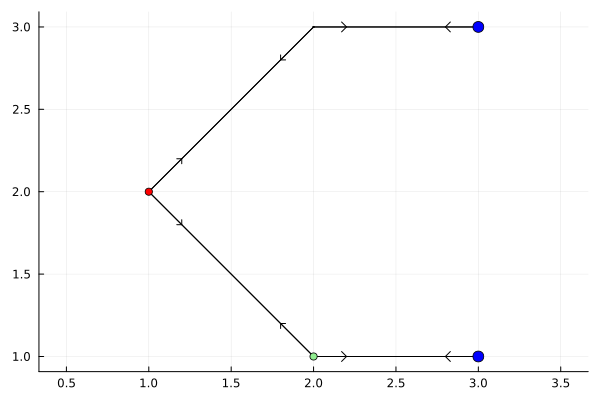

In [491]:
drawEIGgraph(the_eig, width=3)

In [492]:
# compute simple heuristic strategies (shortest path for attacker, stay at stations for defender)
att_heu_strat = makeheuristicattacker(the_eig)
def_heu_strat = makedefstrat_endnodes(the_eig)

# network oracles; reset att_strats and def_strats
att_strats = [att_strat_to_A_half_strat(the_eig.dist_mtx, att_heu_strat, the_eig.speed_A)]
def_strats = [def_heu_strat]

results = @timed EIGSzhang!(the_eig, att_strats, def_strats; AO=attackeroraclenew, DO=defenderoraclenew,
    total_timeout=Inf, silent_solvers=true, printing=0)

time = results.time
results = results.value

Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"


(att_strats = Vector{Any}[[(v = 2, t = 0.0), (v = 4, t = 2.5), (v = 7, t = 4.5), (v = 10, t = 8.5)], [(v = 2, t = 0.0), (v = 6, t = 2.5), (v = 9, t = 8.5), (v = 10, t = 8.75)], [(v = 2, t = 0.0), (v = 6, t = 2.5), (v = 9, t = 4.5), (v = 10, t = 8.75)]], att_probs = [0.5, -0.0, 0.5], def_strats = Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}[[[(v = 4, t_a = 0.0, t_b = 0.0), (v = 7, t_a = 1.0, t_b = 9.0)]], [[(v = 4, t_a = 0.0, t_b = 0.0), (v = 6, t_a = 2.0, t_b = 7.0), (v = 9, t_a = 8.0, t_b = 9.0)]], [[(v = 4, t_a = 0.0, t_b = 5.0), (v = 9, t_a = 8.0, t_b = 9.0)]]], def_probs = [0.5, 0.5, 0.0], obj_core_over_time = Any[1.0, -0.0, 0.5, 1.0, 0.5], obj_DO_over_time = Any[nothing, 1.0, 1.0, nothing, 0.5], obj_AO_over_time = Any[0.0, nothing, 0.5, 0.0, 0.5], coreLP_time_over_time = Any[0.009042794, 0.007390464, 0.005235079, 0.005960073, 0.005752763], DO_time_over_time = Any[nothing, 0.007075212, 0.006663526, nothing, 0.006439936], AO_time_over_time = Any[0.008077747, not

In [493]:
supp_strats = get_support_strats(results)

(att_supp = Any[Any[(v = 2, t = 0.0), (v = 4, t = 2.5), (v = 7, t = 4.5), (v = 10, t = 8.5)], Any[(v = 2, t = 0.0), (v = 6, t = 2.5), (v = 9, t = 4.5), (v = 10, t = 8.75)]], att_supp_probs = Any[0.5, 0.5], def_supp = Any[Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}[[(v = 4, t_a = 0.0, t_b = 0.0), (v = 7, t_a = 1.0, t_b = 9.0)]], Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}[[(v = 4, t_a = 0.0, t_b = 0.0), (v = 6, t_a = 2.0, t_b = 7.0), (v = 9, t_a = 8.0, t_b = 9.0)]]], def_supp_probs = Any[0.5, 0.5])

In [494]:
results.obj_core_over_time

5-element Vector{Any}:
  1.0
 -0.0
  0.5
  1.0
  0.5

In [495]:
counter(map(x -> length(x[1]), supp_strats.def_supp))

Accumulator{Int64, Int64} with 2 entries:
  2 => 1
  3 => 1

In [496]:
counter(map(x -> length(x[1]), results.def_strats))

Accumulator{Int64, Int64} with 2 entries:
  2 => 2
  3 => 1

In [497]:
my_int_mtx = [doesinterdict(att_strat, def_strat) for att_strat in supp_strats.att_supp, def_strat in supp_strats.def_supp]

2×2 Matrix{Bool}:
 1  0
 0  1

In [498]:
get_row_col_dominance(my_int_mtx)

(row_doms = Any[], col_doms = Any[])

In [499]:
supp_strats.att_supp

2-element Vector{Any}:
 Any[(v = 2, t = 0.0), (v = 4, t = 2.5), (v = 7, t = 4.5), (v = 10, t = 8.5)]
 Any[(v = 2, t = 0.0), (v = 6, t = 2.5), (v = 9, t = 4.5), (v = 10, t = 8.75)]

In [500]:
supp_strats.def_supp

2-element Vector{Any}:
 Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}[[(v = 4, t_a = 0.0, t_b = 0.0), (v = 7, t_a = 1.0, t_b = 9.0)]]
 Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}[[(v = 4, t_a = 0.0, t_b = 0.0), (v = 6, t_a = 2.0, t_b = 7.0), (v = 9, t_a = 8.0, t_b = 9.0)]]

[ Info: Saved animation to /mnt/home/pgil0008/EIG/EIG_GIF_EXAMPLE.gif


Plots.AnimatedGif("/mnt/home/pgil0008/EIG/EIG_GIF_EXAMPLE.gif")
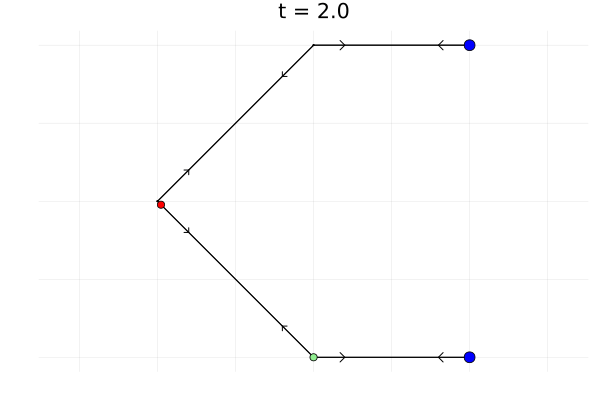

In [469]:
animateEIGPure(the_eig, supp_strats.att_supp[1], supp_strats.def_supp[1], width=3)

### Result analysis

In [43]:
T_MAX_OFFSETS_CS_LIST = [75, 875, 1075, 1675, 2075, 3075]  # list of t_max offsets (centiseconds) used 

6-element Vector{Int64}:
   75
  875
 1075
 1675
 2075
 3075

In [44]:
function grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs=75; use_orig_t_max=false)
    if use_orig_t_max
        return "run_results/size" * string(grid_size) * "_trial" * string(trial) * "_origtmax.json"
    else
        @assert(t_max_offset_cs in T_MAX_OFFSETS_CS_LIST, "t_max_offset_cs must be in $T_MAX_OFFSETS_CS_LIST")
        return "run_results/size" * string(grid_size) * "_trial" * string(trial) * "_tmaxoff" * string(t_max_offset_cs) * ".json"
    end
end

grid_trial_tmax2filename (generic function with 2 methods)

In [45]:
function animate_first_support_strats_in_file(grid_size, trial; t_max_offset_cs=75, use_orig_t_max=true, oracle_num=2, fps=5)
    ### Animate strategy scenario where both player's strategies are in the support

    
    @assert(t_max_offset_cs in T_MAX_OFFSETS_CS_LIST, "t_max_offset_cs must be in $T_MAX_OFFSETS_CS_LIST")
    
    
    ONUM_TO_KEY = ["results_zh", "results_ne"]
    ORACLE_ID_TO_ORACLE = ["Zhang", "network"]
    
    filename = grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs, use_orig_t_max=use_orig_t_max)
    raw_data = JSON.parsefile(filename)  # a dictionary
    the_eig = getEIGfromfile(converttrial2filepath(grid_size, trial), t_max_offset=t_max_offset_cs/100)
    
    att_strats = get_att_strats_from_JSON(filename)
    def_strats = get_def_strats_from_JSON(filename)
    
    conv_flag = raw_data[ONUM_TO_KEY[oracle_num]]["convergence_flag"]
    
    if use_orig_t_max
        println("Loaded grid_size=$grid_size, trial=$trial, orig_tmax(=$(the_eig.t_max)), oracle $(ORACLE_ID_TO_ORACLE[oracle_num])")
    else
        println("Loaded grid_size=$grid_size, trial=$trial, t_max_offset_cs=$t_max_offset_cs, oracle $(ORACLE_ID_TO_ORACLE[oracle_num])")
    end
    
    if conv_flag
        println("Double oracle converged")
    else
        println("Double oracle DID NOT converge")
    end
    
    println("$(length(att_strats)) att strats")
    println("$(length(def_strats)) def strats")
    
    att_strat = att_strats[1]
    def_strat = def_strats[1]
    def_strat_to_t_max(the_eig, def_strat)
    
    display(att_strat)
    display(def_strat)
    
    animateEIGPure(the_eig, att_strat, def_strat, width=grid_size, fps=fps)
end

animate_first_support_strats_in_file (generic function with 1 method)

Loaded grid_size=4, trial=2, t_max_offset_cs=3075, oracle network
Double oracle converged
1 att strats
1 def strats


16-element Vector{@NamedTuple{v::Int64, t::Float64}}:
 (v = 6, t = 0.0)
 (v = 10, t = 3.0)
 (v = 6, t = 4.0)
 (v = 2, t = 6.0)
 (v = 6, t = 9.0)
 (v = 2, t = 11.0)
 (v = 1, t = 12.0)
 (v = 2, t = 15.0)
 (v = 1, t = 16.0)
 (v = 2, t = 19.0)
 (v = 1, t = 20.0)
 (v = 2, t = 23.0)
 (v = 1, t = 24.0)
 (v = 5, t = 27.0)
 (v = 9, t = 36.0)
 (v = 17, t = 39.75)

1-element Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}:
 [(v = 7, t_a = 0.0, t_b = 41.0)]

[ Info: Saved animation to /mnt/home/pgil0008/EIG/EIG_GIF_EXAMPLE.gif


Plots.AnimatedGif("/mnt/home/pgil0008/EIG/EIG_GIF_EXAMPLE.gif")
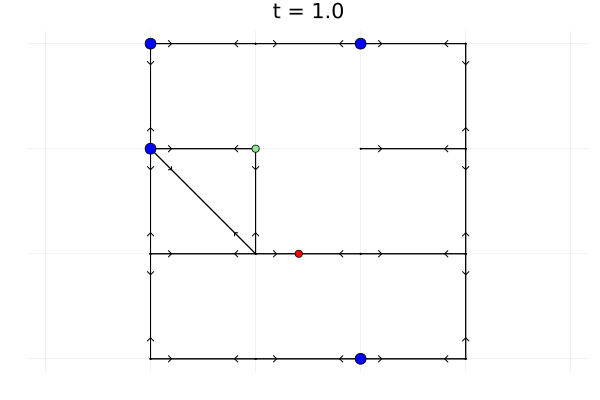

In [58]:
grid_size = 4
trial = 2
t_max_offset_cs = 3075
use_orig_t_max = false
oracle_num = 2  # 1 for Zhang, 2 for network

animate_first_support_strats_in_file(grid_size, trial,
    t_max_offset_cs=t_max_offset_cs, use_orig_t_max=use_orig_t_max, oracle_num=oracle_num,
    fps=10)

In [233]:
function get_def_strats_from_JSON(filename; oracle_num=1, all_strats=false, tol=1e-7)
    """
    Returns a list of all defender strats in the support of the defender strategy given JSON file.
    
    filename: Path to the JSON file to be read
    oracle_num: Either 1 (if Zhang oracle) or 2 (if network oracle)  # could use an enum instead
    all_strats: If true, returns all strateiges, even those not in the support; if false, just returns support strategies
    """
    raw_data = JSON.parsefile(filename)  # a dictionary
    
    ONUM_TO_KEY = ["results_zh", "results_ne"]

    # # for results_zh and results_ne type JSON files
    # def_strats = raw_data[ONUM_TO_KEY[oracle_num]]["def_strats"]
    # def_probs = raw_data[ONUM_TO_KEY[oracle_num]]["def_probs"]

    # for results type JSON files
    def_strats = raw_data["results"]["def_strats"]
    def_probs = raw_data["results"]["def_probs"]

    if all_strats
        # ALL strats (even those not in the support)
        new_def_strats = [[[ (v=state["v"], t_a=state["t_a"], t_b=state["t_b"]) for state in r_sch]
                for r_sch in s]
            for s in def_strats]
    else
        new_def_strats = []
        for s_idx in 1:length(def_strats)
            if tol < def_probs[s_idx]
                # add def_strats[s_idx]
                s = def_strats[s_idx]
                new_strat = [[ (v=state["v"], t_a=state["t_a"], t_b=state["t_b"]) for state in r_sch] for r_sch in s]
                push!(new_def_strats, new_strat)

                println("found support def strat with prob = $(def_probs[s_idx])")
            end
        end
    end
    
    return new_def_strats
end

get_def_strats_from_JSON (generic function with 1 method)

In [234]:
function get_att_strats_from_JSON(filename; oracle_num=1, all_strats=false, tol=1e-7)
    """
    Returns a list of all attacker strats in the support of the attacker strategy in the given JSON file.
    
    filename: Path to the JSON file to be read
    oracle_num: Either 1 (if Zhang oracle) or 2 (if network oracle)  # could use an enum instead
    all_strats: If true, returns all strateiges, even those not in the support; if false, just returns support strategies
    """
    raw_data = JSON.parsefile(filename)  # a dictionary
    
    ONUM_TO_KEY = ["results_zh", "results_ne"]

    # # for results_zh and results_ne type JSON files
    # att_strats = raw_data[ONUM_TO_KEY[oracle_num]]["att_strats"]
    # att_probs = raw_data[ONUM_TO_KEY[oracle_num]]["att_probs"]

    # for results type JSON files
    att_strats = raw_data["results"]["att_strats"]
    att_probs = raw_data["results"]["att_probs"]
    
    if all_strats    
        new_att_strats = [[ (v=state["v"], t=state["t"]) for state in s]
            for s in att_strats]
    else
        new_att_strats = []
        for a_idx in 1:length(att_strats)
            if tol < att_probs[a_idx]
                # add att_strats[a_idx]
                s = att_strats[a_idx]
                new_strat = [ (v=state["v"], t=state["t"]) for state in s]
                push!(new_att_strats, new_strat)

                println("found support att strat with prob = $(att_probs[a_idx])")
            end
        end
    end
    
    return new_att_strats
end

get_att_strats_from_JSON (generic function with 1 method)

In [235]:
constructattackeroraclegraph_SUPPBASED(the_eig)

(new_vs = Any[(2, 6.5, -1), (2, 6.5, 1), (5, 6.5, -1), (5, 6.5, 1), (6, 12.5, -1), (6, 12.5, 1), (9, 24.5, -1), (9, 24.5, 1), (10, 18.5, -1), (10, 18.5, 1)  …  (8, 48.5, -1), (8, 48.5, 1), (12, 52.5, -1), (12, 52.5, 1), (8, 70.5, -1), (8, 70.5, 1), (12, 74.5, -1), (12, 74.5, 1), (1, 0.0, 1), (17, 100.75, -1)], arc_lists_o = Dict{Any, Any}((10, 76.5, 1) => Any[(6, 78.5, -1), (14, 88.5, -1)], (16, 76.5, -1) => [(16, 76.5, 1)], (16, 66.5, 1) => Any[(12, 80.5, -1)], (12, 90.5, -1) => [(12, 90.5, 1)], (8, 94.5, -1) => [(8, 94.5, 1)], (7, 56.5, -1) => [(7, 56.5, 1)], (2, 24.5, -1) => [(2, 24.5, 1)], (10, 80.5, -1) => [(10, 80.5, 1)], (2, 62.5, 1) => Any[(3, 78.5, -1), (6, 68.5, -1)], (10, 74.5, -1) => [(10, 74.5, 1)]…), arc_lists_i = Dict{Any, Any}((10, 76.5, 1) => [(10, 76.5, -1)], (16, 76.5, -1) => Any[(15, 60.5, 1)], (12, 90.5, -1) => Any[(16, 76.5, 1), (8, 86.5, 1)], (8, 94.5, -1) => Any[(4, 82.5, 1), (12, 76.5, 1)], (16, 66.5, 1) => [(16, 66.5, -1)], (7, 56.5, -1) => Any[(3, 42.5, 1), (

In [522]:
grid = 4
trial = 4
t_max_offset_cs = 2075
use_orig_t_max = true

filename_eig = converttrial2filepath(grid, trial)
# filename_res = grid_trial_tmax2filename(grid, trial, t_max_offset_cs, use_orig_t_max=use_orig_t_max)
filename_res = "run_results_CUSTOM/size4_trial" * string(trial) * "_origtmax.json"
filename_res = "run_results_JUST_NETWORK/size" * string(grid) * "_trial" * string(trial) * "_origtmax.json"


att_strats = get_att_strats_from_JSON(filename_res, oracle_num=2, all_strats=false)
def_strats = get_def_strats_from_JSON(filename_res, oracle_num=2, all_strats=false)

the_eig = getEIGfromfile(filename_eig, use_orig_t_max=use_orig_t_max, t_max_offset=t_max_offset_cs / 100)

found support att strat with prob = 1.0
found support def strat with prob = 1.0


EIG(NetworkGraph(17, Edge[Edge(1, 2, 105.0), Edge(1, 5, 105.0), Edge(2, 1, 35.0), Edge(2, 3, 280.0), Edge(2, 6, 105.0), Edge(3, 2, 350.0), Edge(3, 4, 245.0), Edge(3, 6, 140.0), Edge(3, 7, 245.0), Edge(4, 3, 105.0)  …  Edge(15, 11, 280.0), Edge(15, 14, 105.0), Edge(15, 16, 280.0), Edge(16, 12, 245.0), Edge(16, 15, 315.0), Edge(3, 17, 0.0), Edge(4, 17, 0.0), Edge(9, 17, 0.0), Edge(12, 17, 0.0), Edge(17, 17, 0.0)], 6, [8], [3, 4, 9, 12], 17), 1, 280.75, [0.0 105.0 … 1015.0 385.0; 35.0 0.0 … 910.0 280.0; … ; 840.0 805.0 … 0.0 245.0; Inf Inf … Inf 0.0], Vector{Any}[[2, 5], [1, 3, 6], [2, 4, 6, 7, 17], [3, 8, 17], [1, 9], [2, 3, 7, 10], [3, 6], [4, 12], [5, 13, 17], [6, 14], [15], [8, 16, 17], [9, 14], [10, 13, 15], [11, 14, 16], [12, 15], [17]], 5, 7)

In [523]:
@assert(length(att_strats) == 1, "Expecting single winning attacker strategy")

for state in att_strats[1]
    if state.v == the_eig.network.v_∞
        continue
    end
    shortest_travel_time_def = minimum(the_eig.dist_mtx[v_0r, state.v] / the_eig.speed_D for v_0r in the_eig.network.v_0r)
    
    difference = shortest_travel_time_def - state.t
    
    println("For state.v=$(state.v) shortest_travel_time_def=$shortest_travel_time_def, and state.t=$(state.t), diff=$difference")
    if difference <= 0
        println("  !!!!!! shortest_travel_time_def=$shortest_travel_time_def <= state.t=$(state.t)")
    end
end

For state.v=6 shortest_travel_time_def=45.0, and state.t=0.0, diff=45.0
For state.v=2 shortest_travel_time_def=55.0, and state.t=14.5, diff=40.5
For state.v=1 shortest_travel_time_def=60.0, and state.t=21.5, diff=38.5
For state.v=5 shortest_travel_time_def=75.0, and state.t=42.5, diff=32.5
For state.v=9 shortest_travel_time_def=120.0, and state.t=105.5, diff=14.5


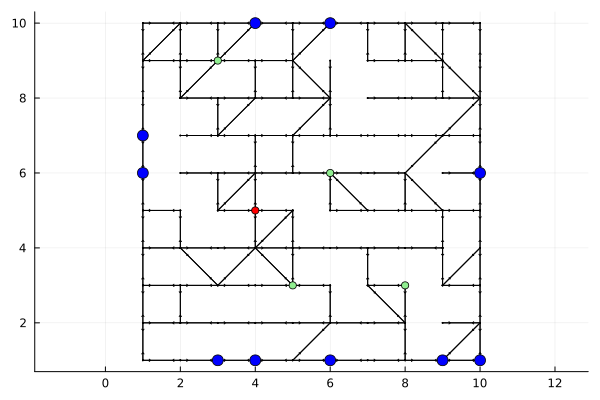

In [274]:
drawEIGgraph(the_eig, width=10)

In [279]:
println("No. att strats: $(length(att_strats)), No. def strats: $(length(def_strats))")

No. att strats: 2, No. def strats: 2


In [512]:
my_int_mtx = [doesinterdict(att_strat, def_strat) for att_strat in att_strats, def_strat in def_strats]

1×1 Matrix{Bool}:
 0

In [281]:
att_strats

2-element Vector{Any}:
 @NamedTuple{v::Int64, t::Float64}[(v = 35, t = 0.0), (v = 45, t = 14.5), (v = 34, t = 17.5), (v = 24, t = 23.5), (v = 14, t = 33.5), (v = 4, t = 39.5), (v = 5, t = 45.5), (v = 6, t = 63.5), (v = 101, t = 72.75)]
 @NamedTuple{v::Int64, t::Float64}[(v = 35, t = 0.0), (v = 45, t = 14.5), (v = 44, t = 16.5), (v = 43, t = 26.5), (v = 53, t = 30.5), (v = 52, t = 40.5), (v = 41, t = 42.5), (v = 51, t = 44.5), (v = 101, t = 72.75)]

In [282]:
def_strats

2-element Vector{Any}:
 Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}[[(v = 29, t_a = 0.0, t_b = 4.0), (v = 6, t_a = 70.0, t_b = 73.0)], [(v = 43, t_a = 0.0, t_b = 5.0), (v = 34, t_a = 14.0, t_b = 21.0), (v = 24, t_a = 30.0, t_b = 73.0)], [(v = 56, t_a = 0.0, t_b = 2.0), (v = 60, t_a = 62.0, t_b = 73.0)], [(v = 73, t_a = 0.0, t_b = 73.0)]]
 Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}[[(v = 29, t_a = 0.0, t_b = 0.0), (v = 6, t_a = 66.0, t_b = 73.0)], [(v = 43, t_a = 0.0, t_b = 19.0), (v = 52, t_a = 40.0, t_b = 73.0)], [(v = 56, t_a = 0.0, t_b = 73.0)], [(v = 73, t_a = 0.0, t_b = 73.0)]]

In [52]:
function get_total_times_and_conv_flag_JSON(filename)
    """
    Returns a named tuple of:
        time_zh,
        time_ne,
        convergence_flag_zh,
        convergence_flag_ne,

    from the given filename.
    
    filename: Path to the JSON file to be read
    """
    raw_data = JSON.parsefile(filename)  # a dictionary
    
    return (
        time_zh=raw_data["time_zh"],
        time_ne=raw_data["time_ne"],
        convergence_flag_zh=raw_data["results_zh"]["convergence_flag"],
        convergence_flag_ne=raw_data["results_ne"]["convergence_flag"],
    )
end

get_total_times_and_conv_flag_JSON (generic function with 1 method)

In [59]:
t_max_offset_cs = 3075

for grid in 3:10
    for trial in 1:10
        if grid == 6 && trial == 1
            continue
        end
        filename = grid_trial_tmax2filename(grid, trial, t_max_offset_cs, use_orig_t_max=false)
        # filename = grid_trial_tmax2filename(grid, trial, t_max_offset_cs, use_orig_t_max=false)
        def_strats = get_def_strats_from_JSON(filename, oracle_num=2, all_strats=false)
        def_sup_size = length(def_strats)
        att_strats = get_att_strats_from_JSON(filename, oracle_num=2, all_strats=false)
        att_sup_size = length(att_strats)
        
        ONUM_TO_KEY = ["results_zh", "results_ne"]
        
        raw_data = JSON.parsefile(filename)  # a dictionary
        conv_flag = raw_data[ONUM_TO_KEY[2]]["convergence_flag"]

        if conv_flag
            println("grid_size $grid trial $trial has defender support size $def_sup_size and att size $att_sup_size")
        end
    end
end

grid_size 3 trial 1 has defender support size 1 and att size 1
grid_size 3 trial 2 has defender support size 1 and att size 1
grid_size 3 trial 3 has defender support size 1 and att size 1
grid_size 3 trial 4 has defender support size 1 and att size 1
grid_size 3 trial 5 has defender support size 1 and att size 1
grid_size 3 trial 6 has defender support size 1 and att size 1
grid_size 3 trial 7 has defender support size 1 and att size 1
grid_size 3 trial 8 has defender support size 1 and att size 1
grid_size 3 trial 9 has defender support size 1 and att size 1
grid_size 3 trial 10 has defender support size 1 and att size 1
grid_size 4 trial 1 has defender support size 1 and att size 1
grid_size 4 trial 2 has defender support size 1 and att size 1
grid_size 4 trial 3 has defender support size 1 and att size 1
grid_size 4 trial 4 has defender support size 1 and att size 1
grid_size 4 trial 5 has defender support size 1 and att size 1
grid_size 4 trial 6 has defender support size 1 and at

### Result Plotting

A plot of `grid_size` vs time for each `time_max` offset (0.75, 8.75, 16.75) from `dist[v_0, v_∞]`.
Include table data in Appendix.

**Red** - Zhang oracles;
**Blue** - New network oracles

In [48]:
function scatter_plot_gs_vs_times(t_max_offset_cs; x_coor_offset=0.1, timeout=300)
    """
    t_max_offset_cs: offset from dist[v_0, v_∞] in centiseconds for the datafile (must be in [75, 875, 1075, 1675, 2075, 3075])
    x_coor_offset: distance from line x = grid_size to plot points (zhang on lines x = grid_size - x_coor_offset, network on lines x = grid_size + x_coor_offset) 
    """
    @assert(t_max_offset_cs in T_MAX_OFFSETS_CS_LIST, "t_max_offset_cs must be in $T_MAX_OFFSETS_CS_LIST")
    
    grid_sizes_zh = []  # 1D array with entries the grid sizes for each grid_size-trial pair where Zhang converges in time; will be 'x-coor' in plots
    times_zh = []  # 1D array with entries the runtimes for each grid_size-trial pair where Zhang converges in time; will be 'y-coor' in plots
    grid_sizes_ne = []  # 1D array with entries the grid sizes for each grid_size-trial pair where network oracle converges in time; will be 'x-coor' in plots
    times_ne = []  # 1D array with entries the runtimes for each grid_size-trial pair where network oracle converges in time; will be 'y-coor' in plots

    grid_sizes_zh_noc = []  # 1D array with entries the grid sizes for each grid_size-trial pair where Zhang NOT converges in time; will be 'x-coor' in plots
    times_zh_noc = []  # 1D array with entries the runtimes for each grid_size-trial pair where Zhang NOT converges in time; will be 'y-coor' in plots
    grid_sizes_ne_noc = []  # 1D array with entries the grid sizes for each grid_size-trial pair where network oracle NOT converges in time; will be 'x-coor' in plots
    times_ne_noc = []  # 1D array with entries the runtimes for each grid_size-trial pair where network oracle NOT converges in time; will be 'y-coor' in plots
    
    for grid_size in 3:10
        for trial in 1:10
            filename = grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs)
            results = get_total_times_and_conv_flag_JSON(filename)

            if results.convergence_flag_zh
                push!(grid_sizes_zh, grid_size)  # add to Zhang converging data points
                push!(times_zh, results.time_zh)
            else
                push!(grid_sizes_zh_noc, grid_size)  # add to Zhang NOT converging data points
                push!(times_zh_noc, results.time_zh)
            end

            if results.convergence_flag_ne
                push!(grid_sizes_ne, grid_size)  # add to network oracle converging data points
                push!(times_ne, results.time_ne)
            else
                push!(grid_sizes_ne_noc, grid_size)  # add to network oracle NOT converging data points
                push!(times_ne_noc, results.time_ne)
            end
        end
    end
    
    # offset zhang and network oracle x-coors to
    grid_sizes_zh .-= x_coor_offset
    grid_sizes_ne .+= x_coor_offset
    grid_sizes_zh_noc .-= x_coor_offset
    grid_sizes_ne_noc .+= x_coor_offset

    # timeout = t_max_offset_cs == 1675 ? 600 : 60  # CHANGE
    # timeout = 300

    # clamp overtimes
    times_zh_noc = [x > timeout ? timeout + 2*i : x for (i, x) in enumerate(times_zh_noc)]
    times_ne_noc = [x > timeout ? timeout + 2*i : x for (i, x) in enumerate(times_ne_noc)]
    
    # plot([3, 10], [timeout, timeout], yscale=:log10, color="0xCCCCCC", linestyle=:dash, label="")  # horizontal line showing timeout; log scale for time
    plot([3, 10], [timeout, timeout], color="0xCCCCCC", linestyle=:dash, label="")#, xaxis="grid size")  # horizontal line showing timeout

    scatter!(grid_sizes_zh, times_zh, markershape=:x, mc="0xFF0000", label="Zhang MILP")  # Zhang converging, saturated red
    scatter!(grid_sizes_ne, times_ne, markershape=:x, mc="0x0000FF", label="Network")  # network converging, saturated blue
    scatter!(grid_sizes_zh_noc, times_zh_noc, markershape=:o, mc="0xFFAAAA", label="Zhang MILP (nc)")  # Zhang converging, unsaturated red
    scatter!(grid_sizes_ne_noc, times_ne_noc, markershape=:o, mc="0xAAAAFF", label="Network (nc)")  # network converging, unsaturated blue
    title!("Grid size vs Runtime, t_max_offset=" * string(t_max_offset_cs / 100))
end

scatter_plot_gs_vs_times (generic function with 1 method)

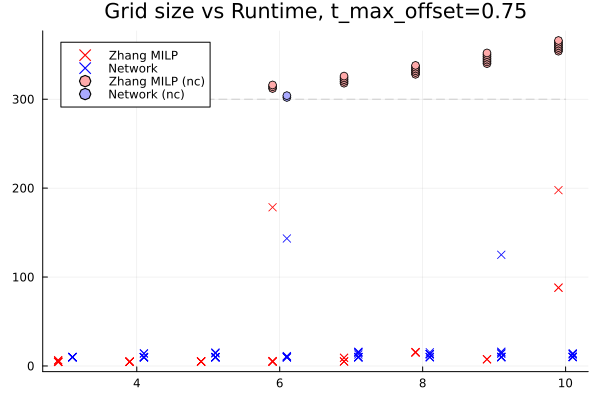

In [49]:
scatter_plot_gs_vs_times(75)

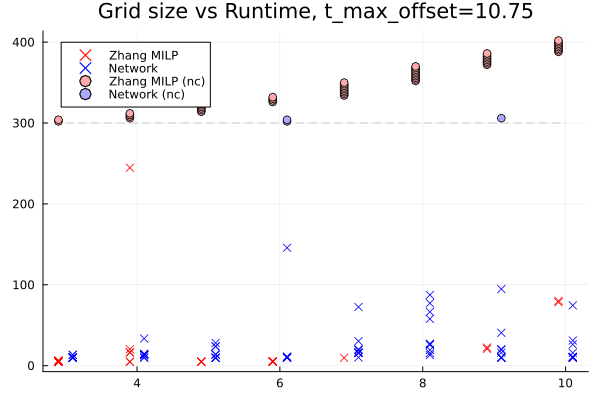

In [50]:
scatter_plot_gs_vs_times(1075)

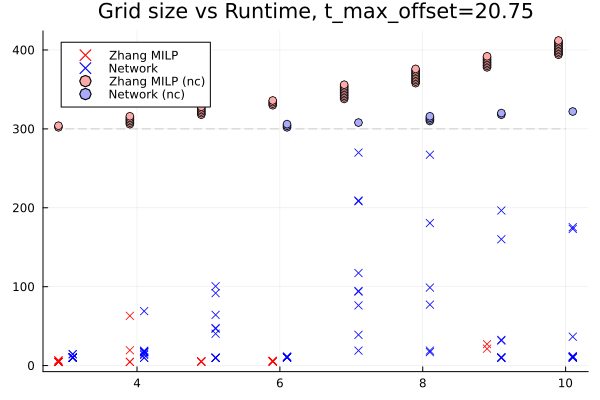

In [51]:
scatter_plot_gs_vs_times(2075)

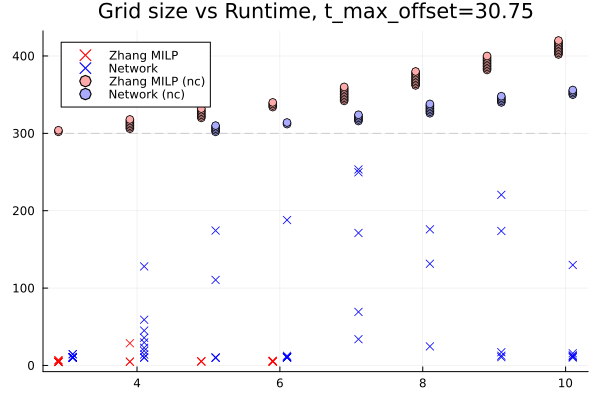

In [52]:
scatter_plot_gs_vs_times(3075)

In [175]:
num_ne_nocs_t_max = [-1 for _ in T_MAX_OFFSETS_CS_LIST]  # entry t contains number of non-convergent sequences for network oracles
num_zh_nocs_t_max = [-1 for _ in T_MAX_OFFSETS_CS_LIST]  # entry t contains number of non-convergent sequences for Zhang oracles

for t_max_offset_cs_idx in 1:length(T_MAX_OFFSETS_CS_LIST)
    t_max_offset_cs = T_MAX_OFFSETS_CS_LIST[t_max_offset_cs_idx]
    
    grid_sizes_zh = []  # 1D array with entries the grid sizes for each grid_size-trial pair where Zhang converges in time; will be 'x-coor' in plots
    times_zh = []  # 1D array with entries the runtimes for each grid_size-trial pair where Zhang converges in time; will be 'y-coor' in plots
    grid_sizes_ne = []  # 1D array with entries the grid sizes for each grid_size-trial pair where network oracle converges in time; will be 'x-coor' in plots
    times_ne = []  # 1D array with entries the runtimes for each grid_size-trial pair where network oracle converges in time; will be 'y-coor' in plots
    
    grid_sizes_zh_noc = []  # 1D array with entries the grid sizes for each grid_size-trial pair where Zhang NOT converges in time; will be 'x-coor' in plots
    times_zh_noc = []  # 1D array with entries the runtimes for each grid_size-trial pair where Zhang NOT converges in time; will be 'y-coor' in plots
    grid_sizes_ne_noc = []  # 1D array with entries the grid sizes for each grid_size-trial pair where network oracle NOT converges in time; will be 'x-coor' in plots
    times_ne_noc = []  # 1D array with entries the runtimes for each grid_size-trial pair where network oracle NOT converges in time; will be 'y-coor' in plots
    
    for grid_size in 3:10
        for trial in 1:10
            filename = grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs)
            results = get_total_times_and_conv_flag_JSON(filename)
    
            if results.convergence_flag_zh
                push!(grid_sizes_zh, grid_size)  # add to Zhang converging data points
                push!(times_zh, results.time_zh)
            else
                push!(grid_sizes_zh_noc, grid_size)  # add to Zhang NOT converging data points
                push!(times_zh_noc, results.time_zh)
            end
    
            if results.convergence_flag_ne
                push!(grid_sizes_ne, grid_size)  # add to network oracle converging data points
                push!(times_ne, results.time_ne)
            else
                push!(grid_sizes_ne_noc, grid_size)  # add to network oracle NOT converging data points
                push!(times_ne_noc, results.time_ne)
            end
        end
    end

    num_ne_nocs_t_max[t_max_offset_cs_idx] = length(grid_sizes_ne_noc)
    num_zh_nocs_t_max[t_max_offset_cs_idx] = length(grid_sizes_zh_noc)
end

In [69]:
num_ne_nocs_t_max

6-element Vector{Int64}:
  2
  1
  3
  1
 11
 28

In [70]:
num_zh_nocs_t_max

6-element Vector{Int64}:
 33
 38
 51
 50
 56
 60

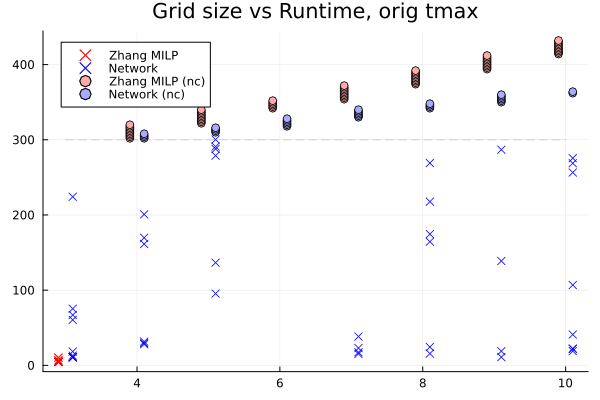

In [29]:
x_coor_offset=0.1
timeout=300

grid_sizes_zh = []  # 1D array with entries the grid sizes for each grid_size-trial pair where Zhang converges in time; will be 'x-coor' in plots
times_zh = []  # 1D array with entries the runtimes for each grid_size-trial pair where Zhang converges in time; will be 'y-coor' in plots
grid_sizes_ne = []  # 1D array with entries the grid sizes for each grid_size-trial pair where network oracle converges in time; will be 'x-coor' in plots
times_ne = []  # 1D array with entries the runtimes for each grid_size-trial pair where network oracle converges in time; will be 'y-coor' in plots

grid_sizes_zh_noc = []  # 1D array with entries the grid sizes for each grid_size-trial pair where Zhang NOT converges in time; will be 'x-coor' in plots
times_zh_noc = []  # 1D array with entries the runtimes for each grid_size-trial pair where Zhang NOT converges in time; will be 'y-coor' in plots
grid_sizes_ne_noc = []  # 1D array with entries the grid sizes for each grid_size-trial pair where network oracle NOT converges in time; will be 'x-coor' in plots
times_ne_noc = []  # 1D array with entries the runtimes for each grid_size-trial pair where network oracle NOT converges in time; will be 'y-coor' in plots

for grid_size in 3:10
    for trial in 1:10
        if grid_size == 6 && trial >= 7
            continue  # skipped run
        end
    
        filename = "run_results/size" * string(grid_size) * "_trial" * string(trial) * "_origtmax.json"
        results = get_total_times_and_conv_flag_JSON(filename)

        if results.convergence_flag_zh
            push!(grid_sizes_zh, grid_size)  # add to Zhang converging data points
            push!(times_zh, results.time_zh)
        else
            push!(grid_sizes_zh_noc, grid_size)  # add to Zhang NOT converging data points
            push!(times_zh_noc, results.time_zh)
        end

        if results.convergence_flag_ne
            push!(grid_sizes_ne, grid_size)  # add to network oracle converging data points
            push!(times_ne, results.time_ne)
        else
            push!(grid_sizes_ne_noc, grid_size)  # add to network oracle NOT converging data points
            push!(times_ne_noc, results.time_ne)
        end
    end
end

# offset zhang and network oracle x-coors to
grid_sizes_zh .-= x_coor_offset
grid_sizes_ne .+= x_coor_offset
grid_sizes_zh_noc .-= x_coor_offset
grid_sizes_ne_noc .+= x_coor_offset

# timeout = t_max_offset_cs == 1675 ? 600 : 60  # CHANGE
# timeout = 300

# clamp overtimes
times_zh_noc = [x > timeout ? timeout + 2*i : x for (i, x) in enumerate(times_zh_noc)]
times_ne_noc = [x > timeout ? timeout + 2*i : x for (i, x) in enumerate(times_ne_noc)]

# plot([3, 10], [timeout, timeout], yscale=:log10, color="0xCCCCCC", linestyle=:dash, label="")  # horizontal line showing timeout; log scale for time
plot([3, 10], [timeout, timeout], color="0xCCCCCC", linestyle=:dash, label="")#, xaxis="grid size")  # horizontal line showing timeout

scatter!(grid_sizes_zh, times_zh, markershape=:x, mc="0xFF0000", label="Zhang MILP")  # Zhang converging, saturated red
scatter!(grid_sizes_ne, times_ne, markershape=:x, mc="0x0000FF", label="Network")  # network converging, saturated blue
scatter!(grid_sizes_zh_noc, times_zh_noc, markershape=:o, mc="0xFFAAAA", label="Zhang MILP (nc)")  # Zhang converging, unsaturated red
scatter!(grid_sizes_ne_noc, times_ne_noc, markershape=:o, mc="0xAAAAFF", label="Network (nc)")  # network converging, unsaturated blue
title!("Grid size vs Runtime, orig tmax")

In [91]:
results = do_run_of_trial(6, 7,
                total_timeout_zh=60, total_timeout_ne=60,
                A_timeout_zh=nothing, A_timeout_ne=nothing,
                D_timeout_zh=nothing, D_timeout_ne=nothing, printing=false, silent_solvers=true, t_max_offset=40 + 0.75, use_orig_t_max=false)


!!!!!!!! STARTING grid_size=6 and trial_num=7
!!!!!! STARTING NETWORK DOUBLE ORACLE
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 59.994758108 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"
!!!!!! STARTING ZHANG DOUBLE ORACLE
Set parameter TokenServer to value "118.138.243.190"
the A_timeout_ is 59.996534219 (set)
Set parameter TokenServer to value "118.138.243.190"
Set parameter TokenServer to value "118.138.243.190"


(time_zh = 0.742361229, results_zh = (att_strats = Vector{Any}[[(v = 14, t = 0.0), (v = 8, t = 2400.0), (v = 2, t = 6500.0), (v = 3, t = 7900.0), (v = 37, t = 7940.75)]], att_probs = [1.0], def_strats = Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}[[[(v = 16, t_a = 0.0, t_b = 0.0), (v = 3, t_a = 5301.0, t_b = 7941.0)]]], def_probs = [1.0], obj_core_over_time = Any[1.0], obj_DO_over_time = Any[nothing], obj_AO_over_time = Any[1.0], coreLP_time_over_time = Any[0.003464238], DO_time_over_time = Any[nothing], AO_time_over_time = Any[0.73083803], convergence_flag = true, time_graph_att_constr = nothing, time_graph_def_constr = nothing), time_ne = 2.267569899, results_ne = (att_strats = Vector{Any}[[(v = 14, t = 0.0), (v = 8, t = 2400.5), (v = 2, t = 6500.5), (v = 3, t = 7900.5), (v = 37, t = 7940.5)]], att_probs = [1.0], def_strats = Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}[[[(v = 16, t_a = 0.0, t_b = 0.0), (v = 3, t_a = 5301.0, t_b = 7941.0)]]],

In [94]:
results.results_ne.att_strats[1]

5-element Vector{Any}:
 (v = 14, t = 0.0)
 (v = 8, t = 2400.5)
 (v = 2, t = 6500.5)
 (v = 3, t = 7900.5)
 (v = 37, t = 7940.5)

In [99]:
results.results_ne.def_strats[1]

1-element Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}:
 [(v = 16, t_a = 0.0, t_b = 0.0), (v = 3, t_a = 5301.0, t_b = 7941.0)]

[ Info: Saved animation to /mnt/home/pgil0008/EIG/tutorial_anim_fps30.gif


Plots.AnimatedGif("/mnt/home/pgil0008/EIG/tutorial_anim_fps30.gif")
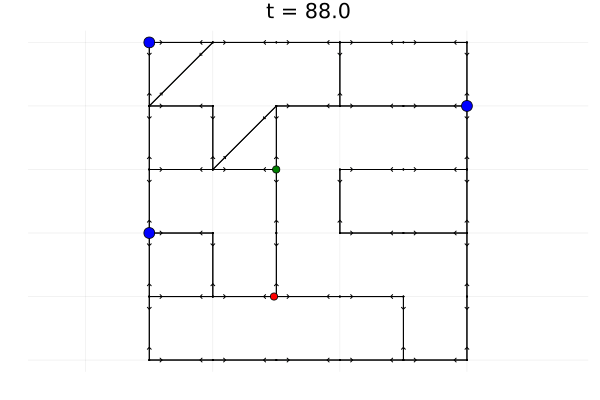

In [96]:
animateEIGPure(the_eig, results.results_ne.att_strats[1], results.results_ne.def_strats[1], width=6)

In [58]:
for t_max_offset_cs in T_MAX_OFFSETS_CS_LIST
    println("!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: $t_max_offset_cs")
    for grid_size in 3:10
        println(" grid_size: $grid_size")
        for trial in 1:10
            # println("  trial: $trial")
            results = get_total_times_and_conv_flag_JSON(grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs))

            # display(results.convergence_flag_zh)
            
            if !results.convergence_flag_zh && !results.convergence_flag_ne
                println("  trial $trial has both oracles nc")
                # display(results)
            end

            if results.convergence_flag_zh && !results.convergence_flag_ne
                println("  trial $trial has network nc but zhang c !!!!!!!!!!!!!")
                # display(results)
            end

            if !results.convergence_flag_zh && results.convergence_flag_ne
                println("  trial $trial has zhang nc but network c !!!!!!!!!!!!!")
                # display(results)
            end
            
            display(results)
        end
    end
end

!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: 75
 grid_size: 3


(time_zh = 4.850696478, time_ne = 10.259223706, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.607815008, time_ne = 9.760102898, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.684978011, time_ne = 9.960754458, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.685537484, time_ne = 9.957057915, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.809373085, time_ne = 9.955475058, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.390170171, time_ne = 9.807618971, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.677680624, time_ne = 9.759055377, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.681035525, time_ne = 9.992715322, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.51688117, time_ne = 9.933597884, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.569069142, time_ne = 10.133229897, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4


(time_zh = 4.861082375, time_ne = 10.038712859, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.716853053, time_ne = 9.704276321, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.785006237, time_ne = 10.000205201, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.872903894, time_ne = 10.113751625, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.886990232, time_ne = 9.967248745, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.829042834, time_ne = 9.948103471, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.645067986, time_ne = 9.739939518, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.630561897, time_ne = 13.80578838, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.873416238, time_ne = 14.373351176, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.604625031, time_ne = 9.671209707, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 5


(time_zh = 4.787452781, time_ne = 9.718055432, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.780437586, time_ne = 9.505390783, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.106069293, time_ne = 9.934778125, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.097370409, time_ne = 10.092205763, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.130311127, time_ne = 10.12269553, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 302.117639461, time_ne = 14.610900535, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.880484165, time_ne = 14.121680428, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.242224431, time_ne = 15.198590928, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.089712503, time_ne = 9.974574611, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.039240095, time_ne = 9.77978426, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 6


(time_zh = 5.603601768, time_ne = 9.677767494, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.843116325, time_ne = 9.630643716, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 178.479371102, time_ne = 10.94256228, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.954912526, time_ne = 9.894073131, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.943587823, time_ne = 9.959678188, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 310.769856473, time_ne = 143.364438672, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.106671009, time_ne = 11.156424113, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.027255527, time_ne = 10.068698013, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 9 has both oracles nc


(time_zh = 311.460305204, time_ne = 1453.082352508, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 10 has both oracles nc


(time_zh = 314.872882763, time_ne = 565.615444754, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 7


(time_zh = 321.379245981, time_ne = 15.487734564, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.077129997, time_ne = 9.701822592, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.144319705, time_ne = 9.800803305, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.106523943, time_ne = 9.634573184, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 303.909061554, time_ne = 12.861999669, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 316.047576577, time_ne = 15.314313719, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 348.553476566, time_ne = 16.079497745, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 326.380609275, time_ne = 14.559488607, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 9.062015024, time_ne = 9.897768877, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 9.294251912, time_ne = 10.262002088, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 8


(time_zh = 351.812824272, time_ne = 15.440650302, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 309.220058364, time_ne = 13.335702131, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 365.314897512, time_ne = 13.150520945, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 358.376191425, time_ne = 13.667164396, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 362.656919419, time_ne = 13.310088824, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 309.720731871, time_ne = 13.286022719, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 15.743440246, time_ne = 10.355388408, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 15.272290638, time_ne = 9.852443166, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 15.320481981, time_ne = 9.878473234, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 15.063860969, time_ne = 9.921234859, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 9


(time_zh = 550.40842011, time_ne = 13.741077168, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 385.907525654, time_ne = 9.94402933, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 379.174697774, time_ne = 9.712737726, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 399.102506699, time_ne = 14.265342383, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 7.536649647, time_ne = 10.253734163, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 7.611325058, time_ne = 10.324056565, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 7.582155885, time_ne = 10.093801705, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 518.813190328, time_ne = 125.051234054, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 428.939734581, time_ne = 15.378121066, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 305.901899014, time_ne = 16.130433384, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 10


(time_zh = 197.719153676, time_ne = 10.028407012, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 1176.769292651, time_ne = 10.231562325, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 646.43094106, time_ne = 10.074153784, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 609.952102304, time_ne = 13.330465099, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 678.279045954, time_ne = 12.947865588, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 613.420538614, time_ne = 13.502568765, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 671.989975571, time_ne = 14.342297011, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 642.581011845, time_ne = 10.195862785, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 88.169071104, time_ne = 10.204398332, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 87.962655561, time_ne = 10.127834184, convergence_flag_zh = true, convergence_flag_ne = true)

!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: 875
 grid_size: 3


(time_zh = 4.465960149, time_ne = 10.01456534, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.028354656, time_ne = 0.065863563, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.029012263, time_ne = 0.059699396, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.824270642, time_ne = 2.884859008, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.20814098, time_ne = 0.078963109, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.153178295, time_ne = 0.015035988, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.025614892, time_ne = 0.043826635, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.025327039, time_ne = 0.037839059, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.022078949, time_ne = 0.043977989, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.045617333, time_ne = 0.013313488, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4


(time_zh = 0.945860961, time_ne = 0.053871471, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.058289034, time_ne = 0.023625679, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.124872571, time_ne = 0.023059013, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.057711747, time_ne = 0.022737688, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.058074229, time_ne = 0.025851937, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 8.692969023, time_ne = 0.050445917, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.074301728, time_ne = 0.033488755, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.185409704, time_ne = 0.030970767, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.209860465, time_ne = 0.033543904, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 0.070666672, time_ne = 0.043045031, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 5


(time_zh = 0.633141147, time_ne = 0.047443407, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.633650215, time_ne = 0.048117877, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.775205317, time_ne = 0.046012183, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.311771248, time_ne = 0.043515095, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.338338676, time_ne = 0.047039146, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 301.073745834, time_ne = 0.402792358, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.035034865, time_ne = 0.042956625, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.725802161, time_ne = 0.102576026, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 0.326447867, time_ne = 0.051343911, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.473808506, time_ne = 0.054463823, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 6


(time_zh = 1.806311137, time_ne = 1.436167613, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.590133543, time_ne = 0.361296336, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 305.034687372, time_ne = 25.431904849, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1.928315946, time_ne = 0.516607844, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.641298036, time_ne = 0.450906664, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 311.138730084, time_ne = 55.131167899, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1.533913203, time_ne = 1.534226313, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 1.816472202, time_ne = 1.682176505, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 9 has both oracles nc


(time_zh = 308.25840174, time_ne = 1750.231484443, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 311.447878505, time_ne = 185.545817855, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 7


(time_zh = 324.179216123, time_ne = 0.671047408, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1.068671759, time_ne = 0.02935352, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 1.800977619, time_ne = 0.028945332, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 2.630489802, time_ne = 0.035476765, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 306.778184085, time_ne = 0.093674977, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 313.657513495, time_ne = 0.17162369, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 341.610147432, time_ne = 0.228852618, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 308.002311881, time_ne = 0.597765296, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.87030878, time_ne = 0.04846679, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.788229634, time_ne = 0.057607932, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 8


(time_zh = 322.48169655, time_ne = 2.606116634, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 361.102795702, time_ne = 0.481701112, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 356.058249655, time_ne = 0.118787546, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 356.86752125, time_ne = 0.130913336, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 372.929059085, time_ne = 0.02844422, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 359.116380198, time_ne = 0.046489017, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 323.425407113, time_ne = 0.210332335, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 406.240655997, time_ne = 2.277609205, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 398.74744531, time_ne = 3.30270111, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 15.293359894, time_ne = 0.073553333, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 9


(time_zh = 455.090255377, time_ne = 0.095038176, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 380.26297739, time_ne = 0.026023334, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 383.27501605, time_ne = 0.035824359, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 387.894717835, time_ne = 0.123840397, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 15.571069003, time_ne = 0.050378308, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 17.277797367, time_ne = 0.055036263, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 13.791897539, time_ne = 0.055726543, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 501.686704404, time_ne = 11.203213424, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 460.148634453, time_ne = 21.235109192, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 375.188358901, time_ne = 8.991005284, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 10


(time_zh = 301.014202971, time_ne = 0.105035786, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1373.975748334, time_ne = 0.169067142, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 699.253727001, time_ne = 0.098537027, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 700.310367005, time_ne = 0.195900911, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 696.063403797, time_ne = 0.195367657, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 630.458622854, time_ne = 0.349027975, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 653.80929521, time_ne = 0.112462321, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 674.179825849, time_ne = 0.055362471, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 69.680493548, time_ne = 0.076153307, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 59.01005492, time_ne = 0.066155492, convergence_flag_zh = true, convergence_flag_ne = true)

!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: 1075
 grid_size: 3


(time_zh = 5.036816849, time_ne = 10.332293758, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.841924234, time_ne = 10.417114569, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.699264702, time_ne = 9.923439502, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.743766341, time_ne = 13.464080068, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.830508129, time_ne = 13.499838187, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 6.446862832, time_ne = 10.035644286, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.750931385, time_ne = 9.953868985, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.599237406, time_ne = 9.758781402, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.618658522, time_ne = 9.895721844, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.361747979, time_ne = 9.683254566, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4


(time_zh = 20.295297123, time_ne = 12.857926607, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 16.591993432, time_ne = 13.229163104, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 244.708761663, time_ne = 13.297961502, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.663597929, time_ne = 9.768035677, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.91841554, time_ne = 10.149313423, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 16.1737921, time_ne = 13.0447875, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.807453562, time_ne = 33.550024888, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.819712056, time_ne = 14.516821728, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.940577763, time_ne = 14.526525363, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.261956372, time_ne = 14.31368096, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 5


(time_zh = 301.216015015, time_ne = 13.868845101, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.216519258, time_ne = 13.829480857, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.766704947, time_ne = 13.741847841, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.041743635, time_ne = 9.767540565, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.077659442, time_ne = 10.030250349, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 301.165155874, time_ne = 23.646300143, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.152288019, time_ne = 24.015673147, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 302.742664697, time_ne = 28.096113501, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.896301568, time_ne = 9.587192447, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.851752571, time_ne = 9.719413759, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 6


(time_zh = 5.735013794, time_ne = 9.932077632, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.179646971, time_ne = 10.032225686, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 311.1101855, time_ne = 11.176875697, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.970105722, time_ne = 9.871461548, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.92572207, time_ne = 9.877875373, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 301.954470888, time_ne = 145.803449161, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.941581225, time_ne = 10.96817154, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.316411032, time_ne = 10.172497992, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 9 has both oracles nc


(time_zh = 312.226735334, time_ne = 1511.574583035, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 10 has both oracles nc


(time_zh = 308.950786903, time_ne = 503.725168231, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 7


(time_zh = 320.406484635, time_ne = 72.573309472, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 353.886326333, time_ne = 19.610092554, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 350.363298399, time_ne = 19.565524331, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 326.802329192, time_ne = 15.679257969, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 307.24139835, time_ne = 20.227094952, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 314.675343153, time_ne = 16.228810506, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 349.23932257, time_ne = 16.587876636, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 329.65120094, time_ne = 30.313243574, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 348.618606855, time_ne = 15.780857795, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 9.623372837, time_ne = 10.202791504, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 8


(time_zh = 364.971218413, time_ne = 57.844115488, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 365.049613177, time_ne = 25.758953303, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 378.438891781, time_ne = 19.410945629, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 375.147801062, time_ne = 27.202697704, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 367.89218043, time_ne = 15.473413485, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 359.130320227, time_ne = 13.134965259, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 333.455392914, time_ne = 26.560368848, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 412.266948677, time_ne = 87.428879195, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 418.847722264, time_ne = 77.234582059, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 338.42175379, time_ne = 66.536266179, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 9


(time_zh = 545.745892988, time_ne = 20.502643391, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 387.65732182, time_ne = 9.805139185, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 384.284831499, time_ne = 9.735568746, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 427.629193863, time_ne = 19.455290044, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 463.892094373, time_ne = 16.046131437, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 22.440536627, time_ne = 10.087999788, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 20.755013088, time_ne = 10.254955992, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 8 has both oracles nc


(time_zh = 513.503235523, time_ne = 419.052882812, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 563.665931251, time_ne = 94.774132358, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 387.012446317, time_ne = 40.66394852, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 10


(time_zh = 305.782384905, time_ne = 9.906424502, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1210.28173436, time_ne = 11.163638112, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 663.347533614, time_ne = 10.139350148, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 688.00407081, time_ne = 31.114101134, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 676.849533306, time_ne = 26.364874324, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 646.290234472, time_ne = 74.494220253, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 564.184022629, time_ne = 15.917492274, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 612.054343618, time_ne = 10.302531605, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 80.13626651, time_ne = 10.266607721, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 78.47614293, time_ne = 9.770313666, convergence_flag_zh = true, convergence_flag_ne = true)

!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: 1675
 grid_size: 3


(time_zh = 4.517357318, time_ne = 9.848709884, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.088566479, time_ne = 0.19690082, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.039243034, time_ne = 0.197772331, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.21459484, time_ne = 4.449289415, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.069200897, time_ne = 1.117707478, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 0.067582407, time_ne = 0.024144158, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.031379615, time_ne = 0.264892309, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.031665293, time_ne = 0.217759296, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.030460356, time_ne = 0.179318722, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.070100355, time_ne = 0.019330089, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4


(time_zh = 1.902203023, time_ne = 0.195884769, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.074632185, time_ne = 0.105482364, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.075310433, time_ne = 0.064510536, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.074393866, time_ne = 0.146148717, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.073891161, time_ne = 0.063526105, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 7.298466288, time_ne = 0.211226923, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.165463141, time_ne = 0.158444197, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.172220027, time_ne = 0.041753538, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.187434105, time_ne = 0.033793879, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.195328162, time_ne = 0.139528784, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 5


(time_zh = 303.184185831, time_ne = 15.708078528, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.414112128, time_ne = 15.097260857, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 302.206532566, time_ne = 14.820445447, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 0.568180869, time_ne = 0.098878273, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.453364532, time_ne = 0.093480323, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.732551763, time_ne = 1.050754189, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.30427551, time_ne = 0.086126495, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.57533826, time_ne = 0.084279328, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 0.374710237, time_ne = 0.094025329, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.383429536, time_ne = 0.262518721, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 6


(time_zh = 1.701836679, time_ne = 1.524232954, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.515732811, time_ne = 0.371129248, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 185.518975346, time_ne = 25.023646885, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 1.478324867, time_ne = 0.634870769, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 0.56798745, time_ne = 0.488931032, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 311.376053604, time_ne = 66.987883178, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1.766722761, time_ne = 1.902940893, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 1.763468397, time_ne = 1.660398997, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 9 has both oracles nc


(time_zh = 309.576646168, time_ne = 1733.01019293, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 311.09188116, time_ne = 172.196900766, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 7


(time_zh = 364.318815943, time_ne = 1.235170346, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 310.257654837, time_ne = 1.321216698, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 320.60901173, time_ne = 2.128404558, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 313.236040436, time_ne = 0.119287354, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 307.427661334, time_ne = 0.234935863, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.016004381, time_ne = 0.313265446, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 349.129860178, time_ne = 0.764077359, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.535293749, time_ne = 0.242894422, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 344.231097543, time_ne = 0.289603797, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 345.015223915, time_ne = 0.551668512, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 8


(time_zh = 318.620976472, time_ne = 20.730036022, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 328.719818022, time_ne = 4.681903647, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 367.552033086, time_ne = 0.246806, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 359.788683006, time_ne = 0.232926634, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 352.343195334, time_ne = 0.046990398, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 368.641170738, time_ne = 0.072518677, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 335.123693877, time_ne = 3.456532611, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 351.044362864, time_ne = 26.794649403, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 353.178839495, time_ne = 32.991987265, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 329.230300878, time_ne = 10.715666761, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 9


(time_zh = 505.079534805, time_ne = 0.155602537, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 383.035348757, time_ne = 0.034328424, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 382.305906343, time_ne = 0.047112591, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 459.578653169, time_ne = 0.393850847, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 22.678166892, time_ne = 0.075871985, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 27.706980054, time_ne = 0.152107205, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 18.43294552, time_ne = 0.101980424, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 514.408924679, time_ne = 7.557834018, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 548.227955334, time_ne = 56.562875746, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 347.627823281, time_ne = 17.205709836, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 10


(time_zh = 300.988993625, time_ne = 0.324256792, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1230.452588382, time_ne = 0.370152261, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 732.109721531, time_ne = 0.165317107, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 605.922952106, time_ne = 11.25728034, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 586.591805435, time_ne = 9.789549059, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 588.555891815, time_ne = 10.114372736, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 645.281725456, time_ne = 0.178164768, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 663.517065606, time_ne = 0.084732123, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 198.509133839, time_ne = 0.269478766, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 187.509422292, time_ne = 0.172114544, convergence_flag_zh = true, convergence_flag_ne = true)

!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: 2075
 grid_size: 3


(time_zh = 4.585789106, time_ne = 9.866457392, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.611335523, time_ne = 10.254239063, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.620130588, time_ne = 10.285659451, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.710294881, time_ne = 14.2270346, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.781378685, time_ne = 14.699839599, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 6.468861492, time_ne = 10.082627287, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.704348968, time_ne = 10.208280585, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.686596142, time_ne = 10.012060342, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.688509812, time_ne = 10.130821903, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.523737758, time_ne = 10.254240677, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4


(time_zh = 63.094563078, time_ne = 16.988511143, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.90175398, time_ne = 17.400946763, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 305.493499189, time_ne = 17.031098667, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.755072343, time_ne = 9.987031083, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.642965584, time_ne = 9.932886745, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 19.40247191, time_ne = 13.50984297, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.708300828, time_ne = 68.972153537, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.826403892, time_ne = 18.105813113, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.772578646, time_ne = 15.003889411, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.876041779, time_ne = 18.893297579, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 5


(time_zh = 301.412679749, time_ne = 47.553907241, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.30711988, time_ne = 40.392658232, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.935463955, time_ne = 64.275717352, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.250179433, time_ne = 10.109478335, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.037796754, time_ne = 9.787810733, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 301.689172325, time_ne = 46.750931825, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.75687666, time_ne = 100.576925055, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 302.472155492, time_ne = 91.814888478, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.144023517, time_ne = 9.928095057, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.000646596, time_ne = 9.779991535, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 6


(time_zh = 6.122673409, time_ne = 10.339253074, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.266685145, time_ne = 10.288099602, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 312.111338051, time_ne = 11.53813936, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.458332977, time_ne = 10.681915844, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.410172975, time_ne = 10.398509162, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 6 has both oracles nc


(time_zh = 310.537253773, time_ne = 404.610844081, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 4.997617585, time_ne = 10.95901445, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.15662973, time_ne = 10.383270931, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 9 has both oracles nc


(time_zh = 311.896266038, time_ne = 1754.421297979, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 10 has both oracles nc


(time_zh = 315.053966423, time_ne = 622.818860049, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 7
  trial 1 has both oracles nc


(time_zh = 303.686902895, time_ne = 306.395209643, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 324.88785556, time_ne = 208.242597926, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 301.063088866, time_ne = 209.179145292, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 315.261528264, time_ne = 94.502243815, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 308.791521173, time_ne = 269.919725528, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 338.624084429, time_ne = 38.954028989, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 353.588432718, time_ne = 18.965492586, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 305.751037126, time_ne = 76.291633665, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 312.759245697, time_ne = 93.731660713, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 315.450295251, time_ne = 117.279168538, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 8
  trial 1 has both oracles nc


(time_zh = 364.668159204, time_ne = 304.342062845, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has both oracles nc


(time_zh = 360.960251789, time_ne = 302.664737639, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 374.323343167, time_ne = 180.630738248, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 364.318425586, time_ne = 77.243832134, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 360.925636215, time_ne = 19.000191349, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 354.368089162, time_ne = 17.053099385, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 349.277977322, time_ne = 98.864767375, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 8 has both oracles nc


(time_zh = 309.215996404, time_ne = 305.923130792, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 9 has both oracles nc


(time_zh = 310.398203313, time_ne = 303.414008494, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 339.11260451, time_ne = 267.2449073, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 9


(time_zh = 486.286211931, time_ne = 196.568755009, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 437.383173928, time_ne = 10.195523173, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 386.023194882, time_ne = 10.517811436, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 414.246480647, time_ne = 31.654945813, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 448.284590755, time_ne = 32.568793572, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 21.423914776, time_ne = 9.823484364, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 27.159059737, time_ne = 9.772068155, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 8 has both oracles nc


(time_zh = 508.404599745, time_ne = 440.901154655, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 9 has both oracles nc


(time_zh = 491.528585092, time_ne = 305.669241441, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 385.323531072, time_ne = 160.107899435, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 10


(time_zh = 305.633789042, time_ne = 10.068687098, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 1234.859241348, time_ne = 11.998395656, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 613.259961966, time_ne = 11.173626564, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 594.531215978, time_ne = 175.392305153, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 557.852974257, time_ne = 173.210214276, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 6 has both oracles nc


(time_zh = 621.204606162, time_ne = 305.128605693, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 623.943292382, time_ne = 36.606176809, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 618.296171535, time_ne = 10.900167242, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 306.041582567, time_ne = 10.109582393, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 306.114861909, time_ne = 10.484651126, convergence_flag_zh = false, convergence_flag_ne = true)

!!!!!!!!!!!!!!!!!!!! t_max_offset_cs: 3075
 grid_size: 3


(time_zh = 4.660965218, time_ne = 10.148652858, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.542112399, time_ne = 10.335952748, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.497492053, time_ne = 10.335599983, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.762494794, time_ne = 14.414939533, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.66510749, time_ne = 14.64761689, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 6.475505122, time_ne = 9.831018407, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.667964917, time_ne = 10.502370806, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.801120043, time_ne = 10.1703534, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.64607754, time_ne = 10.947836473, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.966233652, time_ne = 10.516609974, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4


(time_zh = 300.837038516, time_ne = 45.053572054, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.783185775, time_ne = 35.763710487, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.900333479, time_ne = 29.666399137, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.79549726, time_ne = 9.93280467, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.900009052, time_ne = 10.393185441, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 28.690914238, time_ne = 14.158319822, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 300.78921641, time_ne = 127.991676218, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.830644062, time_ne = 18.925016857, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.803401095, time_ne = 22.836027312, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 300.787416187, time_ne = 59.09957271, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 5
  trial 1 has both oracles nc


(time_zh = 301.540666676, time_ne = 303.630822904, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has both oracles nc


(time_zh = 301.483231638, time_ne = 302.732484247, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 3 has both oracles nc


(time_zh = 301.447297517, time_ne = 303.490714513, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 301.185760961, time_ne = 110.53595053, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.383396942, time_ne = 10.043305215, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 6 has both oracles nc


(time_zh = 302.098206717, time_ne = 306.125960673, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 7 has both oracles nc


(time_zh = 301.336157301, time_ne = 304.175908743, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 301.1722661, time_ne = 174.366011331, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.180799605, time_ne = 10.13243823, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.163117451, time_ne = 10.143837886, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 6


(time_zh = 6.046247155, time_ne = 10.452048569, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.100497034, time_ne = 10.167229861, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 311.227457075, time_ne = 12.459015273, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 5.3360173, time_ne = 10.667601029, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.365919203, time_ne = 10.660173946, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 311.878461584, time_ne = 187.934225897, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 4.871150161, time_ne = 11.004783611, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 5.323659395, time_ne = 10.585306488, convergence_flag_zh = true, convergence_flag_ne = true)

  trial 9 has both oracles nc


(time_zh = 312.006591959, time_ne = 1750.671096182, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 10 has both oracles nc


(time_zh = 314.972959515, time_ne = 623.018486193, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 7
  trial 1 has both oracles nc


(time_zh = 302.051539842, time_ne = 303.271949362, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has both oracles nc


(time_zh = 329.472112441, time_ne = 306.812107363, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 3 has both oracles nc


(time_zh = 353.61857101, time_ne = 303.937963812, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 4 has both oracles nc


(time_zh = 309.508008013, time_ne = 303.987048809, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 5 has both oracles nc


(time_zh = 313.498343569, time_ne = 304.10423338, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 334.780414906, time_ne = 33.941958347, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 357.656634197, time_ne = 69.193161294, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 306.591582587, time_ne = 249.680750863, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 343.529929185, time_ne = 253.353587816, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 317.624028162, time_ne = 171.244727601, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 8
  trial 1 has both oracles nc


(time_zh = 359.421914192, time_ne = 312.778624773, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has both oracles nc


(time_zh = 373.732327224, time_ne = 306.101601551, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 3 has both oracles nc


(time_zh = 387.72572407, time_ne = 302.652773477, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 363.608833056, time_ne = 131.444594809, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 363.433056362, time_ne = 175.937585095, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 360.955683466, time_ne = 24.601646077, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 7 has both oracles nc


(time_zh = 342.727033407, time_ne = 302.79688958, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 8 has both oracles nc


(time_zh = 362.947809137, time_ne = 306.960725494, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 9 has both oracles nc


(time_zh = 364.800789867, time_ne = 303.189636316, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 10 has both oracles nc


(time_zh = 334.592322917, time_ne = 304.349829791, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 9
  trial 1 has both oracles nc


(time_zh = 474.930711319, time_ne = 304.178202664, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 458.424227673, time_ne = 12.602179019, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 387.984158468, time_ne = 10.705500626, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 387.623104233, time_ne = 173.808841295, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 5 has both oracles nc


(time_zh = 451.437522772, time_ne = 307.424555722, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has both oracles nc


(time_zh = 643.942902822, time_ne = 302.922015901, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 498.457433301, time_ne = 17.099610745, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 8 has both oracles nc


(time_zh = 449.374171346, time_ne = 378.167747277, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 9 has both oracles nc


(time_zh = 543.065353112, time_ne = 317.964754147, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 381.818481882, time_ne = 220.571837595, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 10
  trial 1 has both oracles nc


(time_zh = 1223.485517627, time_ne = 314.321236775, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 1220.196105352, time_ne = 15.72975123, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 563.489183199, time_ne = 12.118678225, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 4 has both oracles nc


(time_zh = 593.394975001, time_ne = 312.515996244, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 5 has both oracles nc


(time_zh = 604.292559263, time_ne = 310.057547264, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has both oracles nc


(time_zh = 592.231350899, time_ne = 307.944178448, convergence_flag_zh = false, convergence_flag_ne = false)

(time_zh = 630.863343764, time_ne = 129.857653978, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 596.913934822, time_ne = 13.026952461, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 306.11753443, time_ne = 10.880224599, convergence_flag_zh = false, convergence_flag_ne = true)

(time_zh = 306.123360924, time_ne = 10.233923314, convergence_flag_zh = false, convergence_flag_ne = true)

In [59]:
for grid_size in 3:10
    println(" grid_size: $grid_size")
    for trial in 1:10
        # println("  trial: $trial")
        results = get_total_times_and_conv_flag_JSON(grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs, use_orig_t_max=true))

        # display(results.convergence_flag_zh)
        
        # if !results.convergence_flag_zh && !results.convergence_flag_ne
        #     println("  trial $trial has both oracles nc")
        #     # display(results)
        # end

        # if results.convergence_flag_zh && !results.convergence_flag_ne
        #     println("  trial $trial has network nc but zhang c !!!!!!!!!!!!!")
        #     # display(results)
        # end

        # if !results.convergence_flag_zh && results.convergence_flag_ne
        #     println("  trial $trial has zhang nc but network c !!!!!!!!!!!!!")
        #     # display(results)
        # end
        
        display(results)
    end
end

 grid_size: 3


(time_zh = 4.755659922, time_ne = 11.017116874, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.807503563, time_ne = 10.814074721, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.74262, time_ne = 10.534978091, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 10.46028329, time_ne = 224.220205846, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 10.108310972, time_ne = 75.352954372, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.694205861, time_ne = 10.926209264, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.660236917, time_ne = 18.401926401, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.593195907, time_ne = 67.063065696, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 4.5506468, time_ne = 60.537480572, convergence_flag_zh = true, convergence_flag_ne = true)

(time_zh = 6.702265651, time_ne = 12.934965484, convergence_flag_zh = true, convergence_flag_ne = true)

 grid_size: 4
  trial 1 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 300.756186024, time_ne = 28.131346967, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 2 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 300.765737995, time_ne = 31.568997669, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 3 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 300.793335256, time_ne = 29.534428933, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 4 has both oracles nc


(time_zh = 300.767321617, time_ne = 328.504766642, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 5 has both oracles nc


(time_zh = 301.257419198, time_ne = 324.932532271, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has both oracles nc


(time_zh = 300.804592429, time_ne = 304.637766429, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 7 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 300.780700115, time_ne = 161.323247534, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 8 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 300.787534133, time_ne = 169.712055177, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 9 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 300.937662195, time_ne = 200.824155861, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 10 has both oracles nc


(time_zh = 300.852453842, time_ne = 304.726205663, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 5
  trial 1 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 301.524059128, time_ne = 278.89775584, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 2 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 301.184669175, time_ne = 290.89463492, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 3 has both oracles nc


(time_zh = 302.179027276, time_ne = 303.169322312, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 4 has both oracles nc


(time_zh = 301.905651755, time_ne = 303.500209079, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 5 has both oracles nc


(time_zh = 301.277147719, time_ne = 304.40959539, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 301.278813948, time_ne = 287.829442086, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 7 has both oracles nc


(time_zh = 301.221274231, time_ne = 305.47825491, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 8 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 301.919444959, time_ne = 95.4640697, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 9 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 301.185419685, time_ne = 136.609083129, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 10 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 301.202931021, time_ne = 300.308683018, convergence_flag_zh = false, convergence_flag_ne = true)

 grid_size: 6
  trial 1 has both oracles nc


(time_zh = 306.248090916, time_ne = 468.703095952, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has both oracles nc


(time_zh = 300.778529764, time_ne = 3094.613942293, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 3 has both oracles nc


(time_zh = 321.955461647, time_ne = 398.574596466, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 4 has both oracles nc


(time_zh = 307.444928294, time_ne = 423.974556535, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 5 has both oracles nc


(time_zh = 305.713557882, time_ne = 409.098671032, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has both oracles nc


(time_zh = 300.869947705, time_ne = 2582.737274397, convergence_flag_zh = false, convergence_flag_ne = false)

LoadError: SystemError: opening file "run_results/size6_trial7_origtmax.json": No such file or directory

In [60]:
for grid_size in 7:10
    println(" grid_size: $grid_size")
    for trial in 1:10
        # println("  trial: $trial")
        results = get_total_times_and_conv_flag_JSON(grid_trial_tmax2filename(grid_size, trial, t_max_offset_cs, use_orig_t_max=true))

        # display(results.convergence_flag_zh)
        
        if !results.convergence_flag_zh && !results.convergence_flag_ne
            println("  trial $trial has both oracles nc")
            # display(results)
        end

        if results.convergence_flag_zh && !results.convergence_flag_ne
            println("  trial $trial has network nc but zhang c !!!!!!!!!!!!!")
            # display(results)
        end

        if !results.convergence_flag_zh && results.convergence_flag_ne
            println("  trial $trial has zhang nc but network c !!!!!!!!!!!!!")
            # display(results)
        end
        
        display(results)
    end
end

 grid_size: 7
  trial 1 has both oracles nc


(time_zh = 359.91614829, time_ne = 306.816660997, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has both oracles nc


(time_zh = 321.64407837, time_ne = 302.53348728, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 3 has both oracles nc


(time_zh = 324.298193705, time_ne = 303.235297496, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 4 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 323.53046818, time_ne = 15.261174018, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 5 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 312.254849669, time_ne = 17.47949755, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 6 has both oracles nc


(time_zh = 314.141667105, time_ne = 483.198290451, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 7 has both oracles nc


(time_zh = 326.977955261, time_ne = 439.259293295, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 8 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 310.145593227, time_ne = 38.359817974, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 9 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 314.66289517, time_ne = 23.054745532, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 10 has both oracles nc


(time_zh = 315.275282182, time_ne = 313.601316868, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 8
  trial 1 has both oracles nc


(time_zh = 319.95135949, time_ne = 320.264582426, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 364.70755702, time_ne = 269.061981131, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 3 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 372.537116296, time_ne = 217.729589811, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 4 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 364.260734266, time_ne = 174.615334692, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 5 has both oracles nc


(time_zh = 362.223778941, time_ne = 303.985198722, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has both oracles nc


(time_zh = 363.229139405, time_ne = 303.332346339, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 7 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 336.764229471, time_ne = 24.44359225, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 8 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 407.534915541, time_ne = 15.7159501, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 9 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 423.262697976, time_ne = 164.507878359, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 10 has both oracles nc


(time_zh = 337.467463298, time_ne = 316.404233693, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 9
  trial 1 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 527.169690687, time_ne = 138.814340954, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 2 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 431.204561382, time_ne = 10.999217907, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 3 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 420.928287251, time_ne = 18.924616319, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 4 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 399.984439163, time_ne = 286.813231158, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 5 has both oracles nc


(time_zh = 383.079333188, time_ne = 305.199614991, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 6 has both oracles nc


(time_zh = 674.100125486, time_ne = 312.592745674, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 7 has both oracles nc


(time_zh = 475.549737193, time_ne = 315.031058549, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 8 has both oracles nc


(time_zh = 485.099182011, time_ne = 566.783462064, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 9 has both oracles nc


(time_zh = 530.326553469, time_ne = 308.977884804, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 10 has both oracles nc


(time_zh = 455.969938499, time_ne = 364.187577078, convergence_flag_zh = false, convergence_flag_ne = false)

 grid_size: 10
  trial 1 has both oracles nc


(time_zh = 1176.177673448, time_ne = 306.830184305, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 2 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 1177.445823124, time_ne = 21.945317943, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 3 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 649.984836019, time_ne = 19.022261628, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 4 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 682.757973263, time_ne = 41.028172863, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 5 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 592.929489872, time_ne = 275.549120682, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 6 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 592.114031961, time_ne = 106.836084155, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 7 has both oracles nc


(time_zh = 565.559039191, time_ne = 324.050417096, convergence_flag_zh = false, convergence_flag_ne = false)

  trial 8 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 626.906902013, time_ne = 22.373081764, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 9 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 964.003693441, time_ne = 268.844392684, convergence_flag_zh = false, convergence_flag_ne = true)

  trial 10 has zhang nc but network c !!!!!!!!!!!!!


(time_zh = 942.74479829, time_ne = 256.463282348, convergence_flag_zh = false, convergence_flag_ne = true)

Loaded grid_size=6, trial=1, orig_tmax(=600.75), oracle network
Double oracle DID NOT converge
1 att strats
1 def strats


5-element Vector{@NamedTuple{v::Int64, t::Float64}}:
 (v = 22, t = 0.0)
 (v = 28, t = 13.0)
 (v = 34, t = 386.0)
 (v = 35, t = 452.0)
 (v = 37, t = 452.0)

2-element Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}:
 [(v = 4, t_a = 0.0, t_b = 0.0), (v = 6, t_a = 49.0, t_b = 601.0)]
 [(v = 34, t_a = 0.0, t_b = 0.0), (v = 3, t_a = 328.0, t_b = 601.0)]

[ Info: Saved animation to /mnt/home/pgil0008/EIG/EIG_GIF_EXAMPLE.gif


Plots.AnimatedGif("/mnt/home/pgil0008/EIG/EIG_GIF_EXAMPLE.gif")
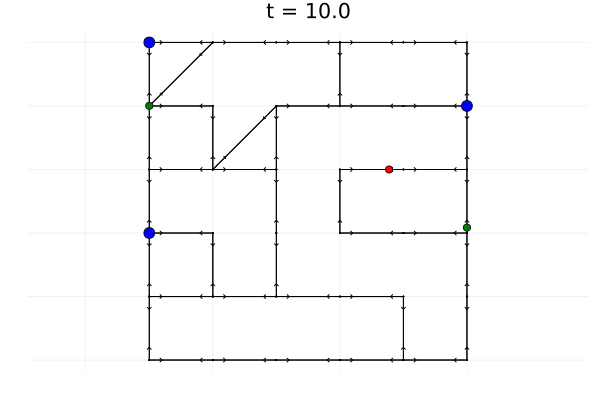

In [63]:
grid_size = 10
trial = 2
t_max_offset_cs = 3075
use_orig_t_max = true
oracle_num = 2  # 1 for Zhang, 2 for network

animate_first_support_strats_in_file(grid_size, trial, t_max_offset_cs, use_orig_t_max, oracle_num)

In [114]:
def_strats = get_def_strats_from_JSON(grid_trial_tmax2filename(6, 7, T_MAX_OFFSETS_CS_LIST[7]), oracle_num=1)

LoadError: BoundsError: attempt to access 6-element Vector{Int64} at index [7]

In [49]:
def_strats = get_def_strats_from_JSON(grid_trial_tmax2filename(4, 8, 75), oracle_num=1)

382-element Vector{Vector{Vector{@NamedTuple{v::Int64, t_a::Float64, t_b::Float64}}}}:
 [[(v = 7, t_a = 0.0, t_b = 0.0), (v = 3, t_a = 24.0, t_b = 91.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 ⋮
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a = 0.0, t_b = 24.0)]]
 [[(v = 7, t_a

In [64]:
the_eig.dist_mtx[the_eig.network.v_0, the_eig.network.v_∞]

88000.0

In [66]:
30 * 400 * 20

240000

### Exploratory data analysis

In [54]:
# printing speeds

for grid_size in 3:10
    for trial_num in 1:10
        filepath = converttrial2filepath(grid_size, trial_num)
        
        # weird formatting with speeds; so do it this way
        data_speed_D = parse(Int64, CSV.File(filepath * "Player_Speeds.csv")[1].var"Defender Speed")  # defender speed
        data_speed_A = CSV.File(filepath * "Player_Speeds.csv", skipto=4)[1].var"Defender Speed"  # attacker speed (weird formatting of orig file)

        println("grid $grid_size trial $trial_num: a_s=$data_speed_A, d_s=$data_speed_D")
    end
end

grid 3 trial 1: a_s=1, d_s=1
grid 3 trial 2: a_s=1, d_s=1
grid 3 trial 3: a_s=1, d_s=1
grid 3 trial 4: a_s=3, d_s=1
grid 3 trial 5: a_s=3, d_s=1
grid 3 trial 6: a_s=3, d_s=1
grid 3 trial 7: a_s=3, d_s=1
grid 3 trial 8: a_s=3, d_s=2
grid 3 trial 9: a_s=3, d_s=2
grid 3 trial 10: a_s=3, d_s=2
grid 4 trial 1: a_s=5, d_s=5
grid 4 trial 2: a_s=5, d_s=5
grid 4 trial 3: a_s=5, d_s=5
grid 4 trial 4: a_s=5, d_s=7
grid 4 trial 5: a_s=5, d_s=7
grid 4 trial 6: a_s=5, d_s=7
grid 4 trial 7: a_s=3, d_s=10
grid 4 trial 8: a_s=3, d_s=10
grid 4 trial 9: a_s=3, d_s=10
grid 4 trial 10: a_s=5, d_s=10
grid 5 trial 1: a_s=1, d_s=1
grid 5 trial 2: a_s=1, d_s=1
grid 5 trial 3: a_s=1, d_s=1
grid 5 trial 4: a_s=2, d_s=3
grid 5 trial 5: a_s=2, d_s=3
grid 5 trial 6: a_s=2, d_s=3
grid 5 trial 7: a_s=2, d_s=3
grid 5 trial 8: a_s=3, d_s=5
grid 5 trial 9: a_s=3, d_s=5
grid 5 trial 10: a_s=3, d_s=5
grid 6 trial 1: a_s=20, d_s=20
grid 6 trial 2: a_s=20, d_s=20
grid 6 trial 3: a_s=20, d_s=20
grid 6 trial 4: a_s=10, d_s=20

In [95]:
the_eig.network.v_0r

2-element Vector{Int64}:
  4
 34

In [96]:
function print_info_on_instance(grid_size, trial_num; force_speed_A=nothing, force_speed_D=nothing, att_graph=true, def_graph=true)
    """
    Prints information on a specific instance:
        t_max (non-scaled)
        att shortest v_0-v_∞ time: distance from v_0 to v_∞ for the attacker (non-scaled)
        No. nodes in att graph
        No. arcs in att graph
        No. nodes in def graph
        No. arcs in def graph

    att_graph: if true, will try to construct the attacker oracle graph and display the relevant information as above; won't otherwise
    def_graph: if true, will try to construct the defender oracle graph and display the relevant information as above; won't otherwise
    """
    filepath = converttrial2filepath(grid_size, trial_num)
    
    data_t_max = CSV.File(filepath * "Time_Limits.csv", header=["col1"])
    t_max = data_t_max[1].col1
    # T_MAX = t_max * data_speed_A * data_speed_D  # single int. SPEED ADJUSTING; scale by s_A*s_D

    eig = getEIGfromfile(filepath, force_speed_A=force_speed_A, force_speed_D=force_speed_D)

    att_dist = eig.dist_mtx[eig.network.v_0, eig.network.v_∞] / (eig.speed_A^2 * eig.speed_D)
    
    println("grid $grid_size trial $trial_num:")
    println("  raw t_max: $t_max\n  att shortest v_0-v_∞ time: $att_dist")
    println("  speed_A: $(eig.speed_A)\n  speed_D: $(eig.speed_D)")
    println("  No. arcs: $(length(eig.network.edges))")
    println("  No. res: $(length(eig.network.v_0r))")
    
    
    # if att_graph
    #     time_att_constr = @elapsed att_graph = constructattackeroraclegraph(eig)
    #     num_nodes_att = length(att_graph.new_vs)
    #     num_arcs_att = sum(length(value) for (key, value) in att_graph.arc_lists_o)
    #     println("  Attacker oracle network:")
    #     println("   Construction time: $time_att_constr")
    #     println("   No. att nodes: $num_nodes_att")
    #     println("   No. att arcs:  $num_arcs_att")
    # end

    # if def_graph
    #     time_def_constr = @elapsed def_graph = constructdefenderoraclegraph(eig)
    #     num_nodes_def = length(def_graph.new_vs)
    #     num_arcs_def = sum(length(value) for (key, value) in def_graph.arc_lists_o)
    #     println("  Defender oracle network:")
    #     println("   Construction time: $time_def_constr")
    #     println("   No. def nodes: $num_nodes_def")
    #     println("   No. def arcs:  $num_arcs_def")
    # end
end

print_info_on_instance (generic function with 1 method)

In [97]:
for grid_size in 3:10
    for trial_num in 1:10
        print_info_on_instance(grid_size, trial_num)
    end
end

grid 3 trial 1:
  raw t_max: 50
  att shortest v_0-v_∞ time: 8.0
  speed_A: 1
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 2:
  raw t_max: 50
  att shortest v_0-v_∞ time: 21.0
  speed_A: 1
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 3:
  raw t_max: 50
  att shortest v_0-v_∞ time: 21.0
  speed_A: 1
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 4:
  raw t_max: 50
  att shortest v_0-v_∞ time: 7.0
  speed_A: 3
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 5:
  raw t_max: 35
  att shortest v_0-v_∞ time: 7.0
  speed_A: 3
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 6:
  raw t_max: 35
  att shortest v_0-v_∞ time: 4.0
  speed_A: 3
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 7:
  raw t_max: 35
  att shortest v_0-v_∞ time: 4.0
  speed_A: 3
  speed_D: 1
  No. arcs: 24
  No. res: 1
grid 3 trial 8:
  raw t_max: 35
  att shortest v_0-v_∞ time: 4.0
  speed_A: 3
  speed_D: 2
  No. arcs: 24
  No. res: 1
grid 3 trial 9:
  raw t_max: 35
  att shortest

In [62]:
for grid_size in 6:6
    for trial_num in 6:10
        print_info_on_instance(grid_size, trial_num, force_speed_A=30, force_speed_D=10)
    end
end

grid 6 trial 6:
  raw t_max: 25
  att shortest v_0-v_∞ time: 0.5266666666666666
  speed_A: 30
  speed_D: 10
  No. arcs: 94
  Attacker oracle network:
   Construction time: 14.846836981
   No. att nodes: 26442
   No. att arcs:  4870161
  Defender oracle network:
   Construction time: 0.176657181
   No. def nodes: 14403
   No. def arcs:  39402
grid 6 trial 7:
  raw t_max: 10
  att shortest v_0-v_∞ time: 0.5266666666666666
  speed_A: 30
  speed_D: 10
  No. arcs: 94
  Attacker oracle network:
   Construction time: 0.073058565
   No. att nodes: 1894
   No. att arcs:  36004
  Defender oracle network:
   Construction time: 0.011119312
   No. def nodes: 1015
   No. def arcs:  2018
grid 6 trial 8:
  raw t_max: 20
  att shortest v_0-v_∞ time: 0.5266666666666666
  speed_A: 30
  speed_D: 10
  No. arcs: 94
  Attacker oracle network:
   Construction time: 3.432519165
   No. att nodes: 16374
   No. att arcs:  1873638
  Defender oracle network:
   Construction time: 0.043076311
   No. def nodes: 4468


In [278]:
for grid_size in 6:6
    for trial_num in 1:10
        print_info_on_instance(grid_size, trial_num)
    end
end

grid 6 trial 1:
  raw t_max: 30
  att shortest v_0-v_∞ time: 0.55
  speed_A: 20
  speed_D: 20
  No. arcs: 94
  Attacker oracle network:
   Construction time: 2.020836636
   No. att nodes: 12122
   No. att arcs:  1050556
  Defender oracle network:
   Construction time: 0.083326554
   No. def nodes: 17607
   No. def arcs:  55147
grid 6 trial 2:
  raw t_max: 30
  att shortest v_0-v_∞ time: 0.2525
  speed_A: 20
  speed_D: 20
  No. arcs: 94
  Attacker oracle network:
   Construction time: 5.169065399
   No. att nodes: 15590
   No. att arcs:  2446816
  Defender oracle network:
   Construction time: 0.470179309
   No. def nodes: 17607
   No. def arcs:  55147
grid 6 trial 3:
  raw t_max: 30
  att shortest v_0-v_∞ time: 0.2525
  speed_A: 20
  speed_D: 20
  No. arcs: 94
  Attacker oracle network:
   Construction time: 5.592343762
   No. att nodes: 15590
   No. att arcs:  2446816
  Defender oracle network:
   Construction time: 0.32417081
   No. def nodes: 17419
   No. def arcs:  54630
grid 6 tri

In [277]:
grid_size = 6
trial_num = 2

print_info_on_instance(grid_size, trial_num)

grid 6 trial 2:
  raw t_max: 30
  att shortest v_0-v_∞ time: 0.2525
  speed_A: 20
  speed_D: 20
  No. arcs: 94
  Attacker oracle network:
   Construction time: 5.546568925
   No. att nodes: 15590
   No. att arcs:  2446816
  Defender oracle network:
   Construction time: 0.121926784
   No. def nodes: 17607
   No. def arcs:  55147


In [99]:
the_eig.speed_D

20

In [79]:
for (key, value) in att_graph.arc_lists_i
    println(length(value))
end

1
6
1
1
9
3
1
1
24
1
1
0
1
1
16
1
15
11
1
4
35
69
1
14
4
1
9
14
79
1
1
1
1
1
1
1
1
33
32
1
29
25
11
30
1
1
8
1
15
1
5
1
1
1
1
1
3
22
29
1
1
1
25
1
32
1
1
1
1
11
1
1
1
1
1
1
1
38
5
1
1
0
1
1
14
1
1
1
9
1
0
21
1
1
1
1
31
1
15
1
1
1
29
2
1
27
1
1
1
1
3
1
42
7
1
6
1
11
0
1
13
1
23
21
1
2
1
0
24
1
2
24
1
1
9
1
4
4
1
58
6
23
6
1
1
7
1
1
1
11
1
1
0
41
7
61
3
1
2
7
1
1
13
1
2
42
2
35
74
12
15
1
28
1
1
1
25
19
1
10
1
0
1
1
8
1
1
6
1
1
1
11
37
1
9
19
18
1
1
16
1
1
10
1
1
1
4
10
73
5
7
1
3
2
2
1
1
16
7
1
29
8
33
1
1
1
1
3
1
1
1
13
1
1
1
1
2
1
1
1
1
1
5
1
29
29
1
1
1
22
1
4
5
1
19
1
15
18
1
0
1
1
78
23
2
14
1
1
1
1
1
1
1
0
34
1
1
1
1
1
1
74
15
1
1
1
1
19
1
1
22
0
1
1
1
1
1
1
1
1
1
57
1
1
46
1
4
1
39
1
1
1
1
11
1
0
1
77
1
1
1
1
7
1
1
0
1
18
39
1
1
11
18
1
45
3
21
1
1
1
1
8
34
13
1
1
1
7
1
8
1
7
1
1
1
1
1
1
1
1
5
4
9
44
9
1
4
1
1
7
27
13
22
1
4
1
1
1
1
16
1
0
1
8
1
21
1
1
23
64
4
1
6
1
1
1
15
11
1
82
1
17
5
1
1
0
1
30
1
5
26
1
5
1
50
1
20
24
23
8
1
16
1
18
1
6
3
0
10
27
1
3
1
1
1
9
1
1
7
17
4
31
20


In [82]:
sum(length(value) for (key, value) in att_graph.arc_lists_i)

7480